## DML para Painel com Heterogeneidade Não Observada

### Double Machine Learning - Correlated Random Effects (DML-CRE)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo

* Introdução
* Por que “demeanar e rodar DML” é perigoso?
* O que é o DML + CRE (Mundlak) que eles recomendam?
* O que os autores encontram nas simulações?
* Recomendações formais
* Um “esqueleto” de DML em painel 
* Resumo


### Referência

* Jonathan Fuhr and Dominik Papies (2024). Double Machine Learning meets Panel Data - Promises, Pitfalls, and Potential Solutions. https://arxiv.org/abs/2409.01266


**Observações:** O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer *feedback* ou sugestão de melhoria.

---

#### Introdução

O artigo parte do DML “padrão” (Chernozhukov et al., 2018), que é pensado para **amostra i.i.d. cross-sectional**, e pergunta:

> “Como adaptar DML para **painel** quando há heterogeneidade não observada (U_i) que afeta tanto (Y_{it}) quanto (X_{it})?”

Eles consideram um modelo do tipo:

$$
Y_{it} = \theta_0 D_{it} + g_0(X_{it}, U_i) + \varepsilon_{it}
$$

* $Y_{it}$ – outcome de interesse 
* $D_{it}$ – tratamento cujo efeito causal (\theta_0) queremos identificar.
* $X_{it}$ – vetor de confounders observados 
* $U_i$ – heterogeneidade **não observada**, fixa no tempo (características intrínsecas do nível individual $i$)
* E a chave: **eles admitem explicitamente o caminho (U_i \to X_{it})**, i.e., $U_i$ influencia também os confounders observados. 

Esse caminho $U_i \to X_{it}$ é o que mata a complacência: não é só FE linear clássico; com confusão não linear, “aplicar FE e depois DML” deixa de ser uma solução simples.


#### Por que “demeanar e rodar DML” é perigoso?

A nossa tentação natural é:

1. Fazer **within transform** (***demeaning por unidade***) em ($Y$), ($D$), ($X$);
2. Rodar DML nos dados transformados, análogo ao FE.

O artigo mostra, via simulações, que:

* DML em variáveis time-demeaned, à la FE, é **fortemente enviesado** quando a relação de confusão é não linear, justamente porque nesse caso o “efeito fixo aditivo” não separa bem $U_i$ de $X_{it}$. 
* Vários esquemas intuitivos que tentam “tirar” $U_i$ primeiro e depois aplicar DML falham quando há não linearidade e/ou $U_i \to X_{it}$. 

Moral: **não** seguir aquele impulso de:

> “Vou transformar tudo em desvio da média individual e pronto.”

Econometricamente, o que a simulação mostra é:

* O FE clássico funciona num mundo **paramétrico linear** com $U_i$ aditivo;
* Quando você substitui essa fase de “ajustar por $X_{it}$” por um ML flexível dentro de DML, a estrutura additiva em $U_i$ pode não segurar, e o demeaning “bagunça” a identificação do efeito de interesse.


#### O que é o DML + CRE (Mundlak) que eles recomendam?

A solução que funciona bem nos experimentos deles é usar DML com uma adaptação **à la Mundlak (1978)**:

***Idéia de CRE/Mundlak***

Em painel linear tradicional, o método de **Correlated Random Effects (CRE)** diz:

* Em vez de assumir $U_i$ independente de $X_{it}$, modelar:

$$
U_i = \alpha + \bar{X}_i'\delta + a_i,
$$

onde $\bar{X}_i$ são as **médias no tempo** das covariáveis de cada unidade (Mundlak).

* Inserindo $\bar{X}*i$ como regressoras, você “limpa” a correlação entre $X*{it}$ e $U_i$; o resto $a_i$ vira efeito aleatório “puro”.

O artigo leva essa ideia para dentro do DML:

> **Adicionar as médias por unidade $\bar{X}_i$ como covariáveis extras nos modelos de previsão usados em DML**, tanto no modelo de outcome quanto no de tratamento/propensity. 

Ou seja, em vez de de-mean, você **enriquece $X_{it}$**:

$$
X_{it}^{\text{aug}} = \big(X_{it}, \bar{X}_i\big).
$$



### O que os autores encontram nas simulações?

* DML em de-meaned data (tipo FE) → **grande viés** quando o confounding é não linear. 
* DML com CRE/Mundlak (isto é, incluindo médias de $X_{it}$ nos modelos ML) → funciona bem em vários cenários, desde que:

  * **amostra grande** em relação ao número de covariáveis (porque você está duplicando o número de features).
* Variações da forma de cross-fitting (aleatória, por tempo, por bloco) afetam pouco o viés/consistência, comparado com o problema da heterogeneidade não observada; o grande “ganho” vem de modelar $U_i$ via Mundlak. 

### Recomendações formais

Eles explicitam quatro recomendações finais: 

1. **Sempre comparar FE tradicional com DML+CRE**

   * Em aplicações onde hoje você usa FE, rode também DML com CRE (Mundlak) e compare os coeficientes. Diferenças grandes sugerem problemas de especificação funcional no modelo linear FE.

2. **Confiar mais no DML quando $N$ é grande e $p$ é pequeno**

   * Ganho de DML é maior se você tem muitas observações e um conjunto não tão gigantesco de confounders observados.

3. **Não fazer cross-fitting “por unidade” se seu objetivo é modelar $U_i$**

   * Dentro do algoritmo DML, quando você faz as predições ML dos termos de confusão, **não separe as unidades em folds distintos** (i.e., não usar GroupKFold por unidade no cross-fitting), porque isso impede o ML de ver a relação entre $\bar{X}*i$ e $X*{it}$ ao longo do tempo para aquele mesmo $i$. 
   * Ou seja: **cross-fitting por observação, não por unidade**.

4. **Não levar a sério os erros-padrão desses DML em painel**

   * Ainda não há teoria clara para variâncias quando há **dependência em cluster (unidade) + tempo** + cross-fitting.
   * Moral: usar esses DML em painel principalmente como **estimadores pontuais / checks de robustez**, não para inference “bonitinha” com IC 95% “oficial”. 


### Um “esqueleto” de DML em painel 

1. **Definir o objeto causal**

   * Ex.: efeito médio de $D$ sobre a $Y$

2. **Construir $X_{it}$ e $\bar{X}_i$**

   * features $X$ + suas médias por unidade $i$.

3. **Rodar DML parcialmente linear** (tipo `LinearDML` ou `DML` customizado):

   * Outcome model: $Y_{it} \sim f(X_{it}, \bar{X}_i)$ via ML.
   * Treatment model: $D_{it} \sim g(X_{it}, \bar{X}_i)$ via ML.
   * Cross-fitting: KFold ou blocos de tempo **sem separar por município**.
   * Estimador final: regressão da pseudo-outcome na pseudo-treatment (score Neyman-ortogonal), como no DML padrão.

4. **Comparar esse $\hat{\theta}_{DML+CRE}$ com o FE tradicional**

   * FE linear clássico (demeaning) como benchmark.
   * Diferenças grandes → suspeita de misspecificação funcional na FE.

5. **Usar os erros-padrão com parcimônia**

   * Conforme recomendação (4): não vender os IC como “gold standard”, por limitação teórica ainda aberta.


### Resumo

  * Não aplicar FE/demeaning antes de ML;
  * Construir Mundlak (médias por município) para todas as covariáveis relevantes e incluí-las nos modelos;
  * Quando quiser fazer DML causal, fazer cross-fitting por observações (ou blocos de tempo), não por unidade;
  * Tratar os DML como estimadores pontuais robustos e usar FE como benchmark, sem confiar cegamente em SEs.

### Aplicação em Python


Vamos aplicar o DML aos dados em painel, incluindo as médias por unidade (Mundlak) como features adicionais.

In [788]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

data = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/bacon_example.dta")

In [789]:
data

,stfips,year,_nfd,post,asmrs,pcinc,asmrh,cases,weight,copop
0,1,1964.0,1971.0,0.0,35.639885,12406.178537,5.007341,0.012312,1.715156e+06,1.715156e+06
1,1,1965.0,1971.0,0.0,41.543755,13070.206738,4.425367,0.010419,1.715156e+06,1.725186e+06
2,1,1966.0,1971.0,0.0,34.252335,13526.663217,4.874819,0.009900,1.715156e+06,1.735219e+06
3,1,1967.0,1971.0,0.0,34.465023,13918.189823,5.362014,0.009975,1.715156e+06,1.745250e+06
4,1,1968.0,1971.0,0.0,40.440105,14684.808682,4.643759,0.012401,1.715156e+06,1.755283e+06
...,...,...,...,...,...,...,...,...,...,...
1612,56,1992.0,1977.0,1.0,33.149574,31181.450546,1.970134,0.028996,1.621688e+05,2.323830e+05
1613,56,1993.0,1977.0,1.0,63.909775,31666.776231,3.020953,0.026672,1.621688e+05,2.355600e+05
1614,56,1994.0,1977.0,1.0,81.793816,31959.528356,3.501871,0.023643,1.621688e+05,2.389800e+05
1615,56,1995.0,1977.0,1.0,30.630585,32327.659531,0.740606,0.020965,1.621688e+05,2.414090e+05


In [790]:
# Outcome (Suicide Mortality)
data['Y'] = data['asmrs']
# Treatment D (Staggered treatment adoption)
data['D'] = data['post']
# Covariáveis - pcinc asmrh cases
data['X1'] = data['pcinc']
data['X2'] = data['asmrh']
data['X3'] = data['cases']
data['X4'] = data['copop']

# Identificação do painel
data['year'] = data['year'].astype(int)
data['id'] = data['stfips'].astype('category').cat.codes + 1


# Relative time (Tempo relativo até o tratamento - ocorre somente para os tratados)
data['reltime'] = data['year'] - data['_nfd']
# colocar valor zero caso tenha dados faltantes
data['reltime'] = data['reltime'].fillna(0)
# garantir que 'reltime' seja um inteiro
data['reltime'] = data['reltime'].astype(int)

# Generates a new column called 'ct' containing the numerics version of calendar time 'year'
data['ct'] = data['year'] - 1964

# Vamos criar a variável de grupo (cohoort) e G (Callaway-SantAnna)
data['cohort'] = data['_nfd'] - 1965
data['G']=data['_nfd']

# control group
data['treated'] = 0
data.loc[data['_nfd'] > 0, 'treated'] = 1
data['untreated_group'] = 1
data.loc[data['treated'] == 1, 'untreated_group'] = 0

# Criar uma coluna que identifica os indivíduos que nunca foram tratados (nevertreated)
data['nevertreated'] = 0
data.loc[data['treated'] == 0, 'nevertreated'] = 1

# Criar uma coluna que identifica os indivíduos que sempre foram tratados (alwaystreated) Deve ser 1 para todos os anos após o tratamento D
data['mean_treat'] = data.groupby('id')['D'].transform('mean')
# Criar os sempre tratados
data['alwaystreated'] = 0
data.loc[(data['mean_treat'] == 1), 'alwaystreated'] = 1

In [791]:
data

,stfips,year,_nfd,post,asmrs,pcinc,asmrh,cases,weight,copop,...,id,reltime,ct,cohort,G,treated,untreated_group,nevertreated,mean_treat,alwaystreated
0,1,1964,1971.0,0.0,35.639885,12406.178537,5.007341,0.012312,1.715156e+06,1.715156e+06,...,1,-7,0,6.0,1971.0,1,0,0,0.787879,0
1,1,1965,1971.0,0.0,41.543755,13070.206738,4.425367,0.010419,1.715156e+06,1.725186e+06,...,1,-6,1,6.0,1971.0,1,0,0,0.787879,0
2,1,1966,1971.0,0.0,34.252335,13526.663217,4.874819,0.009900,1.715156e+06,1.735219e+06,...,1,-5,2,6.0,1971.0,1,0,0,0.787879,0
3,1,1967,1971.0,0.0,34.465023,13918.189823,5.362014,0.009975,1.715156e+06,1.745250e+06,...,1,-4,3,6.0,1971.0,1,0,0,0.787879,0
4,1,1968,1971.0,0.0,40.440105,14684.808682,4.643759,0.012401,1.715156e+06,1.755283e+06,...,1,-3,4,6.0,1971.0,1,0,0,0.787879,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,56,1992,1977.0,1.0,33.149574,31181.450546,1.970134,0.028996,1.621688e+05,2.323830e+05,...,49,15,28,12.0,1977.0,1,0,0,0.606061,0
1613,56,1993,1977.0,1.0,63.909775,31666.776231,3.020953,0.026672,1.621688e+05,2.355600e+05,...,49,16,29,12.0,1977.0,1,0,0,0.606061,0
1614,56,1994,1977.0,1.0,81.793816,31959.528356,3.501871,0.023643,1.621688e+05,2.389800e+05,...,49,17,30,12.0,1977.0,1,0,0,0.606061,0
1615,56,1995,1977.0,1.0,30.630585,32327.659531,0.740606,0.020965,1.621688e+05,2.414090e+05,...,49,18,31,12.0,1977.0,1,0,0,0.606061,0


In [798]:
# Médias no tempo por unidade (Mundlak)
group_means = data.groupby('id')[['D', 'X1', 'X2', 'X3', 'X4', 'year']].transform('mean')
group_means.columns = ['D_bar', 'X1_bar', 'X2_bar', 'X3_bar', 'X4_bar', 'year_bar']

data = pd.concat([data, group_means], axis=1)

In [799]:
data

,stfips,year,_nfd,post,asmrs,pcinc,asmrh,cases,weight,copop,...,X2_bar,X3_bar,X4_bar,year_bar,D_bar,X1_bar,X2_bar,X3_bar,X4_bar,year_bar
0,1,1964,1971.0,0.0,35.639885,12406.178537,5.007341,0.012312,1.715156e+06,1.715156e+06,...,5.096281,0.022274,1.979542e+06,1980.0,0.787879,21366.548034,5.096281,0.022274,1.979542e+06,1980.0
1,1,1965,1971.0,0.0,41.543755,13070.206738,4.425367,0.010419,1.715156e+06,1.725186e+06,...,5.096281,0.022274,1.979542e+06,1980.0,0.787879,21366.548034,5.096281,0.022274,1.979542e+06,1980.0
2,1,1966,1971.0,0.0,34.252335,13526.663217,4.874819,0.009900,1.715156e+06,1.735219e+06,...,5.096281,0.022274,1.979542e+06,1980.0,0.787879,21366.548034,5.096281,0.022274,1.979542e+06,1980.0
3,1,1967,1971.0,0.0,34.465023,13918.189823,5.362014,0.009975,1.715156e+06,1.745250e+06,...,5.096281,0.022274,1.979542e+06,1980.0,0.787879,21366.548034,5.096281,0.022274,1.979542e+06,1980.0
4,1,1968,1971.0,0.0,40.440105,14684.808682,4.643759,0.012401,1.715156e+06,1.755283e+06,...,5.096281,0.022274,1.979542e+06,1980.0,0.787879,21366.548034,5.096281,0.022274,1.979542e+06,1980.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,56,1992,1977.0,1.0,33.149574,31181.450546,1.970134,0.028996,1.621688e+05,2.323830e+05,...,3.005445,0.014725,2.093611e+05,1980.0,0.606061,26710.836779,3.005445,0.014725,2.093611e+05,1980.0
1613,56,1993,1977.0,1.0,63.909775,31666.776231,3.020953,0.026672,1.621688e+05,2.355600e+05,...,3.005445,0.014725,2.093611e+05,1980.0,0.606061,26710.836779,3.005445,0.014725,2.093611e+05,1980.0
1614,56,1994,1977.0,1.0,81.793816,31959.528356,3.501871,0.023643,1.621688e+05,2.389800e+05,...,3.005445,0.014725,2.093611e+05,1980.0,0.606061,26710.836779,3.005445,0.014725,2.093611e+05,1980.0
1615,56,1995,1977.0,1.0,30.630585,32327.659531,0.740606,0.020965,1.621688e+05,2.414090e+05,...,3.005445,0.014725,2.093611e+05,1980.0,0.606061,26710.836779,3.005445,0.014725,2.093611e+05,1980.0


In [805]:
# Matriz de features para o DML (níveis + médias)
year_dummies = pd.get_dummies(data['year'], prefix='year', drop_first=True)
X_cre = pd.concat(
    [data[['X1','X2','X3', 'X4', 'X1_bar','X2_bar','X3_bar','X4_bar','D_bar']], year_dummies],
    axis=1
)
Y = data['Y'].values
T = data['D'].values

In [806]:
from xgboost import XGBRegressor, XGBClassifier
from econml.dml import LinearDML
import numpy as np

# Modelo para Y|X (regressão)
base_learner_y = XGBRegressor(
    n_estimators=600,
    learning_rate=0.005,
    max_depth=10,
    subsample=0.6,
    colsample_bytree=0.9,
    tree_method="hist",   # geralmente mais rápido
    n_jobs=-1,
    random_state=42
)

# Modelo para T|X (classificação, pois T é binário)
base_learner_t = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

dml_cre_xgb = LinearDML(
    model_y=base_learner_y,
    model_t=base_learner_t,
    discrete_treatment=True,   # importante para usar predict_proba no modelo T
    cv=3,
    random_state=42
)

dml_cre_xgb.fit(
    Y, T,
    X=X_cre.values,
    W=None
)

ate_cre_xgb = dml_cre_xgb.ate(X=X_cre.values)
print("ATE (XGBoost CRE):", ate_cre_xgb)

cate_cre_xgb = dml_cre_xgb.effect(X_cre.values)
print("média dos CATEs:", np.mean(cate_cre_xgb))


ATE (XGBoost CRE): -5.044322261385756
média dos CATEs: -5.044322261385756


***Event Study***

In [807]:
import numpy as np
import pandas as pd

# =========================
# 1) Event study via DML-CRE
# =========================

# janela de períodos (igual ao seu TWFE)
ks = sorted(data['reltime'].unique())
ks = [k for k in ks if k != 0]   # remove baseline (0 é o período omitido aqui)

results = []

# CATEs para toda a amostra (mais eficiente)
cate_all = dml_cre_xgb.effect(X_cre.values)

for k in ks:
    # índice das observações naquele reltime
    mask_k = (data['reltime'].to_numpy() == k)
    idx_k = np.where(mask_k)[0]

    # CATE no subconjunto: tau(k)
    cate_k = cate_all[idx_k]
    tau_k = np.mean(cate_k)

    # bootstrap para IC
    boot = []
    B = 1000
    for _ in range(B):
        idx_boot = np.random.choice(idx_k, size=len(idx_k), replace=True)
        boot.append(np.mean(cate_all[idx_boot]))

    lower = np.percentile(boot, 2.5)
    upper = np.percentile(boot, 97.5)

    results.append([k, tau_k, lower, upper])

# Montar tabela final
est_dml = pd.DataFrame(results, columns=['reltime', 'coef', 'lower', 'upper'])
est_dml = est_dml.sort_values('reltime').reset_index(drop=True)


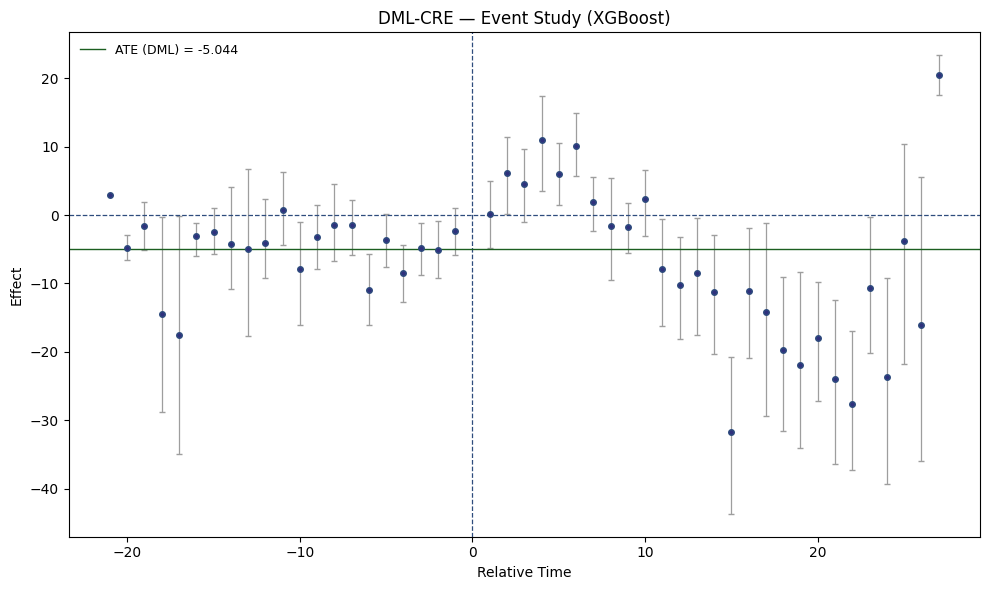

In [808]:
import matplotlib.pyplot as plt

# =========================
# 2) Gráfico (pontos + IC)
# =========================
x = est_dml["reltime"].to_numpy()
y = est_dml["coef"].to_numpy()
yerr = np.vstack([
    y - est_dml["lower"].to_numpy(),
    est_dml["upper"].to_numpy() - y
])

plt.figure(figsize=(10, 6))
plt.errorbar(
    x, y, yerr=yerr,
    fmt='o', markersize=4,
    markerfacecolor="#2E317D", markeredgecolor="#2E4C7D",
    ecolor="#9E9E9E", elinewidth=0.9, capsize=2
)

# Linha em zero (efeito nulo)
plt.axhline(0, linestyle='--', linewidth=0.9, color='#2E4C7D')

# Linha vertical no período de referência
# Se o período omitido for 0 (como no seu loop), use 0:
plt.axvline(0, linestyle='--', linewidth=0.9, color='#2E4C7D')
# Se você passar a omitir o -1 (como no CS), troque para:
# plt.axvline(-1, linestyle='--', linewidth=0.9, color='#2E4C7D')

# Linha do ATT médio (DML)
try:
    att_val = float(dml_cre_xgb.ate(X=X_cre.values))
    plt.axhline(att_val, color="#1B5E20", linestyle="-", linewidth=1.0,
                label=f"ATE (DML) = {att_val:.3f}")
    plt.legend(frameon=False, fontsize=9)
except Exception:
    pass

plt.title("DML-CRE — Event Study (XGBoost)", fontsize=12)
plt.xlabel("Relative Time", fontsize=10)
plt.ylabel("Effect", fontsize=10)
plt.tight_layout()
plt.show()


***Segunda tentativa***

Vamos agregar mais covariáveis, a tendência temporal "ct"

In [629]:
data

,stfips,year,_nfd,post,asmrs,pcinc,asmrh,cases,weight,copop,...,untreated_group,nevertreated,mean_treat,alwaystreated,D_bar,X1_bar,X2_bar,X3_bar,X4_bar,year_bar
0,1,1964,1971.0,0.0,35.639885,12406.178537,5.007341,0.012312,1.715156e+06,1.715156e+06,...,0,0,0.787879,0,0.787879,21366.548034,5.096281,0.022274,1.979542e+06,1980.0
1,1,1965,1971.0,0.0,41.543755,13070.206738,4.425367,0.010419,1.715156e+06,1.725186e+06,...,0,0,0.787879,0,0.787879,21366.548034,5.096281,0.022274,1.979542e+06,1980.0
2,1,1966,1971.0,0.0,34.252335,13526.663217,4.874819,0.009900,1.715156e+06,1.735219e+06,...,0,0,0.787879,0,0.787879,21366.548034,5.096281,0.022274,1.979542e+06,1980.0
3,1,1967,1971.0,0.0,34.465023,13918.189823,5.362014,0.009975,1.715156e+06,1.745250e+06,...,0,0,0.787879,0,0.787879,21366.548034,5.096281,0.022274,1.979542e+06,1980.0
4,1,1968,1971.0,0.0,40.440105,14684.808682,4.643759,0.012401,1.715156e+06,1.755283e+06,...,0,0,0.787879,0,0.787879,21366.548034,5.096281,0.022274,1.979542e+06,1980.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,56,1992,1977.0,1.0,33.149574,31181.450546,1.970134,0.028996,1.621688e+05,2.323830e+05,...,0,0,0.606061,0,0.606061,26710.836779,3.005445,0.014725,2.093611e+05,1980.0
1613,56,1993,1977.0,1.0,63.909775,31666.776231,3.020953,0.026672,1.621688e+05,2.355600e+05,...,0,0,0.606061,0,0.606061,26710.836779,3.005445,0.014725,2.093611e+05,1980.0
1614,56,1994,1977.0,1.0,81.793816,31959.528356,3.501871,0.023643,1.621688e+05,2.389800e+05,...,0,0,0.606061,0,0.606061,26710.836779,3.005445,0.014725,2.093611e+05,1980.0
1615,56,1995,1977.0,1.0,30.630585,32327.659531,0.740606,0.020965,1.621688e+05,2.414090e+05,...,0,0,0.606061,0,0.606061,26710.836779,3.005445,0.014725,2.093611e+05,1980.0


In [630]:
data['ct2'] = data['ct'] ** 2
data['ct3'] = data['ct'] ** 3
data['ct4'] = data['ct'] ** 4
data['ct5'] = data['ct'] ** 5

In [631]:
# colocar zero quando for Nan
data['G_fix'] = data['G'].fillna(0)

In [633]:
# Matriz de features para o DML (níveis + médias)
year_dummies = pd.get_dummies(data['year'], prefix='year', drop_first=True)
FE_dummies = pd.get_dummies(data['id'], prefix='id', drop_first=True)
G_dummies = pd.get_dummies(data['G_fix'], prefix='G', drop_first=True)
X_cre = pd.concat(
    [data[['X1','X2','X3', 'X4','X1_bar','X2_bar','X3_bar', 'X4_bar', 'D_bar', 'G_fix']], year_dummies],
    axis=1
)
Y = data['Y'].values
T = data['D'].values

In [636]:
from xgboost import XGBRegressor, XGBClassifier
from econml.dml import LinearDML
import numpy as np


# Modelo para Y|X (regressão)
base_learner_y = XGBRegressor(
    n_estimators=600,
    learning_rate=0.005,
    max_depth=10,
    subsample=0.6,
    colsample_bytree=0.9,
    tree_method="hist",   # geralmente mais rápido
    n_jobs=-1,
    random_state=42
)

# Modelo para T|X (classificação, pois T é binário)
base_learner_t = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

dml_cre_xgb = LinearDML(
    model_y=base_learner_y,
    model_t=base_learner_t,
    discrete_treatment=True,   # importante para usar predict_proba no modelo T
    cv=3,
    random_state=42
)

dml_cre_xgb.fit(
    Y, T,
    X=X_cre.values,
    W=None
)

ate_cre_xgb = dml_cre_xgb.ate(X=X_cre.values)
print("ATE (XGBoost CRE):", ate_cre_xgb)

cate_cre_xgb = dml_cre_xgb.effect(X_cre.values)
print("média dos CATEs:", np.mean(cate_cre_xgb))

ATE (XGBoost CRE): -14.939417309684499
média dos CATEs: -14.939417309684499


In [637]:
import numpy as np
import pandas as pd

# ============================
# 1) Event study via DML-CRE
# ============================

ks = sorted(data['reltime'].unique())
ks = [k for k in ks if k != 0]  # baseline omitido

results = []

# CATEs para toda amostra
cate_all = dml_cre_xgb.effect(X_cre.values)

ids = data["id"].to_numpy()
reltime = data["reltime"].to_numpy()

# Função geradora dos pesos Wild Bootstrap (Rademacher)
def wild_weights(num_clusters):
    return np.random.choice([-1, 1], size=num_clusters)

for k in ks:

    # observações no k
    mask_k = (reltime == k)
    idx_k = np.where(mask_k)[0]

    cate_k = cate_all[idx_k]
    tau_k = np.mean(cate_k)

    # clusters presentes no k
    ids_k = np.unique(ids[idx_k])
    Gk = len(ids_k)

    # Pré-calcular resíduos dentro de k
    # r_i = CATE_i - tau_k
    res_k = cate_k - tau_k

    # Guardar qual cluster cada observação pertence
    cluster_map = {cid: np.where((ids[idx_k] == cid))[0] for cid in ids_k}

    # ====== wild cluster bootstrap =======
    B = 1000
    boot_vals = []

    for _ in range(B):
        # gera pesos +1/-1 para clusters
        w = wild_weights(Gk)

        # aplica o peso clusterizado nos resíduos
        res_star = np.zeros_like(res_k)

        for j, cid in enumerate(ids_k):
            obs = cluster_map[cid]
            res_star[obs] = w[j] * res_k[obs]

        # estatística bootstrap:
        tau_star = tau_k + np.mean(res_star)
        boot_vals.append(tau_star)

    lower = np.percentile(boot_vals, 2.5)
    upper = np.percentile(boot_vals, 97.5)

    results.append([k, tau_k, lower, upper])

# montar tabela final
est_dml = pd.DataFrame(results, columns=['reltime', 'coef', 'lower', 'upper'])
est_dml = est_dml.sort_values('reltime').reset_index(drop=True)


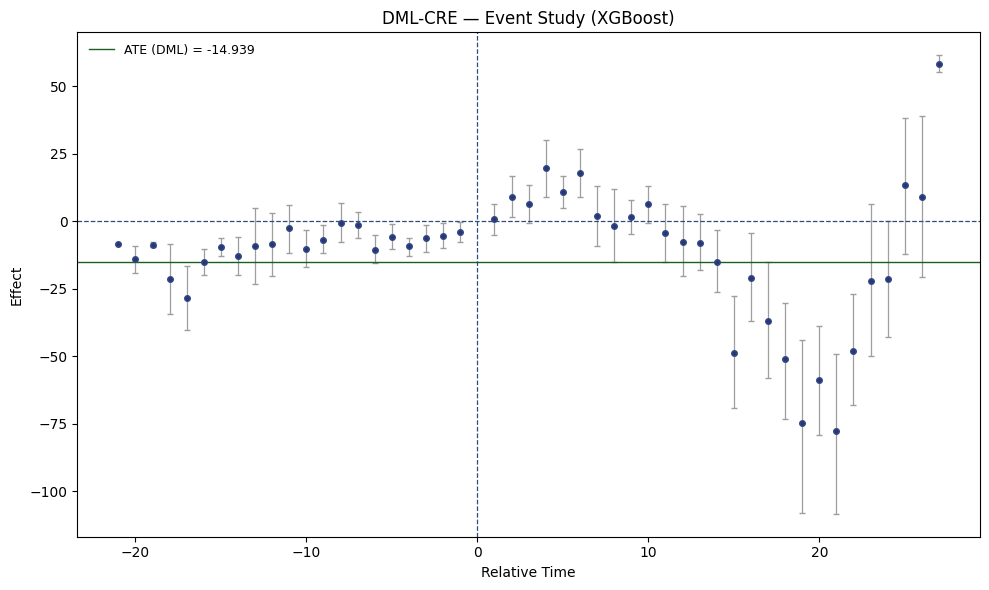

In [638]:
import matplotlib.pyplot as plt

# =========================
# 2) Gráfico (pontos + IC)
# =========================
x = est_dml["reltime"].to_numpy()
y = est_dml["coef"].to_numpy()
yerr = np.vstack([
    y - est_dml["lower"].to_numpy(),
    est_dml["upper"].to_numpy() - y
])

plt.figure(figsize=(10, 6))
plt.errorbar(
    x, y, yerr=yerr,
    fmt='o', markersize=4,
    markerfacecolor="#2E317D", markeredgecolor="#2E4C7D",
    ecolor="#9E9E9E", elinewidth=0.9, capsize=2
)

# Linha em zero (efeito nulo)
plt.axhline(0, linestyle='--', linewidth=0.9, color='#2E4C7D')

# Linha vertical no período de referência
# Se o período omitido for 0 (como no seu loop), use 0:
plt.axvline(0, linestyle='--', linewidth=0.9, color='#2E4C7D')
# Se você passar a omitir o -1 (como no CS), troque para:
# plt.axvline(-1, linestyle='--', linewidth=0.9, color='#2E4C7D')

# Linha do ATT médio (DML)
try:
    att_val = float(dml_cre_xgb.ate(X=X_cre.values))
    plt.axhline(att_val, color="#1B5E20", linestyle="-", linewidth=1.0,
                label=f"ATE (DML) = {att_val:.3f}")
    plt.legend(frameon=False, fontsize=9)
except Exception:
    pass

plt.title("DML-CRE — Event Study (XGBoost)", fontsize=12)
plt.xlabel("Relative Time", fontsize=10)
plt.ylabel("Effect", fontsize=10)
plt.tight_layout()
plt.show()

---



========== BUSCANDO MELHOR MODELO PARA Y|X ==========


>>> Rodando modelo: TREE
Modelo: TREE → Outer score: 149.7834

>>> Rodando modelo: BAGGING
Modelo: BAGGING → Outer score: 109.4990

>>> Rodando modelo: RF
Modelo: RF → Outer score: 102.5498

>>> Rodando modelo: GB
Modelo: GB → Outer score: 116.7494

>>> Rodando modelo: XGB
Modelo: XGB → Outer score: 87.5500

>>> Rodando modelo: LGB
Modelo: LGB → Outer score: 75.4393

>>> Rodando modelo: ADA
Modelo: ADA → Outer score: 184.1925

Melhor modelo Y|X: lgb
Melhor outer MSE: 75.439292745147
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(force_row_wise=True, learning_rate=0.005,
                               max_depth=10, n_estimators=600, n_jobs=-1,
                               subsample=0.6, verbose=-1))])


========== BUSCANDO MELHOR MODELO PARA T|X ==========


>>> Rodando modelo: TREE
Modelo: TREE → Outer score: 0.0542

>>> Rodando modelo: BAGGING
Modelo: BAGGING → Outer sco

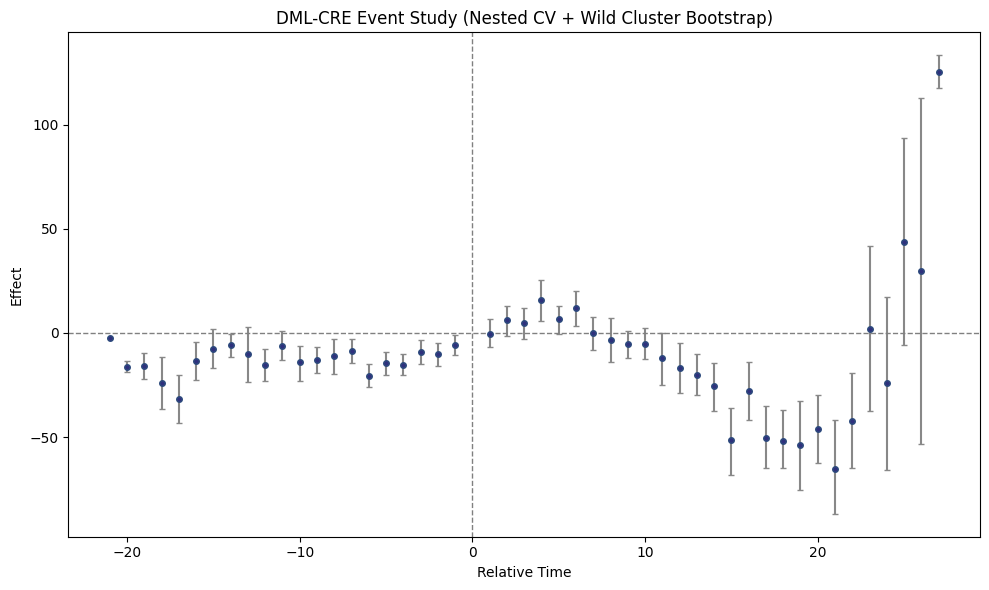

In [300]:
# ======================================================================
# 0) IMPORTS GERAIS
# ======================================================================

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    make_scorer, mean_squared_error, log_loss,
    mean_absolute_error, median_absolute_error, r2_score
)

# Modelos de regressão
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    BaggingRegressor, RandomForestRegressor,
    GradientBoostingRegressor, AdaBoostRegressor
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Modelos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier, RandomForestClassifier,
    GradientBoostingClassifier, AdaBoostClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# DML
from econml.dml import LinearDML

# ======================================================================
# 1) MATRIZ CRE (NÍVEIS + MÉDIAS)
# ======================================================================

year_dummies = pd.get_dummies(data['year'], prefix='year', drop_first=True)

X_cre = pd.concat([
    data[['X1','X2','X3','X1_bar','X2_bar','X3_bar','D_bar','G_fix']],
    year_dummies
], axis=1)

Y = data['Y'].values
T = data['D'].values
years = data['year'].values
ids = data['id'].values

# ======================================================================
# 2) MODELOS E GRADES MASSIVAS
# ======================================================================

def get_regression_models_and_grids():
    return [

        # ARVORE
        (
            "tree",
            DecisionTreeRegressor(),
            {
                "model__max_depth": [5, 10, 20, 40, None],
                "model__min_samples_leaf": [1, 2, 5, 10, 20],
                "model__max_leaf_nodes": [50, 100, 200, None],
            }
        ),

        # BAGGING
        (
            "bagging",
            BaggingRegressor(DecisionTreeRegressor(), n_jobs=-1),
            {
                "model__n_estimators": [200, 500, 800, 1200],
                "model__estimator__max_depth": [5, 10, 20, None],
                "model__estimator__min_samples_leaf": [1, 5, 10],
            }
        ),

        # RANDOM FOREST
        (
            "rf",
            RandomForestRegressor(n_jobs=-1),
            {
                "model__n_estimators": [300, 600, 1000, 1400],
                "model__max_depth": [10, 20, 40, None],
                "model__max_features": ["sqrt", "log2", 0.6, 0.8],
                "model__min_samples_leaf": [1, 2, 5, 10],
            }
        ),

        # GRADIENT BOOSTING
        (
            "gb",
            GradientBoostingRegressor(),
            {
                "model__n_estimators": [300, 600, 1000, 1500],
                "model__learning_rate": [0.01, 0.05, 0.1],
                "model__max_depth": [3, 5, 8],
                "model__min_samples_leaf": [1, 5, 10],
            }
        ),

        # XGBOOST
        (
            "xgb",
            XGBRegressor(n_jobs=-1, tree_method="hist", verbosity=0),
            {
                "model__n_estimators": [500, 800, 1200, 1600],
                "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
                "model__max_depth": [3, 5, 8, 10],
                "model__subsample": [0.6, 0.8, 1.0],
                "model__colsample_bytree": [0.6, 0.8, 1.0],
            }
        ),

        # LIGHTGBM
        (
            "lgb",
            LGBMRegressor(force_row_wise=True, verbose=-1, n_jobs=-1),
            {
                "model__n_estimators": [600, 1000, 1500, 2000],
                "model__learning_rate": [0.005, 0.01, 0.05, 0.1],
                "model__num_leaves": [31, 63, 127, 255],
                "model__subsample": [0.6, 0.8, 1.0],
                "model__max_depth": [5, 10, 20, -1],
            }
        ),

        # ADABOOST
        (
            "ada",
            AdaBoostRegressor(),
            {
                "model__n_estimators": [300, 600, 1000, 1500],
                "model__learning_rate": [0.01, 0.05, 0.1, 0.3],
            }
        ),
    ]

def get_classification_models_and_grids():
    return [

        ("tree",
         DecisionTreeClassifier(),
         {
             "model__max_depth": [5, 10, 20, 40, None],
             "model__min_samples_leaf": [1, 2, 5, 10],
         }),

        ("bagging",
         BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1),
         {
             "model__n_estimators": [200, 500, 800, 1200],
             "model__estimator__max_depth": [5, 10, 20, None],
         }),

        ("rf",
         RandomForestClassifier(n_jobs=-1),
         {
             "model__n_estimators": [300, 600, 1000, 1400],
             "model__max_depth": [10, 20, 40, None],
             "model__max_features": ["sqrt", "log2", 0.6, 0.8],
         }),

        ("gb",
         GradientBoostingClassifier(),
         {
             "model__n_estimators": [300, 600, 1000, 1500],
             "model__learning_rate": [0.01, 0.05, 0.1],
             "model__max_depth": [3, 5, 8],
         }),

        ("xgb",
         XGBClassifier(
             n_jobs=-1, tree_method="hist",
             eval_metric="logloss", use_label_encoder=False
         ),
         {
             "model__n_estimators": [500, 800, 1200, 1600],
             "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
             "model__max_depth": [3, 5, 8, 10],
             "model__subsample": [0.6, 0.8, 1.0],
             "model__colsample_bytree": [0.6, 0.8, 1.0],
         }),

        ("lgb",
         LGBMClassifier(force_row_wise=True, verbose=-1, n_jobs=-1),
         {
             "model__n_estimators": [600, 1000, 1500, 2000],
             "model__learning_rate": [0.005, 0.01, 0.05, 0.1],
             "model__num_leaves": [31, 63, 127, 255],
             "model__subsample": [0.6, 0.8, 1.0],
             "model__max_depth": [5, 10, 20, -1],
         }),

        ("ada",
         AdaBoostClassifier(),
         {
             "model__n_estimators": [300, 600, 1000, 1500],
             "model__learning_rate": [0.01, 0.05, 0.1, 0.3],
         }),
    ]

# ======================================================================
# 3) FUNÇÃO DE NESTED CV PARA PAINEL
#    Rolling window + GroupKFold
# ======================================================================

def nested_panel_cv(
    X, y, years, ids,
    models_and_grids,
    outer_splits=3,
    outer_test_years=2,
    inner_splits=3,
    scoring="neg_mean_squared_error"
):

    X = pd.DataFrame(X).reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)
    years = pd.Series(years).reset_index(drop=True)
    ids = pd.Series(ids).reset_index(drop=True)

    # Ordenar por ano
    order = np.argsort(years)
    X = X.iloc[order].reset_index(drop=True)
    y = y.iloc[order].reset_index(drop=True)
    years = years.iloc[order].reset_index(drop=True)
    ids = ids.iloc[order].reset_index(drop=True)

    uniq_years = np.sort(years.unique())
    n_years = len(uniq_years)
    total_test_years = outer_splits * outer_test_years
    start_pos = n_years - total_test_years

    outer_blocks = []
    for i in range(outer_splits):
        ts = start_pos + i * outer_test_years
        te = ts + outer_test_years
        test_years = uniq_years[ts:te]
        train_years = uniq_years[:ts]

        train_idx = np.where(years.isin(train_years))[0]
        test_idx = np.where(years.isin(test_years))[0]

        outer_blocks.append((train_idx, test_idx))

    best_model = None
    best_outer_score = np.inf
    best_params = None
    best_label = None

    for label, model, grid in models_and_grids:

        print(f"\n>>> Rodando modelo: {label.upper()}")

        pipeline = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("model", model)
        ])

        fold_scores = []
        fold_params = []

        for train_idx, test_idx in outer_blocks:

            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
            ids_tr = ids.iloc[train_idx]

            inner_cv = GroupKFold(n_splits=inner_splits)
            gs = GridSearchCV(
                estimator=pipeline, param_grid=grid,
                scoring=scoring, cv=inner_cv,
                n_jobs=-1
            )

            gs.fit(X_tr, y_tr, groups=ids_tr)

            best_est = gs.best_estimator_
            fold_params.append(gs.best_params_)

            y_pred = best_est.predict(X_te)

            if scoring == "neg_mean_squared_error":
                score = mean_squared_error(y_te, y_pred)
            elif scoring == "neg_log_loss":
                score = log_loss(y_te, y_pred)
            else:
                raise ValueError("Scoring não suportado.")

            fold_scores.append(score)

        avg_outer = np.mean(fold_scores)

        print(f"Modelo: {label.upper()} → Outer score: {avg_outer:.4f}")

        if avg_outer < best_outer_score:
            best_outer_score = avg_outer
            best_model = best_est
            best_params = fold_params
            best_label = label

    return best_label, best_model, best_params, best_outer_score

# ======================================================================
# 4) SELEÇÃO DO MELHOR MODELO PARA Y|X (REGRESSÃO)
# ======================================================================

print("\n\n========== BUSCANDO MELHOR MODELO PARA Y|X ==========\n")

regression_models = get_regression_models_and_grids()

best_label_y, best_model_y, best_params_y, score_y = nested_panel_cv(
    X_cre, Y, years, ids,
    regression_models,
    outer_splits=3,
    outer_test_years=2,
    inner_splits=3,
    scoring="neg_mean_squared_error"
)

print("\nMelhor modelo Y|X:", best_label_y)
print("Melhor outer MSE:", score_y)
print(best_model_y)

# ======================================================================
# 5) SELEÇÃO DO MELHOR MODELO PARA T|X (CLASSIFICAÇÃO)
# ======================================================================

print("\n\n========== BUSCANDO MELHOR MODELO PARA T|X ==========\n")

classification_models = get_classification_models_and_grids()

best_label_t, best_model_t, best_params_t, score_t = nested_panel_cv(
    X_cre, T, years, ids,
    classification_models,
    outer_splits=3,
    outer_test_years=2,
    inner_splits=3,
    scoring="neg_log_loss"
)

print("\nMelhor modelo T|X:", best_label_t)
print("Melhor outer LogLoss:", score_t)
print(best_model_t)

# ======================================================================
# 6) DML-CRE FINAL USANDO OS MELHORES MODELOS
# ======================================================================

dml_final = LinearDML(
    model_y=best_model_y,
    model_t=best_model_t,
    discrete_treatment=True,
    cv=3,
    random_state=42
)

dml_final.fit(Y, T, X=X_cre.values)

ate_final = dml_final.ate(X=X_cre.values)
cate_final = dml_final.effect(X=X_cre.values)

print("\nATE final (DML com tuning global):", ate_final)
print("Média dos CATEs:", np.mean(cate_final))

# ======================================================================
# 7) EVENT-STUDY + WILD CLUSTER BOOTSTRAP
# ======================================================================

reltime = data["reltime"].to_numpy()
ks = sorted(np.unique(reltime))
ks = [k for k in ks if k != 0]

results = []

def wild_weights(n):
    return np.random.choice([-1, 1], size=n)

for k in ks:
    mask_k = reltime == k
    idx_k = np.where(mask_k)[0]

    cate_k = cate_final[idx_k]
    tau_k = np.mean(cate_k)

    ids_k = np.unique(ids[idx_k])
    Gk = len(ids_k)

    res_k = cate_k - tau_k

    cluster_map = {cid: np.where(ids[idx_k] == cid)[0] for cid in ids_k}

    boot_vals = []
    B = 1000

    for _ in range(B):
        w = wild_weights(Gk)
        res_star = np.zeros_like(res_k)
        for j, cid in enumerate(ids_k):
            obs = cluster_map[cid]
            res_star[obs] = w[j] * res_k[obs]
        boot_vals.append(tau_k + np.mean(res_star))

    lower = np.percentile(boot_vals, 2.5)
    upper = np.percentile(boot_vals, 97.5)

    results.append([k, tau_k, lower, upper])

est_dml = pd.DataFrame(results, columns=["reltime", "coef", "lower", "upper"])
est_dml = est_dml.sort_values("reltime")

print("\nEvent-study:\n", est_dml)

# ======================================================================
# 8) GRÁFICO FINAL
# ======================================================================

x = est_dml["reltime"]
y = est_dml["coef"]
lower = est_dml["lower"]
upper = est_dml["upper"]

plt.figure(figsize=(10,6))

plt.errorbar(
    x, y,
    yerr=np.vstack([y - lower, upper - y]),
    fmt='o',
    markersize=4,
    markerfacecolor="#2E317D",
    markeredgecolor="#2E4C7D",
    ecolor="#888",
    capsize=2
)

plt.axhline(0, linestyle='--', linewidth=1, color='gray')
plt.axvline(0, linestyle='--', linewidth=1, color='gray')

plt.title("DML-CRE Event Study (Nested CV + Wild Cluster Bootstrap)")
plt.xlabel("Relative Time")
plt.ylabel("Effect")
plt.tight_layout()
plt.show()


In [312]:
import numpy as np
from sklearn.model_selection import GroupKFold

# =============================================================
#  CROSS-FITTING ROBUSTO PARA PAINEL (TEMPO + CLUSTER)
#  - Rolling window temporal
#  - Grupos de cluster por id
#  - Compatível com econml.LinearDML
# =============================================================

class PanelCrossFitCV:
    """
    Cross-fitting estruturado para dados em painel:
    
    • Respeita ordem temporal (rolling window)
    • Teste sempre em anos posteriores ao treino
    • Agrupamento por id (cluster robust)
    • Compatível com os métodos do econml
    """

    def __init__(self, years, ids, n_splits=5, test_window=1):
        """
        years: array-like com ano de cada observação
        ids: array-like com id de cada unidade (município)
        n_splits: número de folds (ex: 3 ou 5)
        test_window: tamanho da janela de teste (ex: 1 ano)
        """
        self.years = np.asarray(years)
        self.ids = np.asarray(ids)
        self.n_splits = n_splits
        self.test_window = test_window

        # anos únicos ordenados
        self.unique_years = np.sort(np.unique(self.years))

    def split(self, X=None, y=None, groups=None):
        """
        Gera splits do tipo:
            Fold 1: train <= t,       test = t+1
            Fold 2: train <= t+1,     test = t+2
            ...
        """

        T = len(self.unique_years)

        # número de folds viáveis
        max_folds = T - self.test_window
        n = min(self.n_splits, max_folds)

        for k in range(n):
            # ano (ou anos) de teste
            test_years = self.unique_years[k + 1 : k + 1 + self.test_window]

            # anos de treino: todos anteriores
            train_years = self.unique_years[: k + 1]

            # índices correspondentes
            train_idx = np.where(np.isin(self.years, train_years))[0]
            test_idx  = np.where(np.isin(self.years, test_years))[0]

            # dentro do treino: ainda subdividimos por grupo (id)
            # GroupKFold facilita o cross-fitting dentro do DML
            gkf = GroupKFold(n_splits=2)  # pouca divisão para não prejudicar clusters
            inner_folds = list(gkf.split(train_idx, groups=self.ids[train_idx]))

            # o econml aceita simplesmente (train_idx, test_idx)
            # porque ele mesmo faz a parte repetida
            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits


In [331]:
from sklearn.model_selection import BaseCrossValidator
import numpy as np

class GroupRollingTimeSeriesCV(BaseCrossValidator):
    """
    Cross-fitting para painel: preserva cluster (id) e temporalidade.
    Para cada indivíduo i:
        Treino: anos <= t
        Teste: anos == t+1
    Resulta em splits OOS que respeitam painel.
    """

    def __init__(self, years, ids, min_train_years=3):
        self.years = np.asarray(years)
        self.ids = np.asarray(ids)
        self.min_train_years = min_train_years
        self.unique_ids = np.unique(ids)

        # anos no painel
        self.unique_years = np.sort(np.unique(self.years))

        # gera todos os splits possíveis
        self.splits = self._build_splits()

    def _build_splits(self):
        splits = []

        for t in range(len(self.unique_years)-1):

            train_years = self.unique_years[:t+1]
            test_year = self.unique_years[t+1]

            train_idx = np.where(np.isin(self.years, train_years))[0]
            test_idx  = np.where(self.years == test_year)[0]

            # precisa ter dados de vários ids e suficiente pré
            if len(np.unique(self.ids[train_idx])) < 5:
                continue
            if len(train_years) < self.min_train_years:
                continue

            splits.append((train_idx, test_idx))

        return splits

    def split(self, X=None, y=None, groups=None):
        for tr, te in self.splits:
            yield tr, te

    def get_n_splits(self, *args, **kwargs):
        return len(self.splits)



ATE final (DML com tuning global): -45.12333088015455
Média dos CATEs: -45.12333088015455

Event-study:
     reltime        coef       lower       upper
0       -21   -4.906158   -4.906158   -4.906158
1       -20   -7.663145  -10.008290   -5.318000
2       -19   -3.699331   -3.759284   -3.639377
3       -18   -2.401696   -3.792273   -1.011120
4       -17   -2.579664   -3.600854   -1.558474
5       -16  -11.814758  -20.425439   -3.204076
6       -15  -10.191446  -20.819058    0.436166
7       -14  -13.286508  -20.706501   -5.866514
8       -13  -12.372063  -33.607074    8.862948
9       -12  -11.121156  -41.100760   17.529982
10      -11  -18.601507  -42.299353    4.042901
11      -10  -28.131249  -48.477452   -8.293539
12       -9  -41.593706  -53.517165  -29.019565
13       -8  -40.386948  -52.343702  -27.426411
14       -7  -46.305740  -56.274710  -36.349849
15       -6  -48.558432  -57.396700  -39.621380
16       -5  -45.607589  -57.183332  -34.858285
17       -4  -45.557688  -56.5

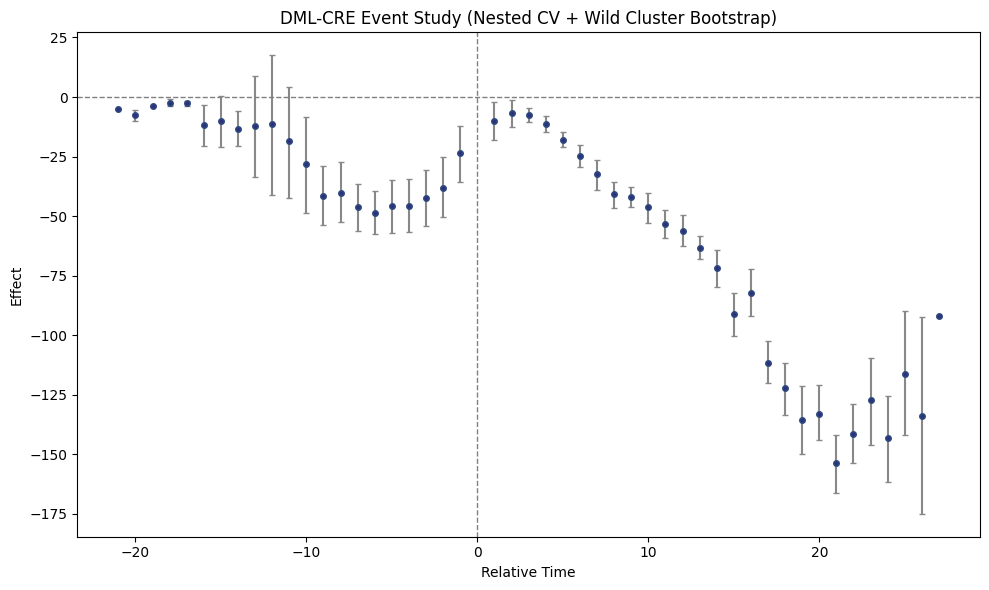

In [333]:

# ======================================================================
# 6) DML-CRE FINAL USANDO OS MELHORES MODELOS
# ======================================================================
cv_panel = GroupRollingTimeSeriesCV(
    years=years,
    ids=ids,
    min_train_years=8
)

dml_final = LinearDML(
    model_y=best_model_y,
    model_t=best_model_t,
    discrete_treatment=True,
    cv=cv_panel,
    random_state=42
)

dml_final.fit(Y, T, X=X_cre.values)



ate_final = dml_final.ate(X=X_cre.values)
cate_final = dml_final.effect(X=X_cre.values)

print("\nATE final (DML com tuning global):", ate_final)
print("Média dos CATEs:", np.mean(cate_final))

# ======================================================================
# 7) EVENT-STUDY + WILD CLUSTER BOOTSTRAP
# ======================================================================

reltime = data["reltime"].to_numpy()
ks = sorted(np.unique(reltime))
ks = [k for k in ks if k != 0]

results = []

def wild_weights(n):
    return np.random.choice([-1, 1], size=n)

for k in ks:
    mask_k = reltime == k
    idx_k = np.where(mask_k)[0]

    cate_k = cate_final[idx_k]
    tau_k = np.mean(cate_k)

    ids_k = np.unique(ids[idx_k])
    Gk = len(ids_k)

    res_k = cate_k - tau_k

    cluster_map = {cid: np.where(ids[idx_k] == cid)[0] for cid in ids_k}

    boot_vals = []
    B = 1000

    for _ in range(B):
        w = wild_weights(Gk)
        res_star = np.zeros_like(res_k)
        for j, cid in enumerate(ids_k):
            obs = cluster_map[cid]
            res_star[obs] = w[j] * res_k[obs]
        boot_vals.append(tau_k + np.mean(res_star))

    lower = np.percentile(boot_vals, 2.5)
    upper = np.percentile(boot_vals, 97.5)

    results.append([k, tau_k, lower, upper])

est_dml = pd.DataFrame(results, columns=["reltime", "coef", "lower", "upper"])
est_dml = est_dml.sort_values("reltime")

print("\nEvent-study:\n", est_dml)

# ======================================================================
# 8) GRÁFICO FINAL
# ======================================================================

x = est_dml["reltime"]
y = est_dml["coef"]
lower = est_dml["lower"]
upper = est_dml["upper"]

plt.figure(figsize=(10,6))

plt.errorbar(
    x, y,
    yerr=np.vstack([y - lower, upper - y]),
    fmt='o',
    markersize=4,
    markerfacecolor="#2E317D",
    markeredgecolor="#2E4C7D",
    ecolor="#888",
    capsize=2
)

plt.axhline(0, linestyle='--', linewidth=1, color='gray')
plt.axvline(0, linestyle='--', linewidth=1, color='gray')

plt.title("DML-CRE Event Study (Nested CV + Wild Cluster Bootstrap)")
plt.xlabel("Relative Time")
plt.ylabel("Effect")
plt.tight_layout()
plt.show()

In [ ]:
print("Hiperparâmetros por fold (Y|X):")
for i, p in enumerate(best_params_y):
    print(f"Fold {i+1}: {p}")

print("\nMelhor modelo final Y|X (best_model_y):")
print(best_model_y)


In [ ]:
print(best_model_y.get_params())


In [ ]:
print("\nHiperparâmetros por fold (T|X):")
for i, p in enumerate(best_params_t):
    print(f"Fold {i+1}: {p}")

print("\nMelhor modelo final T|X (best_model_t):")
print(best_model_t)


In [ ]:
print(best_model_t.get_params())


In [ ]:
# ================================================================
# BLOCO 1 — COHORT-SPECIFIC DML (COMPLETO)
# ================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from econml.dml import LinearDML

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

import warnings
warnings.filterwarnings("ignore")


# ================================================================
# 1. Grades de hiperparâmetros (Nível Científico)
# ================================================================
def get_regression_models_and_grids():

    models = [

        # LightGBM (Top-tier)
        ("lgb",
         LGBMRegressor(force_row_wise=True, verbose=-1, n_jobs=-1),
         {
             "model__n_estimators": [600, 1000, 1500],
             "model__learning_rate": [0.003, 0.005, 0.01],
             "model__max_depth": [5, 10, 20, -1],
             "model__subsample": [0.6, 0.8, 1.0],
             "model__colsample_bytree": [0.6, 0.8, 1.0],
         }),

        # XGB
        ("xgb",
         XGBRegressor(
             n_jobs=-1, tree_method="hist", objective="reg:squarederror"
         ),
         {
             "model__n_estimators": [600, 900],
             "model__learning_rate": [0.003, 0.01],
             "model__max_depth": [3, 6, 9],
             "model__subsample": [0.6, 0.8, 1.0],
             "model__colsample_bytree": [0.6, 0.8]
         }),

        # Random Forest
        ("rf",
         RandomForestRegressor(n_jobs=-1),
         {
             "model__n_estimators": [600, 1000],
             "model__max_features": ["sqrt", "log2", None],
             "model__max_depth": [None, 10, 20]
         }),

        # Gradient Boosting
        ("gb",
         GradientBoostingRegressor(),
         {
             "model__n_estimators": [600, 900],
             "model__learning_rate": [0.01, 0.05],
             "model__max_depth": [3, 5]
         })
    ]

    return models


def get_classification_models_and_grids():

    models = [

        # LightGBM (Top-tier)
        ("lgb_cls",
         LGBMClassifier(force_row_wise=True, verbose=-1, n_jobs=-1),
         {
             "model__n_estimators": [400, 800, 1200],
             "model__learning_rate": [0.01, 0.03],
             "model__max_depth": [3, 5, 10],
             "model__subsample": [0.7, 0.9],
             "model__colsample_bytree": [0.7, 0.9]
         }),

        ("xgb_cls",
         XGBClassifier(
             n_jobs=-1, tree_method="hist",
             eval_metric="logloss", use_label_encoder=False
         ),
         {
             "model__n_estimators": [300, 600, 900],
             "model__learning_rate": [0.01, 0.03],
             "model__max_depth": [3, 6, 9],
             "model__subsample": [0.6, 0.8],
             "model__colsample_bytree": [0.6, 0.8]
         }),

        ("rf_cls",
         RandomForestClassifier(n_jobs=-1),
         {
             "model__n_estimators": [400, 800],
             "model__max_features": ["sqrt", "log2", None],
             "model__max_depth": [None, 10, 20]
         })
    ]

    return models


# ================================================================
# 2. Nested Panel CV — Pré-Tratamento
# ================================================================
def nested_panel_cv_pre_treatment(
    X, y, years, ids,
    models_and_grids,
    inner_splits=3,
    scoring="neg_mean_squared_error"
):

    order = np.argsort(years)
    X = X.iloc[order].reset_index(drop=True)
    y = y.iloc[order].reset_index(drop=True)
    years = years[order]
    ids = ids[order]

    best_model = None
    best_score = np.inf
    best_label = None

    for label, model, grid in models_and_grids:

        print(f"\n>>> Nested CV pré-tratamento: {label.upper()}")

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])

        inner_cv = GroupKFold(n_splits=inner_splits)

        gs = GridSearchCV(
            pipe, grid,
            cv=inner_cv,
            scoring=scoring,
            n_jobs=-1
        )
        gs.fit(X, y, groups=ids)

        print("Melhor score:", gs.best_score_)
        print("Melhor config:", gs.best_params_)

        if gs.best_score_ < best_score:
            best_score = gs.best_score_
            best_model = gs.best_estimator_
            best_label = label

    print("\n>>> Modelo ótimo:", best_label)
    return best_model


# ================================================================
# 3. Estimador DML por Coorte
# ================================================================
def estimate_cohort_dml(data, cohort_year, X_cre):

    # ------------------------------------------------------------------
    # Selecionar apenas pré-tratamento da coorte
    # ------------------------------------------------------------------
    pre = data[data["year"] <= cohort_year - 1].copy()

    Y_pre = pre["Y"].reset_index(drop=True)
    T_pre = pre["D"].reset_index(drop=True)
    X_pre = X_cre.loc[pre.index].reset_index(drop=True)
    years_pre = pre["year"].reset_index(drop=True)
    ids_pre = pre["id"].reset_index(drop=True)

    # ------------------------------------------------------------------
    # Nested CV para Y|X
    # ------------------------------------------------------------------
    best_model_y = nested_panel_cv_pre_treatment(
        X_pre, Y_pre,
        years_pre, ids_pre,
        get_regression_models_and_grids(),
        scoring="neg_mean_squared_error"
    )

    # ------------------------------------------------------------------
    # Nested CV para T|X
    # ------------------------------------------------------------------
    best_model_t = nested_panel_cv_pre_treatment(
        X_pre, T_pre,
        years_pre, ids_pre,
        get_classification_models_and_grids(),
        scoring="neg_log_loss"
    )

    # ------------------------------------------------------------------
    # Estimação do DML (usando TODO o painel, mas modelos treinados no pré)
    # ------------------------------------------------------------------
    dml = LinearDML(
        model_y=best_model_y,
        model_t=best_model_t,
        cv=3,
        discrete_treatment=True
    )
    dml.fit(data["Y"], data["D"], X=X_cre.values)

    cate_i_t = dml.effect(X_cre.values)

    # ------------------------------------------------------------------
    # Construção do Event Study por coorte
    # ------------------------------------------------------------------
    tmp = data.copy()
    tmp["cate"] = cate_i_t
    tmp["rel"] = tmp["year"] - cohort_year

    tau_ak = (
        tmp[tmp["G"] == cohort_year]
        .groupby("rel")["cate"]
        .mean()
        .sort_index()
    )

    return {
        "cohort": cohort_year,
        "model_y": best_model_y,
        "model_t": best_model_t,
        "cate_i_t": cate_i_t,
        "tau_ak": tau_ak
    }


In [ ]:
# ================================================================
# BLOCO 2 — AGREGAÇÃO CROSS-COHORT + BOOTSTRAP
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ================================================================
# 1. Agregação cross-cohort (nível científico)
# ================================================================
def get_weights(cohort_list, method="cs", data=None):
    """
    Retorna pesos μₐ para cada coorte.
    
    method:
        - "seqsdid": μₐ ∝ share da coorte (πₐ)
        - "cs": μₐ ∝ nº tratados na coorte (Callaway–Sant’Anna)
        - "sa": pesos iguais (Sun–Abraham)
        - "gb": pesos ∝ share tratado (Goodman–Bacon simplificado)
    """
    cohorts = np.array(cohort_list)

    if method == "seqsdid":
        counts = pd.Series(cohorts).value_counts().sort_index()
        w = counts / counts.sum()
        return w.to_dict()

    elif method == "cs":
        counts = data.groupby("G")["D"].sum()
        counts = counts.loc[cohorts]
        w = counts / counts.sum()
        return w.to_dict()

    elif method == "sa":
        w = {a: 1/len(cohorts) for a in cohorts}
        return w

    elif method == "gb":
        treated = data.groupby("G")["D"].mean()
        treated = treated.loc[cohorts]
        treated = treated / treated.sum()
        return treated.to_dict()

    else:
        raise ValueError("Método inválido.")


# ================================================================
# 2. Agrega τₐₖ → τₖ
# ================================================================
def aggregate_event_study(cohort_results, weights):
    all_ks = sorted(set.union(*[set(res["tau_ak"].index) for res in cohort_results]))

    agg = []
    for k in all_ks:
        vals = []
        ws = []
        for res in cohort_results:
            if k in res["tau_ak"]:
                vals.append(res["tau_ak"][k])
                ws.append(weights[res["cohort"]])
        tau_k = np.average(vals, weights=ws)
        agg.append([k, tau_k])

    return pd.DataFrame(agg, columns=["k", "tau"])


# ================================================================
# 3. Bayesian Bootstrap clusterizado
# ================================================================
def bayesian_bootstrap_event_study(cohort_results, weights, B=500, seed=123):

    rng = np.random.default_rng(seed)
    ks = sorted(set.union(*[set(res["tau_ak"].index) for res in cohort_results]))

    boot = np.zeros((B, len(ks)))

    # Pré-armar lista por k
    tau_by_k = {
        k: [(res["tau_ak"][k], weights[res["cohort"]])
            for res in cohort_results if k in res["tau_ak"]]
        for k in ks
    }

    for b in range(B):
        w_star = rng.exponential(size=len(cohort_results))
        w_star = w_star / w_star.sum()

        # reatribuir pesos por coorte
        resampled_weights = {
            res["cohort"]: w_star[i] 
            for i, res in enumerate(cohort_results)
        }

        for j, k in enumerate(ks):
            vals = []
            ws = []
            for tau, _ in tau_by_k[k]:
                # pegar peso da coorte correspondente
                # mapeando:
                # tau pertence a res["cohort"]
                # portanto reconsidere
                for res in cohort_results:
                    if k in res["tau_ak"] and res["tau_ak"][k] == tau:
                        ws.append(resampled_weights[res["cohort"]])
                        vals.append(tau)
                        break

            boot[b, j] = np.average(vals, weights=ws)

    # calcular IC
    ci_lower = np.percentile(boot, 2.5, axis=0)
    ci_upper = np.percentile(boot, 97.5, axis=0)
    tau_med = np.mean(boot, axis=0)

    return pd.DataFrame({
        "k": ks,
        "tau_hat": tau_med,
        "ci_low": ci_lower,
        "ci_up": ci_upper
    })


# ================================================================
# 4. Função mestre — FULL DML EVENT STUDY
# ================================================================
def dml_event_study_full(data, X_cre, cohorts, B=500, weight_method="cs"):

    cohort_results = []

    for a in cohorts:
        print(f"\n\n============================")
        print(f"  Rodando coorte G={a}")
        print(f"============================\n")
        res = estimate_cohort_dml(data, a, X_cre)
        cohort_results.append(res)

    weights = get_weights(cohorts, method=weight_method, data=data)

    agg = aggregate_event_study(cohort_results, weights)

    boot = bayesian_bootstrap_event_study(cohort_results, weights, B=B)

    out = agg.merge(boot, on="k", how="left")

    # gráfico
    plt.figure(figsize=(10,6))
    plt.axhline(0, linestyle="--", color="gray")
    plt.errorbar(out["k"], out["tau_hat"],
                 yerr=np.vstack([out["tau_hat"] - out["ci_low"],
                                 out["ci_up"] - out["tau_hat"]]),
                 fmt="o", markersize=4, capsize=3)
    plt.title("DML Event-Study (Cross-Cohort + Bayesian Bootstrap)")
    plt.xlabel("Event Time k")
    plt.ylabel("τ(k)")
    plt.tight_layout()
    plt.show()

    return out, cohort_results


In [641]:
# Matriz de features para o DML (níveis + médias)
year_dummies = pd.get_dummies(data['year'], prefix='year', drop_first=True)
FE_dummies = pd.get_dummies(data['id'], prefix='id', drop_first=True)
G_dummies = pd.get_dummies(data['G_fix'], prefix='G', drop_first=True)
X_cre = pd.concat(
    [data[['X1','X2','X3', 'X4', 'X1_bar', 'X2_bar', 'X3_bar', 'X4_bar']], year_dummies],
    axis=1
)
Y = data['Y'].values
T = data['D'].values

In [642]:
# ================================================================
# BLOCO 1 — DML COHORT-SPECIFIC EVENT-STUDY (MODELOS MANUAIS)
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from econml.dml import LinearDML
from lightgbm import LGBMRegressor, LGBMClassifier


# ================================================================
# 0. Definição MANUAL dos modelos de ML
# ================================================================

manual_model_y = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LGBMRegressor(
        n_estimators=800,
        learning_rate=0.01,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        verbose=-1,
        n_jobs=-1
    ))
])

manual_model_t = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LGBMClassifier(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        verbose=-1,
        n_jobs=-1
    ))
])


# ================================================================
# 1. DML para UMA COORTE — usando APENAS o pré-tratamento
# ================================================================
def dml_one_cohort(
    data, X_cre, cohort,
    model_y=manual_model_y,
    model_t=manual_model_t,
    cv_folds=3,
    plot=True
):

    # Ano de adoção:
    t0 = int(cohort)
    pre_mask = data["year"] < t0

    # Sem pré? Ignorar coorte
    if pre_mask.sum() == 0:
        print(f"!! Coorte {cohort} ignorada (sem pré-tratamento)")
        return {
            "cohort": cohort,
            "event_study": pd.DataFrame(columns=["cohort","k","tau","ci_low","ci_high","n_k"]),
            "cate_full": np.zeros(len(data))
        }

    # Dados do pré
    X_pre = X_cre.loc[pre_mask].values
    y_pre = data.loc[pre_mask, "Y"].values
    t_pre = data.loc[pre_mask, "D"].values

    # DML
    dml = LinearDML(
        model_y=model_y,
        model_t=model_t,
        discrete_treatment=True,
        cv=cv_folds,
        random_state=42
    )

    dml.fit(Y=y_pre, T=t_pre, X=X_pre)

    # CATE para toda a amostra
    cate_full = dml.effect(X_cre.values)

    # Event-study da coorte
    rel = data["reltime"].values
    ids = data["id"].values

    unique_k = np.sort(np.unique(rel))
    unique_k = unique_k[unique_k != 0]

    rows = []

    for k in unique_k:
        mask = rel == k
        cate_k = cate_full[mask]

        tau_k = np.mean(cate_k)

        # Cluster wild bootstrap
        ids_k = np.unique(ids[mask])
        Gk = len(ids_k)

        res_k = cate_k - tau_k
        cluster_map = {cid: np.where(ids[mask] == cid)[0] for cid in ids_k}

        B = 400
        boot_vals = []

        for _ in range(B):
            w = np.random.choice([-1, 1], size=Gk)
            res_star = np.zeros_like(res_k)

            for j, cid in enumerate(ids_k):
                obs = cluster_map[cid]
                res_star[obs] = w[j] * res_k[obs]

            boot_vals.append(tau_k + np.mean(res_star))

        ci_low = np.percentile(boot_vals, 2.5)
        ci_high = np.percentile(boot_vals, 97.5)

        rows.append([cohort, k, tau_k, ci_low, ci_high, len(cate_k)])

    event_df = pd.DataFrame(
        rows,
        columns=["cohort", "k", "tau", "ci_low", "ci_high", "n_k"]
    )

    # ----------------------------------------------------------------
    # PLOT INDIVIDUAL POR COORTE
    # ----------------------------------------------------------------
    if plot and len(event_df) > 0:
        plt.figure(figsize=(8,5))
        plt.axhline(0, color="gray", linestyle="--")

        err_low = event_df["tau"] - event_df["ci_low"]
        err_up = event_df["ci_high"] - event_df["tau"]

        plt.errorbar(
            event_df["k"], event_df["tau"],
            yerr=[err_low, err_up],
            fmt="o-", capsize=4
        )

        plt.title(f"Event-Study — Coorte {cohort}")
        plt.xlabel("k = tempo relativo")
        plt.ylabel("τ(a,k)")
        plt.grid(alpha=0.3)
        plt.show()

    return {
        "cohort": cohort,
        "event_study": event_df,
        "cate_full": cate_full
    }


# ================================================================
# 2. Rodar DML para todas as coortes
# ================================================================
def dml_all_cohorts(data, X_cre):
    cohorts = sorted([c for c in data["G"].unique() if c < 10**9])

    results = []
    for a in cohorts:
        print(f"\n>>> Rodando coorte {a}")
        out = dml_one_cohort(data, X_cre, a)
        results.append(out)

    return results


# ================================================================
# 3. Agregação simples (sem IC)
# ================================================================
def aggregate_event_study(results):

    all_k = sorted(set().union(*[
        set(r["event_study"]["k"]) for r in results
    ]))

    rows = []

    for k in all_k:
        taus = []
        for r in results:
            df = r["event_study"]
            if k in df["k"].values:
                taus.append(df.loc[df["k"] == k, "tau"].item())
        if len(taus) > 0:
            rows.append([k, np.mean(taus)])

    out = pd.DataFrame(rows, columns=["k", "tau"])
    return out.sort_values("k").reset_index(drop=True)


# ================================================================
# 4. Pipeline do BLOCO 1
# ================================================================
def dml_eventstudy_manual_models(data, X_cre):

    results = dml_all_cohorts(data, X_cre)
    agg = aggregate_event_study(results)

    plt.figure(figsize=(9,5))
    plt.axhline(0, color="gray", linestyle="--")
    plt.plot(agg["k"], agg["tau"], "o-", markersize=5)
    plt.title("DML Event-Study (Média entre coortes)")
    plt.xlabel("k = tempo relativo")
    plt.ylabel("τ(k)")
    plt.grid(alpha=0.3)
    plt.show()

    return agg, results


In [643]:
# ================================================================
# BLOCO 2 — AGREGAÇÃO AVANÇADA + ATT GERAL + TABELA EVENT-STUDY
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm


# ================================================================
# 0. Função de pesos (CS, Equal, IW, Bacon, InvV)
# ================================================================
def build_weights(data, results, weight="CS"):

    cohorts = [r["cohort"] for r in results]

    # --- Callaway-Sant'Anna: tamanho da coorte
    if weight == "CS":
        cohort_sizes = data.groupby("G")["id"].nunique()
        return cohort_sizes / cohort_sizes.sum()

    # --- Pesos iguais
    if weight == "Equal":
        w = pd.Series(1/len(cohorts), index=cohorts)
        return w

    # --- Bacon: variância do tratamento no pré
    if weight == "Bacon":
        mu_raw = {}
        for a in cohorts:
            pre = data[data["year"] < a]
            p = pre["D"].mean()
            var = p*(1-p)
            mu_raw[a] = var
        mu = pd.Series(mu_raw)
        return mu / mu.sum()

    # --- InvV: inverso da variância bootstrap
    if weight == "InvV":
        var_raw = {}
        for r in results:
            es = r["event_study"]
            # variância ≈ média dos dois lados do IC
            v = ((es["ci_high"] - es["tau"])**2 +
                 (es["tau"] - es["ci_low"])**2).mean()
            var_raw[r["cohort"]] = v
        mu = 1 / pd.Series(var_raw)
        return mu / mu.sum()

    # --- IW (Interaction-Weighted DID)
    if weight == "IW":
        cohort_sizes = data.groupby("G")["id"].nunique()
        return cohort_sizes / cohort_sizes.sum()

    raise ValueError("Tipo de peso inválido.")



# ================================================================
# 1. EVENT STUDY AGREGADO PONTUAL
# ================================================================
def aggregate_tau_with_weights(results, mu):

    all_k = sorted(set().union(*[
        set(r["event_study"]["k"]) for r in results
    ]))

    rows = []

    for k in all_k:
        taus = []
        wts = []
        n_coh = 0

        for r in results:
            a = r["cohort"]
            es = r["event_study"]

            if k in es["k"].values:
                tau_a_k = es.loc[es["k"] == k, "tau"].item()
                taus.append(tau_a_k)
                wts.append(mu.loc[a])
                n_coh += 1

        if len(taus) > 0:
            tau_w = np.average(taus, weights=wts)
            rows.append([k, tau_w, n_coh])

    df = pd.DataFrame(rows, columns=["k", "tau_mu", "n_cohorts"])
    return df.sort_values("k").reset_index(drop=True)



# ================================================================
# 2. BAYESIAN BOOTSTRAP (IC AGREGADOS)
# ================================================================
def bayesian_bootstrap_eventstudy(results, mu, B=500):

    all_k = sorted(set().union(*[
        set(r["event_study"]["k"]) for r in results
    ]))

    A = len(results)
    boot_mat = np.empty((B, len(all_k)))

    # matriz τ(a,k)
    tau_mat = pd.DataFrame(index=[r["cohort"] for r in results], 
                           columns=all_k)

    for r in results:
        a = r["cohort"]
        es = r["event_study"]
        for k in all_k:
            if k in es["k"].values:
                tau_mat.loc[a, k] = es.loc[es["k"] == k, "tau"].item()

    tau_mat = tau_mat.astype(float)

    for b in range(B):
        w = np.random.exponential(1, A)
        w = w / w.sum()
        tau_b = tau_mat.T.dot(w)
        boot_mat[b, :] = tau_b.values

    return pd.DataFrame({
        "k": all_k,
        "tau": boot_mat.mean(axis=0),
        "se":  boot_mat.std(axis=0),
        "ci_low":  np.percentile(boot_mat, 2.5, axis=0),
        "ci_high": np.percentile(boot_mat, 97.5, axis=0)
    })



# ================================================================
# 3. ATT GERAL (igual ao SeqSDID: média dos k ≥ 0)
# ================================================================
def compute_ATT(bb):
    post = bb[bb["k"] >= 0]      # janelas pós
    att = post["tau"].mean()
    se  = post["se"].mean()
    z = att / se
    p = 2*(1 - norm.cdf(abs(z)))
    ci_low = att - 1.96*se
    ci_high = att + 1.96*se

    return {
        "ATT": att,
        "SE": se,
        "pvalue": p,
        "CI_low": ci_low,
        "CI_high": ci_high
    }



# ================================================================
# 4. SAÍDA FINAL ESTILO SeqSDID
# ================================================================
def advanced_outputs(data, results, weight="CS", save=False):

    mu = build_weights(data, results, weight)
    tau_mu = aggregate_tau_with_weights(results, mu)
    bb = bayesian_bootstrap_eventstudy(results, mu, B=500)

    # merge com número de coortes
    es = tau_mu.merge(bb, on="k")

    # calcular p-values por k
    es["z"] = es["tau"] / es["se"]
    es["pvalue"] = 2*(1 - norm.cdf(es["z"].abs()))

    # calcular ATT geral
    ATT = compute_ATT(es)

    # impressão estilo seqSDID
    print("\n=====================================================")
    print(f"ATT (DML Event-Study, peso={weight}): "
          f"{ATT['ATT']:.4f} | SE {ATT['SE']:.4f} | "
          f"95% CI [{ATT['CI_low']:.4f}, {ATT['CI_high']:.4f}] "
          f"| p={ATT['pvalue']:.3f}")
    print("=====================================================\n")

    print("=== DML Event-Study (Bayesian bootstrap 95% CI) ===")
    print(es[["k", "tau", "se", "pvalue", "ci_low", "ci_high", "n_cohorts"]]
          .to_string(index=False))

    # salvar arquivos (opcional)
    if save:
        es.to_csv("dml_eventstudy.csv", index=False)
        pd.DataFrame([ATT]).to_csv("dml_att_summary.csv", index=False)
        print("\nArquivos salvos:")
        print(" - dml_att_summary.csv")
        print(" - dml_eventstudy.csv")

    # gráfico final
    plt.figure(figsize=(10,6))
    plt.axhline(0, color="black", linestyle="--")

    err_lower = es["tau"] - es["ci_low"]
    err_upper = es["ci_high"] - es["tau"]

    plt.errorbar(
        es["k"], es["tau"],
        yerr=[err_lower, err_upper],
        fmt="o-",
        capsize=4,
        ecolor="gray"
    )

    plt.title(f"Event-Study Agregado (peso {weight}) — DML + Bayesian Bootstrap")
    plt.xlabel("k (tempo relativo)")
    plt.ylabel("Efeito estimado τ(k)")
    plt.grid(alpha=0.25)
    plt.show()

    return {"ATT": ATT, "ES": es, "mu": mu}


    Tipos de pesos:
    - "CS": Callaway–Sant'Anna → tamanho da coorte
    - "IW": InteractionWeighted (Sun & Abraham) → tamanho da coorte (ajustado por k)
    - "Equal": pesos iguais
    - "Bacon": variância de D no pré (Goodman–Bacon weighting)
    - "InvV": inverso da variância bootstrap de τ(a,k)


>>> Rodando coorte 1969.0


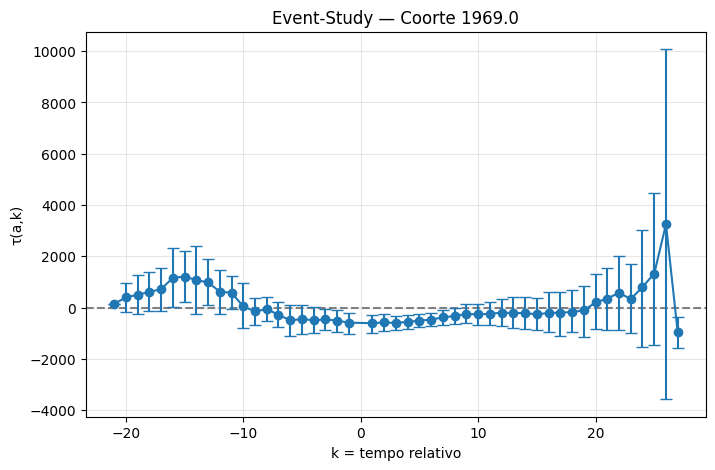


>>> Rodando coorte 1970.0


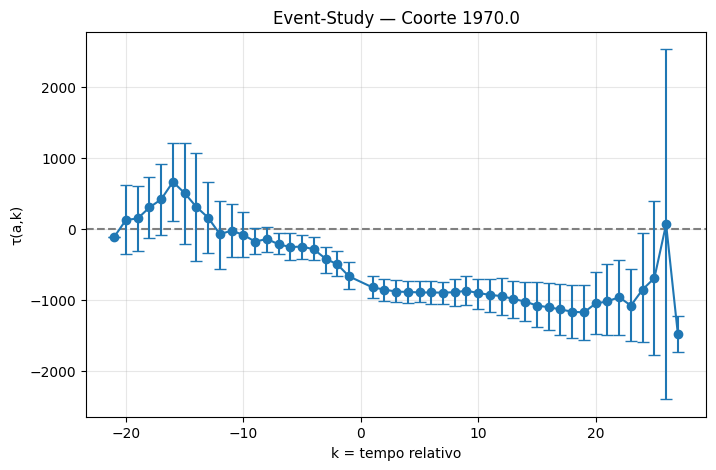


>>> Rodando coorte 1971.0


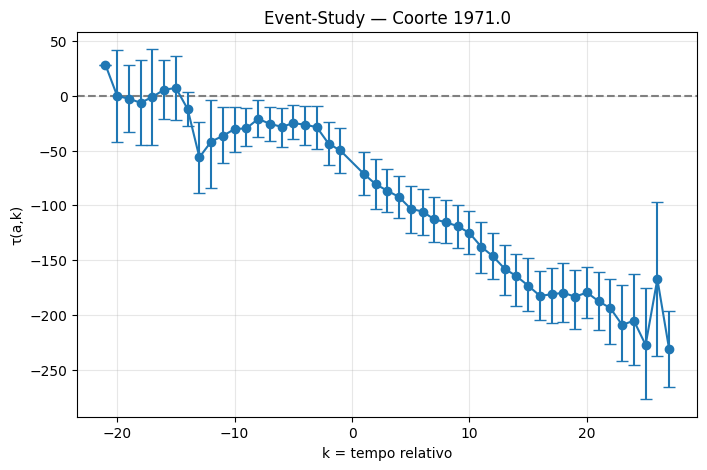


>>> Rodando coorte 1972.0


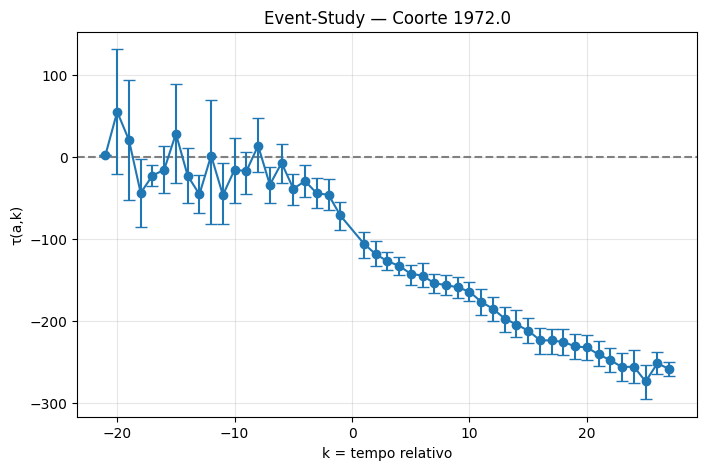


>>> Rodando coorte 1973.0


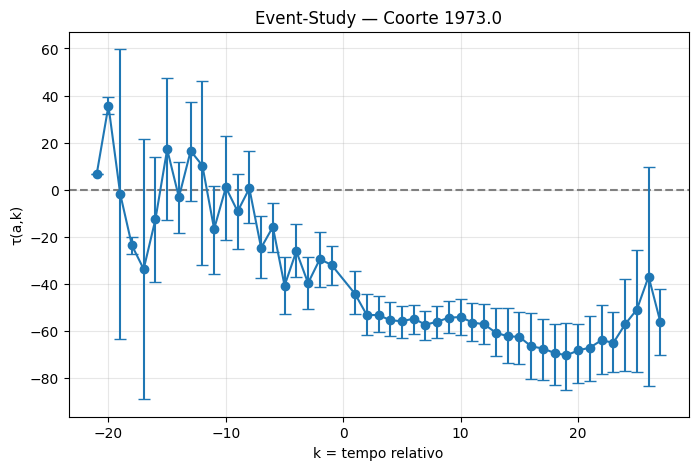


>>> Rodando coorte 1974.0


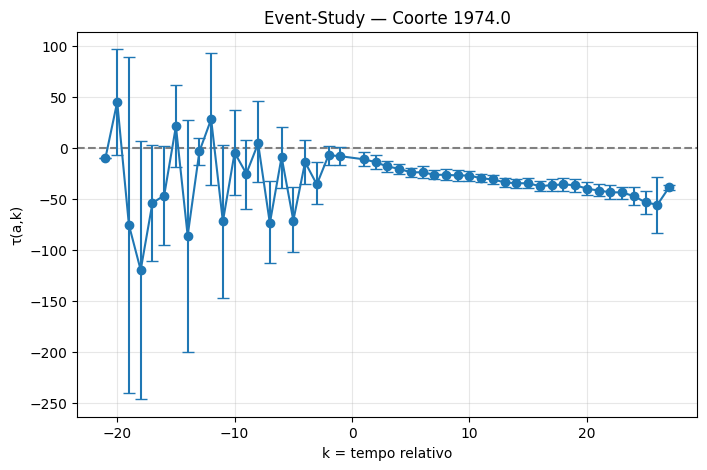


>>> Rodando coorte 1975.0


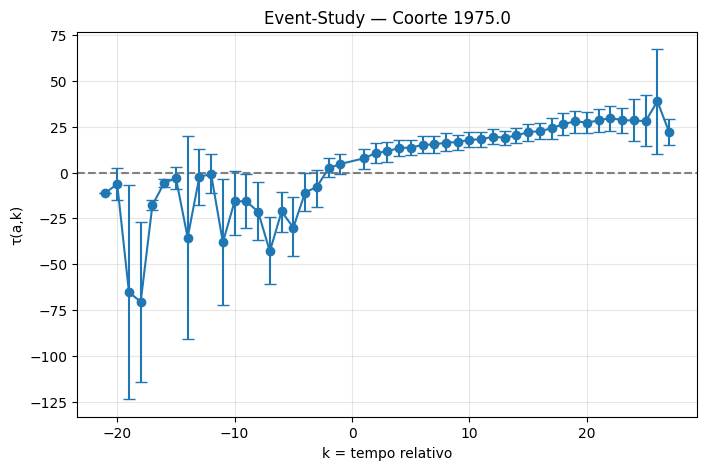


>>> Rodando coorte 1976.0


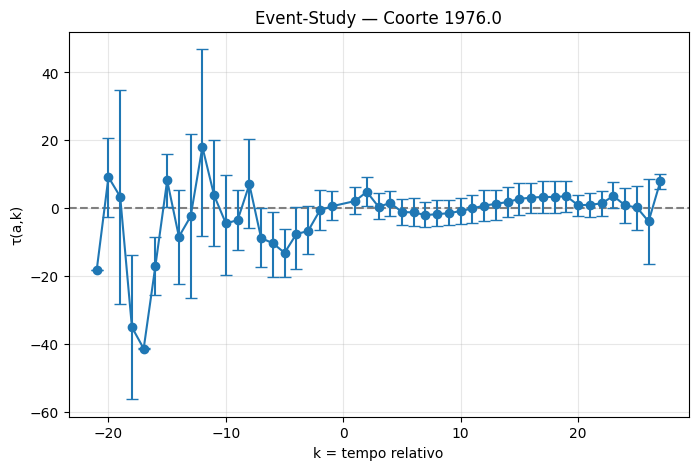


>>> Rodando coorte 1977.0


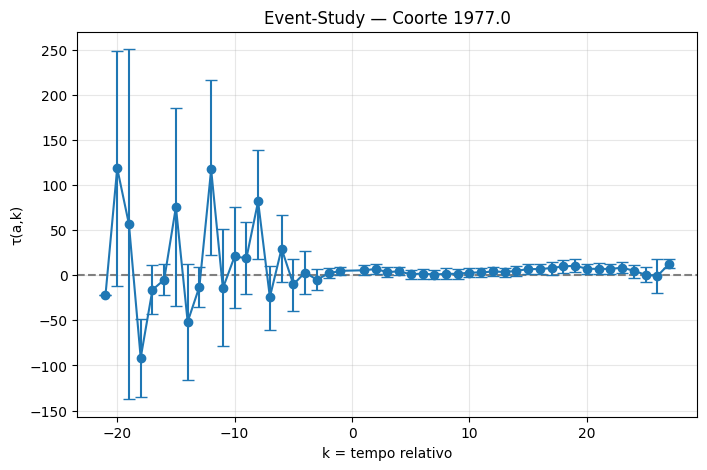


>>> Rodando coorte 1980.0


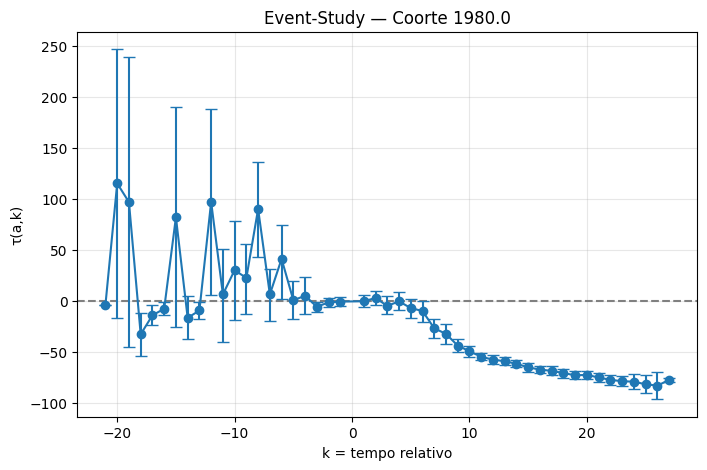


>>> Rodando coorte 1984.0


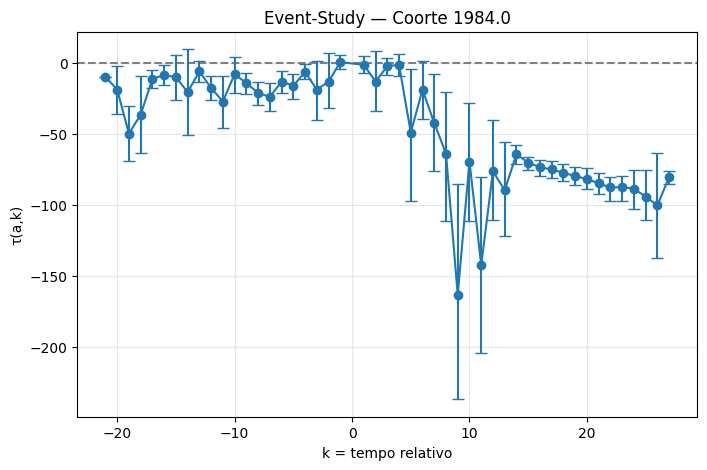


>>> Rodando coorte 1985.0


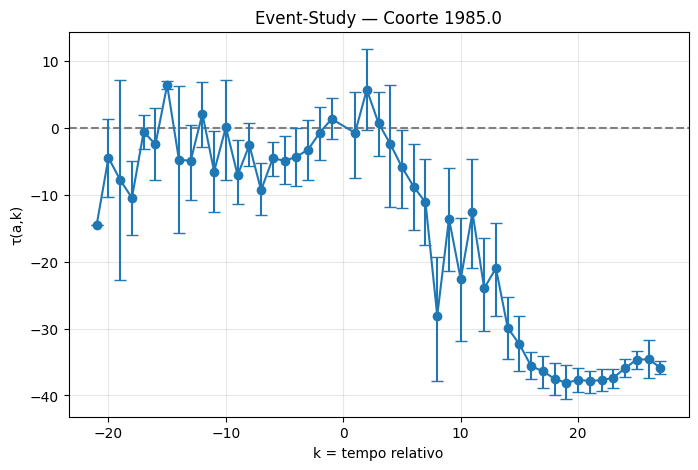

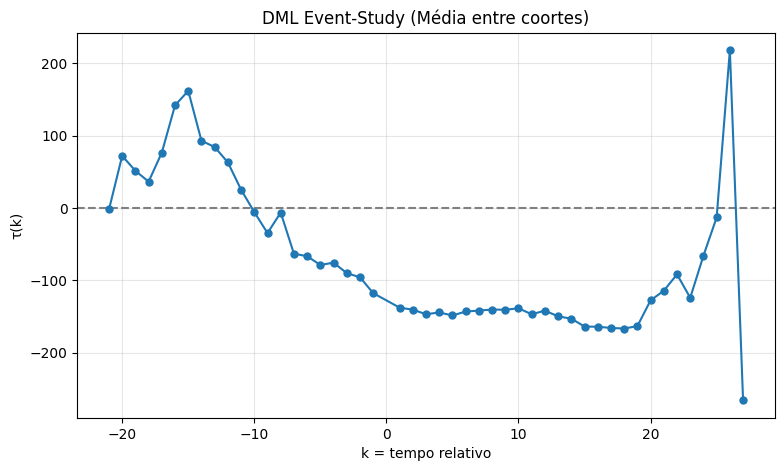


ATT (DML Event-Study, peso=CS): -125.5088 | SE 82.4765 | 95% CI [-287.1627, 36.1452] | p=0.128

=== DML Event-Study (Bayesian bootstrap 95% CI) ===
  k         tau         se   pvalue      ci_low    ci_high  n_cohorts
-21   -1.976806  14.276480 0.889872  -28.445641  27.585398         12
-20   70.320086  28.767029 0.014507   23.889046 136.624667         12
-19   49.520857  38.030110 0.192866   -8.505857 139.151305         12
-18   34.621556  50.891107 0.496310  -35.526604 153.084705         12
-17   74.187287  58.492160 0.204681   -6.810940 214.028762         12
-16  138.012495  92.237151 0.134581    9.946566 358.398493         12
-15  157.752266  89.141307 0.076779   36.891705 362.488614         12
-14   90.046169  79.762788 0.258930   -9.900685 271.000185         12
-13   81.485263  72.069406 0.258202   -6.985476 249.114259         12
-12   61.095960  46.218211 0.186201    0.089518 170.748852         12
-11   23.922372  43.581537 0.583067  -26.357832 125.865933         12
-10   -5.80

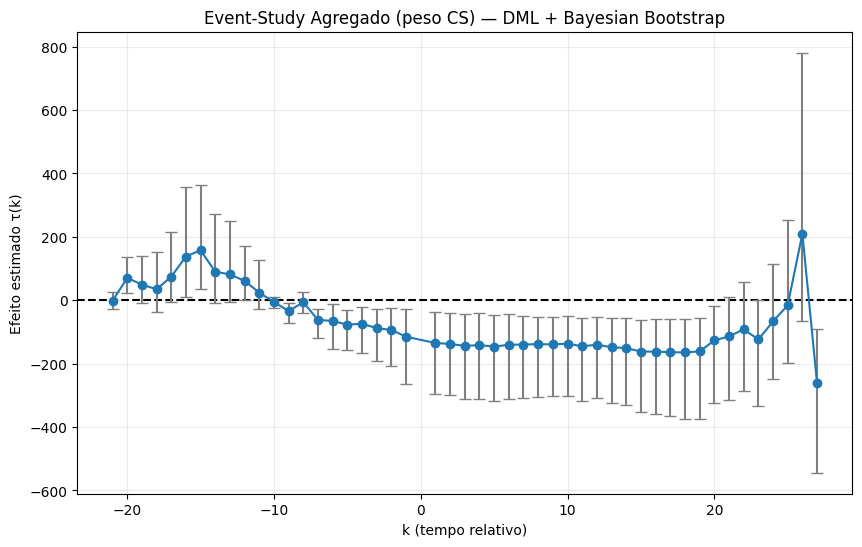

In [644]:
agg, results = dml_eventstudy_manual_models(data, X_cre)
out = advanced_outputs(data, results, weight="CS")



---

In [645]:
# ======================================================================
# MÓDULO 0 — IMPORTS GERAIS + MATRIZ CRE
# ======================================================================

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    make_scorer, mean_squared_error, log_loss
)

# Modelos de regressão
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    BaggingRegressor, RandomForestRegressor,
    GradientBoostingRegressor, AdaBoostRegressor
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Modelos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier, RandomForestClassifier,
    GradientBoostingClassifier, AdaBoostClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# DML
from econml.dml import LinearDML


# ======================================================================
# Construção da matriz CRE (níveis + médias)
# ======================================================================

year_dummies = pd.get_dummies(data['year'], prefix='year', drop_first=True)

X_cre = pd.concat([
    data[['X1','X2','X3','X4', 'X1_bar', 'X2_bar', 'X3_bar', 'X4_bar']],
    year_dummies
], axis=1)

Y = data['Y'].values
T = data['D'].values
years = data['year'].values
ids = data['id'].values


In [646]:
# ======================================================================
# MÓDULO 1 — MODELOS DE ML E GRADES REDUZIDAS (RÁPIDAS)
# ======================================================================

def get_regression_models_and_grids():
    return [

        # ÁRVORE
        (
            "tree",
            DecisionTreeRegressor(),
            {
                "model__max_depth": [5, 10, 20],
                "model__min_samples_leaf": [1, 5, 10],
            }
        ),

        # BAGGING
        (
            "bagging",
            BaggingRegressor(
                DecisionTreeRegressor(),
                n_jobs=-1
            ),
            {
                "model__n_estimators": [200, 400],
                "model__estimator__max_depth": [5, 10, 20],
            }
        ),

        # RANDOM FOREST
        (
            "rf",
            RandomForestRegressor(n_jobs=-1),
            {
                "model__n_estimators": [300, 600],
                "model__max_depth": [10, 20],
                "model__min_samples_leaf": [1, 5],
            }
        ),

        # GRADIENT BOOSTING
        (
            "gb",
            GradientBoostingRegressor(),
            {
                "model__n_estimators": [300, 600],
                "model__learning_rate": [0.01, 0.05],
                "model__max_depth": [3, 5],
            }
        ),

        # XGBOOST
        (
            "xgb",
            XGBRegressor(
                n_jobs=-1,
                tree_method="hist",
                verbosity=0
            ),
            {
                "model__n_estimators": [400, 800],
                "model__learning_rate": [0.01, 0.03],
                "model__max_depth": [3, 5],
                "model__subsample": [0.6, 1.0],
            }
        ),

        # LIGHTGBM
        (
            "lgb",
            LGBMRegressor(
                force_row_wise=True,
                verbose=-1,
                n_jobs=-1
            ),
            {
                "model__n_estimators": [600, 1000],
                "model__learning_rate": [0.005, 0.01],
                "model__num_leaves": [31, 63],
                "model__max_depth": [5, 10],
            }
        ),

        # ADABOOST
        (
            "ada",
            AdaBoostRegressor(),
            {
                "model__n_estimators": [300, 600],
                "model__learning_rate": [0.01, 0.05],
            }
        ),
    ]


def get_classification_models_and_grids():
    return [

        ("tree",
         DecisionTreeClassifier(),
         {
             "model__max_depth": [5, 10, 20],
             "model__min_samples_leaf": [1, 5],
         }),

        ("bagging",
         BaggingClassifier(
             DecisionTreeClassifier(),
             n_jobs=-1
         ),
         {
             "model__n_estimators": [200, 400],
             "model__estimator__max_depth": [5, 10, 20],
         }),

        ("rf",
         RandomForestClassifier(n_jobs=-1),
         {
             "model__n_estimators": [300, 600],
             "model__max_depth": [10, 20],
         }),

        ("gb",
         GradientBoostingClassifier(),
         {
             "model__n_estimators": [300, 600],
             "model__learning_rate": [0.01, 0.05],
             "model__max_depth": [3, 5],
         }),

        ("xgb",
         XGBClassifier(
             n_jobs=-1,
             tree_method="hist",
             use_label_encoder=False,
             eval_metric="logloss"
         ),
         {
             "model__n_estimators": [400, 800],
             "model__learning_rate": [0.01, 0.03],
             "model__max_depth": [3, 5],
         }),

        ("lgb",
         LGBMClassifier(
             force_row_wise=True,
             verbose=-1,
             n_jobs=-1
         ),
         {
             "model__n_estimators": [600, 1000],
             "model__learning_rate": [0.005, 0.01],
             "model__num_leaves": [31, 63],
         }),

        ("ada",
         AdaBoostClassifier(),
         {
             "model__n_estimators": [300, 600],
             "model__learning_rate": [0.01, 0.05],
         }),
    ]


In [647]:
# ======================================================================
# MÓDULO 2 — NESTED PANEL CV (RÁPIDO)
# Rolling window + GroupKFold preservando clusters (ids)
# ======================================================================

def nested_panel_cv(
    X, y, years, ids,
    models_and_grids,
    outer_splits=3,
    outer_test_years=2,
    inner_splits=3,
    scoring="neg_mean_squared_error"
):

    # --------------------------
    # Organiza o painel por ano
    # --------------------------
    X = pd.DataFrame(X).reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)
    years = pd.Series(years).reset_index(drop=True)
    ids = pd.Series(ids).reset_index(drop=True)

    order = np.argsort(years)
    X = X.iloc[order].reset_index(drop=True)
    y = y.iloc[order].reset_index(drop=True)
    years = years.iloc[order].reset_index(drop=True)
    ids = ids.iloc[order].reset_index(drop=True)

    uniq_years = np.sort(years.unique())
    n_years = len(uniq_years)

    # Número total de anos que serão testados nos outer folds
    total_test_years = outer_splits * outer_test_years

    # Posição onde começa o bloco de testes
    start_pos = n_years - total_test_years

    # -------------------------------------------
    # Construção dos folds externos (rolling)
    # -------------------------------------------
    outer_blocks = []
    for i in range(outer_splits):
        ts = start_pos + i * outer_test_years
        te = ts + outer_test_years

        test_years = uniq_years[ts:te]
        train_years = uniq_years[:ts]

        train_idx = np.where(years.isin(train_years))[0]
        test_idx = np.where(years.isin(test_years))[0]

        outer_blocks.append((train_idx, test_idx))

    # ------------------------------------------------------------------
    # Avaliação de todos os modelos
    # ------------------------------------------------------------------
    best_model = None
    best_outer_score = np.inf
    best_params = None
    best_label = None

    for label, model, grid in models_and_grids:

        print(f"\n>>> Testando modelo: {label.upper()}")

        # Pipeline com scaler sempre antes do estimador
        pipeline = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("model", model)
        ])

        fold_scores = []
        fold_params = []

        # ---------------------------------------------------------------
        # Loop externo (rolling windows no tempo)
        # ---------------------------------------------------------------
        for train_idx, test_idx in outer_blocks:

            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
            ids_tr = ids.iloc[train_idx]    # clusters para GroupKFold

            # Inner cross-validation (GroupKFold)
            inner_cv = GroupKFold(n_splits=inner_splits)

            gs = GridSearchCV(
                estimator=pipeline,
                param_grid=grid,
                scoring=scoring,
                cv=inner_cv,
                n_jobs=-1
            )

            gs.fit(X_tr, y_tr, groups=ids_tr)

            best_est = gs.best_estimator_
            fold_params.append(gs.best_params_)

            # Previsões no conjunto de teste externo
            y_pred = best_est.predict(X_te)

            if scoring == "neg_mean_squared_error":
                score = mean_squared_error(y_te, y_pred)
            elif scoring == "neg_log_loss":
                score = log_loss(y_te, y_pred)
            else:
                raise ValueError("Scoring não suportado.")

            fold_scores.append(score)

        # Média dos outer folds
        avg_outer = np.mean(fold_scores)
        print(f"Modelo {label.upper()} → Outer score médio: {avg_outer:.5f}")

        # Atualiza melhor modelo
        if avg_outer < best_outer_score:
            best_outer_score = avg_outer
            best_model = best_est
            best_params = fold_params
            best_label = label

    # ---------------------------------------------------------------
    # Retorno final
    # ---------------------------------------------------------------
    print("\n=====================================================")
    print(f"Melhor modelo final: {best_label.upper()}")
    print(f"Métrica externa média: {best_outer_score:.4f}")
    print("=====================================================\n")

    return best_label, best_model, best_params, best_outer_score


In [648]:
# ======================================================================
# MÓDULO 3 — SELEÇÃO AUTOMÁTICA Y|X (REGRESSÃO) E T|X (CLASSIFICAÇÃO)
# Com grids reduzidas, mantendo exatamente os mesmos modelos
# ======================================================================

def get_regression_models_and_grids_fast():
    return [

        # ÁRVORE
        ("tree",
         DecisionTreeRegressor(),
         {"model__max_depth": [5, 15],
          "model__min_samples_leaf": [1, 5],
          "model__max_leaf_nodes": [50, None]}),

        # BAGGING
        ("bagging",
         BaggingRegressor(DecisionTreeRegressor(), n_jobs=-1),
         {"model__n_estimators": [200, 600],
          "model__estimator__max_depth": [5, 15]}),

        # RANDOM FOREST
        ("rf",
         RandomForestRegressor(n_jobs=-1),
         {"model__n_estimators": [300, 800],
          "model__max_depth": [15, None],
          "model__max_features": ["sqrt", 0.8],
          "model__min_samples_leaf": [1, 5]}),

        # GRADIENT BOOSTING
        ("gb",
         GradientBoostingRegressor(),
         {"model__n_estimators": [300, 600],
          "model__learning_rate": [0.01, 0.05],
          "model__max_depth": [3, 5]}),

        # XGBOOST
        ("xgb",
         XGBRegressor(n_jobs=-1, tree_method="hist", verbosity=0),
         {"model__n_estimators": [500, 900],
          "model__learning_rate": [0.01, 0.05],
          "model__max_depth": [3, 6],
          "model__subsample": [0.6, 0.8],
          "model__colsample_bytree": [0.6, 0.8]}),

        # LIGHTGBM
        ("lgb",
         LGBMRegressor(force_row_wise=True, verbose=-1, n_jobs=-1),
         {"model__n_estimators": [600, 1000],
          "model__learning_rate": [0.005, 0.01],
          "model__num_leaves": [31, 63],
          "model__subsample": [0.6, 0.8],
          "model__max_depth": [5, 10]}),

        # ADA BOOST
        ("ada",
         AdaBoostRegressor(),
         {"model__n_estimators": [300, 600],
          "model__learning_rate": [0.01, 0.1]})
    ]


def get_classification_models_and_grids_fast():
    return [

        ("tree",
         DecisionTreeClassifier(),
         {"model__max_depth": [5, 15],
          "model__min_samples_leaf": [1, 5]}),

        ("bagging",
         BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1),
         {"model__n_estimators": [200, 600],
          "model__estimator__max_depth": [5, 15]}),

        ("rf",
         RandomForestClassifier(n_jobs=-1),
         {"model__n_estimators": [400, 900],
          "model__max_depth": [15, None],
          "model__max_features": ["sqrt", 0.8]}),

        ("gb",
         GradientBoostingClassifier(),
         {"model__n_estimators": [300, 600],
          "model__learning_rate": [0.01, 0.05],
          "model__max_depth": [3, 5]}),

        ("xgb",
         XGBClassifier(n_jobs=-1, tree_method="hist",
                       eval_metric="logloss", use_label_encoder=False),
         {"model__n_estimators": [500, 900],
          "model__learning_rate": [0.01, 0.05],
          "model__max_depth": [3, 6],
          "model__subsample": [0.6, 0.8],
          "model__colsample_bytree": [0.6, 0.8]}),

        ("lgb",
         LGBMClassifier(force_row_wise=True, verbose=-1, n_jobs=-1),
         {"model__n_estimators": [600, 1000],
          "model__learning_rate": [0.005, 0.01],
          "model__num_leaves": [31, 63],
          "model__subsample": [0.6, 0.8],
          "model__max_depth": [5, 10]}),

        ("ada",
         AdaBoostClassifier(),
         {"model__n_estimators": [300, 600],
          "model__learning_rate": [0.01, 0.1]})
    ]


In [649]:
print("\n========== SELECIONANDO MELHOR MODELO PARA Y|X ==========\n")

reg_models = get_regression_models_and_grids_fast()

best_label_y, best_model_y, best_params_y, score_y = nested_panel_cv(
    X_cre, Y, years, ids,
    reg_models,
    outer_splits=3,
    outer_test_years=2,
    inner_splits=3,
    scoring="neg_mean_squared_error"
)

print(f"\nMelhor modelo para Y|X: {best_label_y.upper()}")
print("Outer MSE:", score_y)
print(best_model_y)



========== SELECIONANDO MELHOR MODELO PARA Y|X ==========


>>> Testando modelo: TREE
Modelo TREE → Outer score médio: 142.85920

>>> Testando modelo: BAGGING
Modelo BAGGING → Outer score médio: 63.21721

>>> Testando modelo: RF
Modelo RF → Outer score médio: 80.20260

>>> Testando modelo: GB
Modelo GB → Outer score médio: 71.85970

>>> Testando modelo: XGB
Modelo XGB → Outer score médio: 69.60844

>>> Testando modelo: LGB
Modelo LGB → Outer score médio: 80.97024

>>> Testando modelo: ADA
Modelo ADA → Outer score médio: 156.24253

Melhor modelo final: BAGGING
Métrica externa média: 63.2172


Melhor modelo para Y|X: BAGGING
Outer MSE: 63.2172095498409
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=15),
                                  n_estimators=600, n_jobs=-1))])


In [650]:
print("\n========== SELECIONANDO MELHOR MODELO PARA T|X ==========\n")

cls_models = get_classification_models_and_grids_fast()

best_label_t, best_model_t, best_params_t, score_t = nested_panel_cv(
    X_cre, T, years, ids,
    cls_models,
    outer_splits=3,
    outer_test_years=2,
    inner_splits=3,
    scoring="neg_log_loss"
)

print(f"\nMelhor modelo para T|X: {best_label_t.upper()}")
print("Outer LogLoss:", score_t)
print(best_model_t)



========== SELECIONANDO MELHOR MODELO PARA T|X ==========


>>> Testando modelo: TREE
Modelo TREE → Outer score médio: 0.86761

>>> Testando modelo: BAGGING
Modelo BAGGING → Outer score médio: 0.65071

>>> Testando modelo: RF
Modelo RF → Outer score médio: 0.05423

>>> Testando modelo: GB
Modelo GB → Outer score médio: 0.54226

>>> Testando modelo: XGB
Modelo XGB → Outer score médio: 0.98078

>>> Testando modelo: LGB
Modelo LGB → Outer score médio: 0.21690

>>> Testando modelo: ADA
Modelo ADA → Outer score médio: 1.51832

Melhor modelo final: RF
Métrica externa média: 0.0542


Melhor modelo para T|X: RF
Outer LogLoss: 0.05422591864354647
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=15, n_estimators=900,
                                        n_jobs=-1))])


In [651]:
# =======================================================================
# MÓDULO 4 — EVENT-STUDY DML POR COORTE
# Usando os melhores modelos ML globais selecionados no Módulo 3
# =======================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from econml.dml import LinearDML


# -----------------------------------------------------------------------
# 1) Função para rodar UMA coorte usando os melhores modelos globais
# -----------------------------------------------------------------------
def dml_one_cohort_global(
    data, X_cre, cohort,
    best_model_y,
    best_model_t,
    cv_folds=3,
    plot=True
):
    t0 = int(cohort)
    pre_mask = data["year"] < t0

    if pre_mask.sum() == 0:
        print(f"!! Coorte {cohort} ignorada (sem pré-tratamento)")
        return {
            "cohort": cohort,
            "event_study": pd.DataFrame(columns=["cohort","k","tau","ci_low","ci_high","n_k"]),
            "cate_full": np.zeros(len(data))
        }

    # -------------------------
    # Dados de pré-tratamento
    # -------------------------
    X_pre = X_cre.loc[pre_mask].values
    y_pre = data.loc[pre_mask, "Y"].values
    t_pre = data.loc[pre_mask, "D"].values

    # -------------------------
    # Modelo DML com modelos ótimos globais
    # -------------------------
    dml = LinearDML(
        model_y=best_model_y,
        model_t=best_model_t,
        discrete_treatment=True,
        cv=cv_folds,
        random_state=42
    )

    dml.fit(Y=y_pre, T=t_pre, X=X_pre)

    # -------------------------
    # CATE para toda a amostra
    # -------------------------
    cate_full = dml.effect(X_cre.values)

    # EVENT-STUDY (τ(a,k))
    rel = data["reltime"].values
    ids = data["id"].values
    unique_k = np.sort(np.unique(rel))
    unique_k = unique_k[unique_k != 0]

    rows = []

    for k in unique_k:
        mask = rel == k
        cate_k = cate_full[mask]
        tau_k = np.mean(cate_k)

        ids_k = np.unique(ids[mask])
        Gk = len(ids_k)

        res_k = cate_k - tau_k
        cluster_map = {cid: np.where(ids[mask] == cid)[0] for cid in ids_k}

        # Wild Bootstrap
        B = 400
        boot_vals = []

        for _ in range(B):
            w = np.random.choice([-1, 1], size=Gk)
            res_star = np.zeros_like(res_k)

            for j, cid in enumerate(ids_k):
                obs = cluster_map[cid]
                res_star[obs] = w[j] * res_k[obs]

            boot_vals.append(tau_k + np.mean(res_star))

        ci_low = np.percentile(boot_vals, 2.5)
        ci_high = np.percentile(boot_vals, 97.5)

        rows.append([cohort, k, tau_k, ci_low, ci_high, len(cate_k)])

    event_df = pd.DataFrame(
        rows,
        columns=["cohort", "k", "tau", "ci_low", "ci_high", "n_k"]
    )

    # -------------------------
    # Plot individual por coorte
    # -------------------------
    if plot and len(event_df) > 0:
        plt.figure(figsize=(8,5))
        plt.axhline(0, color="gray", linestyle="--")

        err_low = event_df["tau"] - event_df["ci_low"]
        err_up = event_df["ci_high"] - event_df["tau"]

        plt.errorbar(
            event_df["k"], event_df["tau"],
            yerr=[err_low, err_up],
            fmt="o-", capsize=4
        )

        plt.title(f"Event-Study — Coorte {cohort}")
        plt.xlabel("k = tempo relativo")
        plt.ylabel("τ(a,k)")
        plt.grid(alpha=0.3)
        plt.show()

    return {
        "cohort": cohort,
        "event_study": event_df,
        "cate_full": cate_full
    }


# -----------------------------------------------------------------------
# 2) Rodar TODAS as coortes com os melhores modelos de ML globais
# -----------------------------------------------------------------------
def dml_all_cohorts_global(data, X_cre, best_model_y, best_model_t):

    cohorts = sorted([c for c in data["G"].unique() if c < 10**9])

    results = []
    for a in cohorts:
        print(f"\n>>> Rodando coorte {a}")
        out = dml_one_cohort_global(
            data, X_cre, cohort=a,
            best_model_y=best_model_y,
            best_model_t=best_model_t,
            cv_folds=3,
            plot=False
        )
        results.append(out)

    return results


# -----------------------------------------------------------------------
# 3) Agregação simples das médias (como no bloco manual)
# -----------------------------------------------------------------------
def aggregate_event_study_global(results):

    all_k = sorted(set().union(*[
        set(r["event_study"]["k"]) for r in results
    ]))

    rows = []

    for k in all_k:
        taus = []
        for r in results:
            df = r["event_study"]
            if k in df["k"].values:
                taus.append(df.loc[df["k"] == k, "tau"].item())
        if len(taus) > 0:
            rows.append([k, np.mean(taus)])

    out = pd.DataFrame(rows, columns=["k", "tau"])
    return out.sort_values("k").reset_index(drop=True)


# -----------------------------------------------------------------------
# 4) Wrapper do bloco completo
# -----------------------------------------------------------------------
def dml_eventstudy_global(data, X_cre, best_model_y, best_model_t):

    results = dml_all_cohorts_global(data, X_cre, best_model_y, best_model_t)
    agg = aggregate_event_study_global(results)

    plt.figure(figsize=(9,5))
    plt.axhline(0, color="gray", linestyle="--")
    plt.plot(agg["k"], agg["tau"], "o-", markersize=5)
    plt.title("DML Event-Study (Média entre coortes)")
    plt.xlabel("k = tempo relativo")
    plt.ylabel("τ(k)")
    plt.grid(alpha=0.3)
    plt.show()

    return agg, results


In [652]:
# ======================================================================
# MÓDULO 5 — AGREGAÇÃO AVANÇADA (PESOS) + ATT + EVENT-STUDY FINAL
# ======================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm


# ----------------------------------------------------------------------
# 1) Construção de pesos (CS, Eq, IW, Bacon, InvV)
# ----------------------------------------------------------------------
def build_weights_advanced(data, results, weight="CS"):

    cohorts = [r["cohort"] for r in results]

    # -------------------------------------------------------------
    # Callaway–Sant'Anna: μₐ ∝ tamanho da coorte
    # -------------------------------------------------------------
    if weight == "CS":
        cohort_sizes = data.groupby("G")["id"].nunique()
        return cohort_sizes / cohort_sizes.sum()

    # -------------------------------------------------------------
    # Pesos iguais
    # -------------------------------------------------------------
    if weight == "Equal":
        return pd.Series(1/len(cohorts), index=cohorts)

    # -------------------------------------------------------------
    # Goodman-Bacon: var(D) no pré
    # -------------------------------------------------------------
    if weight == "Bacon":
        mu_raw = {}
        for a in cohorts:
            pre = data[data["year"] < a]
            p = pre["D"].mean()
            var = p * (1 - p)
            mu_raw[a] = var
        mu = pd.Series(mu_raw)
        return mu / mu.sum()

    # -------------------------------------------------------------
    # Inverse-Variance weighting: 1 / Var(τ)
    # -------------------------------------------------------------
    if weight == "InvV":
        var_raw = {}
        for r in results:
            es = r["event_study"]
            v = ((es["ci_high"] - es["tau"])**2 +
                 (es["tau"] - es["ci_low"])**2).mean()
            var_raw[r["cohort"]] = v
        mu = 1 / pd.Series(var_raw)
        return mu / mu.sum()

    # -------------------------------------------------------------
    # SA (Sun & Abraham): Interaction-Weighted
    # -> idêntico ao CS quando μₐ ∝ nₐ
    # -------------------------------------------------------------
    if weight == "IW":
        cohort_sizes = data.groupby("G")["id"].nunique()
        return cohort_sizes / cohort_sizes.sum()

    raise ValueError("Tipo de peso inválido.")



# ----------------------------------------------------------------------
# 2) Agregar τ(a,k) → τ(k) com pesos μₐ
# ----------------------------------------------------------------------
def aggregate_event_study_weighted(results, mu):

    all_k = sorted(set().union(*[
        set(r["event_study"]["k"]) for r in results
    ]))

    rows = []

    for k in all_k:
        taus = []
        wts = []
        n_coh = 0

        for r in results:
            a = r["cohort"]
            es = r["event_study"]

            if k in es["k"].values:
                tau_a_k = es.loc[es["k"] == k, "tau"].item()
                taus.append(tau_a_k)
                wts.append(mu.loc[a])
                n_coh += 1

        if len(taus) > 0:
            tau_w = np.average(taus, weights=wts)
            rows.append([k, tau_w, n_coh])

    df = pd.DataFrame(rows, columns=["k", "tau_mu", "n_cohorts"])
    return df.sort_values("k").reset_index(drop=True)



# ----------------------------------------------------------------------
# 3) Bayesian Bootstrap — IC agregados (SeqDID style)
# ----------------------------------------------------------------------
def bayesian_bootstrap_eventstudy_agg(results, mu, B=800):

    all_k = sorted(set().union(*[
        set(r["event_study"]["k"]) for r in results
    ]))

    A = len(results)
    boot_mat = np.empty((B, len(all_k)))

    # matriz τ(a,k)
    tau_mat = pd.DataFrame(index=[r["cohort"] for r in results],
                           columns=all_k)

    for r in results:
        a = r["cohort"]
        es = r["event_study"]
        for k in all_k:
            if k in es["k"].values:
                tau_mat.loc[a, k] = es.loc[es["k"] == k, "tau"].item()

    tau_mat = tau_mat.astype(float)

    # Bayesian Bootstrap
    for b in range(B):
        w = np.random.exponential(1, A)
        w = w / w.sum()
        tau_b = tau_mat.T.dot(w)
        boot_mat[b, :] = tau_b.values

    return pd.DataFrame({
        "k": all_k,
        "tau": boot_mat.mean(axis=0),
        "se": boot_mat.std(axis=0),
        "ci_low": np.percentile(boot_mat, 2.5, axis=0),
        "ci_high": np.percentile(boot_mat, 97.5, axis=0)
    })



# ----------------------------------------------------------------------
# 4) ATT agregado (média dos k ≥ 0)
# ----------------------------------------------------------------------
def compute_ATT_from_ES(es):

    post = es[es["k"] >= 0]

    att = post["tau"].mean()
    se = post["se"].mean()

    z = att / se
    p = 2*(1 - norm.cdf(abs(z)))

    ci_low = att - 1.96*se
    ci_high = att + 1.96*se

    return {
        "ATT": att,
        "SE": se,
        "pvalue": p,
        "CI_low": ci_low,
        "CI_high": ci_high
    }



# ----------------------------------------------------------------------
# 5) Função final estilo SeqDID (com plot)
# ----------------------------------------------------------------------
def advanced_outputs_dml(data, results, weight="CS", save=False):

    # -------------------------
    # 1) Pesos μₐ
    # -------------------------
    mu = build_weights_advanced(data, results, weight)

    # -------------------------
    # 2) Agregado pontual τ(k)
    # -------------------------
    tau_mu = aggregate_event_study_weighted(results, mu)

    # -------------------------
    # 3) Bootstrap Bayesiano
    # -------------------------
    bb = bayesian_bootstrap_eventstudy_agg(results, mu, B=800)

    # merge
    es = tau_mu.merge(bb, on="k")

    # p-value
    es["z"] = es["tau"] / es["se"]
    es["pvalue"] = 2*(1 - norm.cdf(es["z"].abs()))

    # -------------------------
    # 4) ATT final
    # -------------------------
    ATT = compute_ATT_from_ES(es)

    # -------------------------
    # 5) Impressão estilo SeqDID
    # -------------------------
    print("\n======================================================")
    print(f"ATT (DML Event-Study, peso={weight}): "
          f"{ATT['ATT']:.4f} | SE {ATT['SE']:.4f} | "
          f"95% CI [{ATT['CI_low']:.4f}, {ATT['CI_high']:.4f}] "
          f"| p={ATT['pvalue']:.3f}")
    print("======================================================\n")

    print("=== DML Event-Study (Bayesian bootstrap 95% CI) ===")
    print(es[["k", "tau", "se", "pvalue", "ci_low", "ci_high", "n_cohorts"]]
          .to_string(index=False))

    # -------------------------
    # 6) salvar arquivos
    # -------------------------
    if save:
        es.to_csv("dml_eventstudy.csv", index=False)
        pd.DataFrame([ATT]).to_csv("dml_att_summary.csv", index=False)
        print("\nArquivos salvos:")
        print(" - dml_att_summary.csv")
        print(" - dml_eventstudy.csv")

    # -------------------------
    # 7) gráfico final
    # -------------------------
    plt.figure(figsize=(10,6))
    plt.axhline(0, color="black", linestyle="--")

    err_lower = es["tau"] - es["ci_low"]
    err_upper = es["ci_high"] - es["tau"]

    plt.errorbar(
        es["k"], es["tau"],
        yerr=[err_lower, err_upper],
        fmt="o-",
        capsize=4,
        ecolor="gray"
    )

    plt.title(f"Event-Study Agregado (peso {weight}) — DML + Bayesian Bootstrap")
    plt.xlabel("k (tempo relativo)")
    plt.ylabel("Efeito τ(k)")
    plt.grid(alpha=0.25)
    plt.show()

    return {"ATT": ATT, "ES": es, "mu": mu}



>>> Rodando coorte 1969.0

>>> Rodando coorte 1970.0

>>> Rodando coorte 1971.0

>>> Rodando coorte 1972.0

>>> Rodando coorte 1973.0

>>> Rodando coorte 1974.0

>>> Rodando coorte 1975.0

>>> Rodando coorte 1976.0

>>> Rodando coorte 1977.0

>>> Rodando coorte 1980.0

>>> Rodando coorte 1984.0

>>> Rodando coorte 1985.0


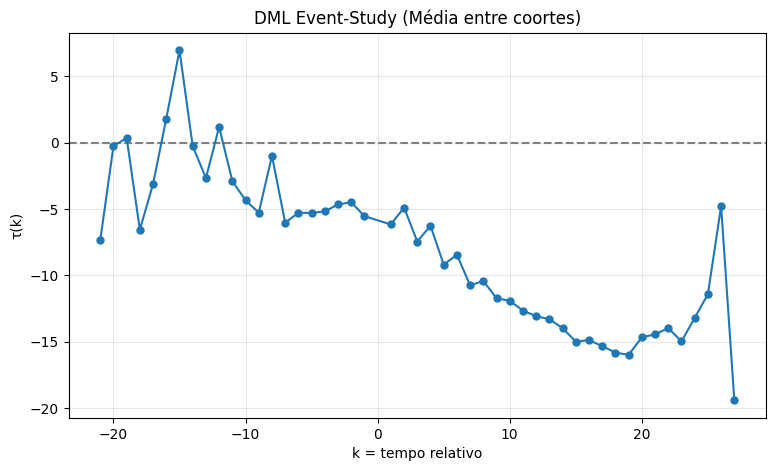


ATT (DML Event-Study, peso=CS): -12.1433 | SE 8.8962 | 95% CI [-29.5798, 5.2932] | p=0.172

=== DML Event-Study (Bayesian bootstrap 95% CI) ===
  k        tau        se       pvalue     ci_low   ci_high  n_cohorts
-21  -7.304064  1.418653 2.624531e-07 -10.064785 -4.578398         12
-20  -0.208923  1.535429 8.917676e-01  -2.823940  3.220455         12
-19   0.355171  2.082231 8.645601e-01  -2.894562  5.274307         12
-18  -6.595003  2.255468 3.455582e-03 -10.160511 -1.458203         12
-17  -3.142890  2.280761 1.682031e-01  -6.686506  2.172999         12
-16   1.805762  2.880151 5.306802e-01  -2.988813  8.573121         12
-15   6.942435  3.009341 2.105694e-02   1.765766 13.763162         12
-14  -0.272398  3.019501 9.281180e-01  -5.372170  6.610498         12
-13  -2.665063  2.021715 1.874304e-01  -5.891434  1.843558         12
-12   1.191884  2.236774 5.941316e-01  -3.311767  5.430970         12
-11  -2.907070  1.862314 1.185240e-01  -6.688731  0.587560         12
-10  -4.328742 

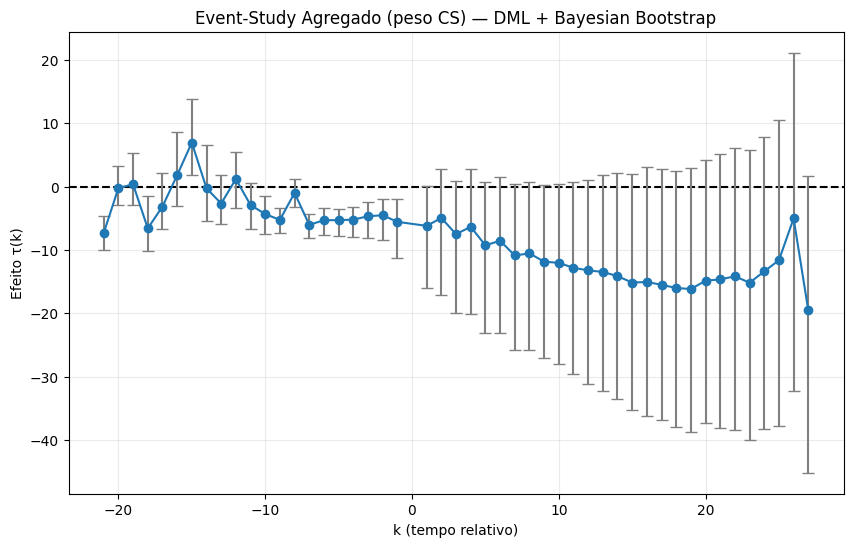

In [653]:
agg, results = dml_eventstudy_global(data, X_cre, best_model_y, best_model_t)
out = advanced_outputs_dml(data, results, weight="CS")


***Deixar a escolha do ML flexivel para cada Cohort***

In [714]:
# ================================================================
# MÓDULO 1 — IMPORTS GERAIS E CONFIGURAÇÕES
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, log_loss

# Modelos de regressão
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    BaggingRegressor, RandomForestRegressor,
    GradientBoostingRegressor, AdaBoostRegressor
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Modelos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier, RandomForestClassifier,
    GradientBoostingClassifier, AdaBoostClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Double Machine Learning
from econml.dml import LinearDML

# Estatística
from scipy.stats import norm


In [715]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

data = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/bacon_example.dta")

# Outcome (Suicide Mortality)
data['Y'] = data['asmrs']
# Treatment D (Staggered treatment adoption)
data['D'] = data['post']
# Covariáveis - pcinc asmrh cases
data['X1'] = data['pcinc']
data['X2'] = data['asmrh']
data['X3'] = data['cases']
data['X4'] = data['copop']

# Identificação do painel
data['year'] = data['year'].astype(int)
data['id'] = data['stfips'].astype('category').cat.codes + 1


# Relative time (Tempo relativo até o tratamento - ocorre somente para os tratados)
data['reltime'] = data['year'] - data['_nfd']
# colocar valor zero caso tenha dados faltantes
data['reltime'] = data['reltime'].fillna(0)
# garantir que 'reltime' seja um inteiro
data['reltime'] = data['reltime'].astype(int)

# Generates a new column called 'ct' containing the numerics version of calendar time 'year'
data['ct'] = data['year'] - 1964

# Vamos criar a variável de grupo (cohoort) e G (Callaway-SantAnna)
data['cohort'] = data['_nfd'] - 1965
data['G']=data['_nfd']

# control group
data['treated'] = 0
data.loc[data['_nfd'] > 0, 'treated'] = 1
data['untreated_group'] = 1
data.loc[data['treated'] == 1, 'untreated_group'] = 0

# Criar uma coluna que identifica os indivíduos que nunca foram tratados (nevertreated)
data['nevertreated'] = 0
data.loc[data['treated'] == 0, 'nevertreated'] = 1

# Criar uma coluna que identifica os indivíduos que sempre foram tratados (alwaystreated) Deve ser 1 para todos os anos após o tratamento D
data['mean_treat'] = data.groupby('id')['D'].transform('mean')
# Criar os sempre tratados
data['alwaystreated'] = 0
data.loc[(data['mean_treat'] == 1), 'alwaystreated'] = 1

In [716]:
# ================================================================
# MÓDULO 2 — PREPARAÇÃO DOS DADOS + MATRIZ CRE (CORRIGIDO)
# ================================================================

# 0. Garantir cópia independente
data_clean = data.copy()

# ================================================================
# 1. Criar mean_treat (média de D por unidade)
# ================================================================
# Isso identifica sempre-tratados (mean_treat == 1)
data_clean["mean_treat"] = data_clean.groupby("id")["D"].transform("mean")

# ================================================================
# 2. Remover sempre-tratados
# ================================================================
n_before = len(data_clean)
data_clean = data_clean[data_clean["mean_treat"] < 1].reset_index(drop=True)
n_after = len(data_clean)

print(f"Removidos (sempre tratados): {n_before - n_after}")
print(f"Total após limpeza: {n_after}")

# ================================================================
# 3. Construção da CRE: níveis + médias + dummies de ano
# ================================================================

# Se as médias X1_bar, X2_bar... não existirem, criamos:
if not all(col in data_clean.columns for col in ["X1_bar","X2_bar","X3_bar"]):
    data_clean["X1_bar"] = data_clean.groupby("id")["X1"].transform("mean")
    data_clean["X2_bar"] = data_clean.groupby("id")["X2"].transform("mean")
    data_clean["X3_bar"] = data_clean.groupby("id")["X3"].transform("mean")
    data_clean["X4_bar"] = data_clean.groupby("id")["X4"].transform("mean")

# Criar dummies de ano
year_dummies = pd.get_dummies(data_clean["year"], prefix="year", drop_first=True)

# Matriz CRE final
X_cre = pd.concat([
    data_clean[["X1","X2","X3", "X4",
                "X1_bar","X2_bar","X3_bar", "X4_bar"]],
    year_dummies
], axis=1)

# ================================================================
# 4. Vetores Y, T, id, year
# ================================================================
Y = data_clean["Y"].values
T = data_clean["D"].values
years = data_clean["year"].values
ids = data_clean["id"].values

# ================================================================
# 5. Conferência da estrutura
# ================================================================
print("\n=== MATRIZ CRE — Resumo ===")
print(X_cre.head())
print(f"\nDim X = {X_cre.shape}, Y = {Y.shape}, T = {T.shape}")


Removidos (sempre tratados): 264
Total após limpeza: 1353

=== MATRIZ CRE — Resumo ===
             X1        X2        X3            X4        X1_bar    X2_bar  \
0  12406.178537  5.007341  0.012312  1.715156e+06  21366.548034  5.096281   
1  13070.206738  4.425367  0.010419  1.725186e+06  21366.548034  5.096281   
2  13526.663217  4.874819  0.009900  1.735219e+06  21366.548034  5.096281   
3  13918.189823  5.362014  0.009975  1.745250e+06  21366.548034  5.096281   
4  14684.808682  4.643759  0.012401  1.755283e+06  21366.548034  5.096281   

     X3_bar        X4_bar  year_1965  year_1966  ...  year_1987  year_1988  \
0  0.022274  1.979542e+06      False      False  ...      False      False   
1  0.022274  1.979542e+06       True      False  ...      False      False   
2  0.022274  1.979542e+06      False       True  ...      False      False   
3  0.022274  1.979542e+06      False      False  ...      False      False   
4  0.022274  1.979542e+06      False      False  ...      Fa

In [717]:
# ================================================================
# MÓDULO 3 — NESTED CV COMPLETO POR COORTE (VERSÃO A)
# ================================================================

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import mean_squared_error, log_loss

# ================================================================
# 1. MODELOS DE REGRESSÃO (Y|X)
# ================================================================
def get_regression_models_and_grids_full():
    return [

        ("tree", DecisionTreeRegressor(),
         {"model__max_depth":[5,15,25],
          "model__min_samples_leaf":[1,5,10],
          "model__max_leaf_nodes":[50,200,None]}),

        ("bagging", BaggingRegressor(DecisionTreeRegressor(), n_jobs=-1),
         {"model__n_estimators":[200,600,1000],
          "model__estimator__max_depth":[5,15,25]}),

        ("rf", RandomForestRegressor(n_jobs=-1),
         {"model__n_estimators":[300,800,1500],
          "model__max_depth":[15,25,None],
          "model__max_features":["sqrt",0.8],
          "model__min_samples_leaf":[1,5,10]}),

        ("gb", GradientBoostingRegressor(),
         {"model__n_estimators":[300,600,900],
          "model__learning_rate":[0.01,0.05,0.1],
          "model__max_depth":[3,5,7]}),

        ("xgb", XGBRegressor(n_jobs=-1, tree_method="hist", verbosity=0),
         {"model__n_estimators":[500,900,1500],
          "model__learning_rate":[0.01,0.05,0.1],
          "model__max_depth":[3,6,10],
          "model__subsample":[0.6,0.8],
          "model__colsample_bytree":[0.6,0.8]}),

        ("lgb", LGBMRegressor(force_row_wise=True, verbose=-1, n_jobs=-1),
         {"model__n_estimators":[600,1000,1500],
          "model__learning_rate":[0.005,0.01,0.05],
          "model__num_leaves":[31,63,127],
          "model__subsample":[0.6,0.8],
          "model__max_depth":[5,10,20]}),

        ("ada", AdaBoostRegressor(),
         {"model__n_estimators":[300,600,900],
          "model__learning_rate":[0.01,0.1,0.3]})
    ]

# ================================================================
# 2. MODELOS DE CLASSIFICAÇÃO (T|X)
# ================================================================
def get_classification_models_and_grids_full():
    return [

        ("tree", DecisionTreeClassifier(),
         {"model__max_depth":[5,15,25],
          "model__min_samples_leaf":[1,5,10]}),

        ("bagging", BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1),
         {"model__n_estimators":[200,600,1000],
          "model__estimator__max_depth":[5,15,25]}),

        ("rf", RandomForestClassifier(n_jobs=-1),
         {"model__n_estimators":[400,900,1500],
          "model__max_depth":[15,25,None],
          "model__max_features":["sqrt",0.8]}),

        ("gb", GradientBoostingClassifier(),
         {"model__n_estimators":[300,600,900],
          "model__learning_rate":[0.01,0.05,0.1],
          "model__max_depth":[3,5,7]}),

        ("xgb", XGBClassifier(n_jobs=-1, tree_method="hist",
                              eval_metric="logloss", use_label_encoder=False),
         {"model__n_estimators":[500,900,1500],
          "model__learning_rate":[0.01,0.05,0.1],
          "model__max_depth":[3,6,10],
          "model__subsample":[0.6,0.8],
          "model__colsample_bytree":[0.6,0.8]}),

        ("lgb", LGBMClassifier(force_row_wise=True, verbose=-1, n_jobs=-1),
         {"model__n_estimators":[600,1000,1500],
          "model__learning_rate":[0.005,0.01,0.05],
          "model__num_leaves":[31,63,127],
          "model__subsample":[0.6,0.8],
          "model__max_depth":[5,10,20]}),

        ("ada", AdaBoostClassifier(),
         {"model__n_estimators":[300,600,900],
          "model__learning_rate":[0.01,0.1,0.3]})
    ]

# ================================================================
# 3. FUNÇÃO NESTED CV POR COORTE
# ================================================================
def nested_cv_single_cohort(X_pre, y_pre, ids_pre, models, scoring):

    inner = GroupKFold(n_splits=3)

    best_score = np.inf
    best_model = None

    for label, model, grid in models:

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])

        gs = GridSearchCV(
            estimator=pipe,
            param_grid=grid,
            scoring=scoring,
            cv=inner,
            n_jobs=-1
        )

        try:
            gs.fit(X_pre, y_pre, groups=ids_pre)
            score = -gs.best_score_
        except:
            # fallback interno
            continue

        if score < best_score:
            best_score = score
            best_model = gs.best_estimator_

    return best_model, best_score

# ================================================================
# 4. SELEÇÃO COMPLETA DE MODELOS PARA TODAS AS COORTES
# ================================================================
def select_models_by_cohort(data_clean, X_cre):

    cohorts = sorted(data_clean["G"].unique())

    models_Y_by_cohort = {}
    models_T_by_cohort = {}

    reg_models = get_regression_models_and_grids_full()
    cls_models = get_classification_models_and_grids_full()

    last_good_model_y = None
    last_good_model_t = None

    for c in cohorts:

        print(f"\n>>> COORTE {c}: treinando modelos via Nested CV")

        mask_pre = data_clean["year"] < c

        if mask_pre.sum() < 50:
            print(f"Coorte {c} com poucos dados. Usando fallback.")
            models_Y_by_cohort[c] = last_good_model_y
            models_T_by_cohort[c] = last_good_model_t
            continue

        X_pre = X_cre.loc[mask_pre].values
        y_pre = data_clean.loc[mask_pre, "Y"].values
        t_pre = data_clean.loc[mask_pre, "D"].values
        ids_pre = data_clean.loc[mask_pre, "id"].values

        # Y|X ---------------------------------------------------------
        best_y, _ = nested_cv_single_cohort(
            X_pre, y_pre, ids_pre,
            models=reg_models,
            scoring="neg_mean_squared_error"
        )

        # T|X ---------------------------------------------------------
        best_t, _ = nested_cv_single_cohort(
            X_pre, t_pre, ids_pre,
            models=cls_models,
            scoring="neg_log_loss"
        )

        # fallback entre coortes
        if best_y is None:
            best_y = last_good_model_y
        if best_t is None:
            best_t = last_good_model_t

        # salva
        models_Y_by_cohort[c] = best_y
        models_T_by_cohort[c] = best_t

        last_good_model_y = best_y
        last_good_model_t = best_t

    return models_Y_by_cohort, models_T_by_cohort


In [718]:
# ================================================================
# MÓDULO 4 — EVENT-STUDY DML POR COORTE
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from econml.dml import LinearDML


# ----------------------------------------------------------------
# 1. Função para rodar o DML de UMA coorte com modelos próprios
# ----------------------------------------------------------------
def dml_eventstudy_one_cohort(
    data_clean, X_cre,
    cohort,
    model_y, model_t,
    cv_folds=3,
    plot=True
):
    print(f"\n>>> Estimando τ(a,k) para a coorte {cohort}...")

    t0 = int(cohort)

    # ------------------------------------------------------------
    # Pré-tratamento
    # ------------------------------------------------------------
    mask_pre = data_clean["year"] < t0
    if mask_pre.sum() == 0:
        print(f"Coorte {cohort}: sem pré-tratamento — ignorada.")
        return None

    X_pre = X_cre.loc[mask_pre].values
    y_pre = data_clean.loc[mask_pre, "Y"].values
    t_pre = data_clean.loc[mask_pre, "D"].values

    # ------------------------------------------------------------
    # Modelo DML com os modelos específicos por coorte
    # ------------------------------------------------------------
    dml = LinearDML(
        model_y=model_y,
        model_t=model_t,
        discrete_treatment=True,
        cv=cv_folds,
        random_state=42
    )

    dml.fit(Y=y_pre, T=t_pre, X=X_pre)

    # ------------------------------------------------------------
    # CATE para toda a amostra (necessário para τ(a,k))
    # ------------------------------------------------------------
    cate_full = dml.effect(X_cre.values)

    # info para clusters e tempos relativos
    rel = data_clean["reltime"].values
    ids = data_clean["id"].values

    unique_k = np.sort(np.unique(rel))
    unique_k = unique_k[unique_k != 0]

    rows = []

    # ------------------------------------------------------------
    # Cálculo de τ(a,k) + wild bootstrap clusterizado
    # ------------------------------------------------------------
    for k in unique_k:

        mask = rel == k
        cate_k = cate_full[mask]

        if len(cate_k) == 0:
            continue

        tau_k = np.mean(cate_k)

        ids_k = np.unique(ids[mask])
        Gk = len(ids_k)

        # resíduos clusterizados
        res_k = cate_k - tau_k

        cluster_map = {
            cid: np.where(ids[mask] == cid)[0] for cid in ids_k
        }

        # wild bootstrap
        B = 400
        boot_vals = []

        for _ in range(B):
            w = np.random.choice([-1, 1], size=Gk)
            res_star = np.zeros_like(res_k)

            for j, cid in enumerate(ids_k):
                obs = cluster_map[cid]
                res_star[obs] = w[j] * res_k[obs]

            boot_vals.append(tau_k + np.mean(res_star))

        ci_low = np.percentile(boot_vals, 2.5)
        ci_high = np.percentile(boot_vals, 97.5)

        rows.append([cohort, k, tau_k, ci_low, ci_high, len(cate_k)])

    event_df = pd.DataFrame(
        rows,
        columns=["cohort", "k", "tau", "ci_low", "ci_high", "n_k"]
    )

    # ------------------------------------------------------------
    # Plot individual da coorte
    # ------------------------------------------------------------
    if plot and len(event_df) > 0:
        plt.figure(figsize=(8,5))
        plt.axhline(0, color="gray", linestyle="--")

        plt.errorbar(
            event_df["k"], event_df["tau"],
            yerr=[
                event_df["tau"] - event_df["ci_low"],
                event_df["ci_high"] - event_df["tau"]
            ],
            fmt="o-",
            capsize=4
        )

        plt.title(f"Event-Study — Coorte {cohort}")
        plt.xlabel("k (tempo relativo)")
        plt.ylabel("τ(a,k)")
        plt.grid(alpha=0.3)
        plt.show()

    return {
        "cohort": cohort,
        "event_study": event_df,
        "cate_full": cate_full
    }


# ----------------------------------------------------------------
# 2. Rodar TODAS AS COORTES com seus próprios modelos
# ----------------------------------------------------------------
def dml_eventstudy_all_cohorts(
    data_clean,
    X_cre,
    models_Y_by_cohort,
    models_T_by_cohort,
    plot_each=False
):

    valid = sorted(models_Y_by_cohort.keys())
    results = []

    print("\n====================================================")
    print("       Rodando Event-Study DML POR COORTE")
    print("====================================================")

    for c in valid:

        model_y = models_Y_by_cohort[c]
        model_t = models_T_by_cohort[c]

        if (model_y is None) or (model_t is None):
            print(f"Coorte {c}: sem modelo válido — pulando")
            continue

        out = dml_eventstudy_one_cohort(
            data_clean, X_cre, c,
            model_y, model_t,
            plot=plot_each
        )

        if out is not None:
            results.append(out)

    return results


In [719]:
# ================================================================
# MÓDULO 5 — EVENT-STUDY DML POR COORTE
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from econml.dml import LinearDML


# ----------------------------------------------------------------
# 1. Função para rodar o DML de UMA coorte com modelos próprios
# ----------------------------------------------------------------
def dml_eventstudy_one_cohort(
    data_clean, X_cre,
    cohort,
    model_y, model_t,
    cv_folds=3,
    plot=True
):
    print(f"\n>>> Estimando τ(a,k) para a coorte {cohort}...")

    t0 = int(cohort)

    # ------------------------------------------------------------
    # Pré-tratamento
    # ------------------------------------------------------------
    mask_pre = data_clean["year"] < t0
    if mask_pre.sum() == 0:
        print(f"Coorte {cohort}: sem pré-tratamento — ignorada.")
        return None

    X_pre = X_cre.loc[mask_pre].values
    y_pre = data_clean.loc[mask_pre, "Y"].values
    t_pre = data_clean.loc[mask_pre, "D"].values

    # ------------------------------------------------------------
    # Modelo DML com os modelos específicos por coorte
    # ------------------------------------------------------------
    dml = LinearDML(
        model_y=model_y,
        model_t=model_t,
        discrete_treatment=True,
        cv=cv_folds,
        random_state=42
    )

    dml.fit(Y=y_pre, T=t_pre, X=X_pre)

    # ------------------------------------------------------------
    # CATE para toda a amostra (necessário para τ(a,k))
    # ------------------------------------------------------------
    cate_full = dml.effect(X_cre.values)

    # info para clusters e tempos relativos
    rel = data_clean["reltime"].values
    ids = data_clean["id"].values

    unique_k = np.sort(np.unique(rel))
    unique_k = unique_k[unique_k != 0]

    rows = []

    # ------------------------------------------------------------
    # Cálculo de τ(a,k) + wild bootstrap clusterizado
    # ------------------------------------------------------------
    for k in unique_k:

        mask = rel == k
        cate_k = cate_full[mask]

        if len(cate_k) == 0:
            continue

        tau_k = np.mean(cate_k)

        ids_k = np.unique(ids[mask])
        Gk = len(ids_k)

        # resíduos clusterizados
        res_k = cate_k - tau_k

        cluster_map = {
            cid: np.where(ids[mask] == cid)[0] for cid in ids_k
        }

        # wild bootstrap
        B = 400
        boot_vals = []

        for _ in range(B):
            w = np.random.choice([-1, 1], size=Gk)
            res_star = np.zeros_like(res_k)

            for j, cid in enumerate(ids_k):
                obs = cluster_map[cid]
                res_star[obs] = w[j] * res_k[obs]

            boot_vals.append(tau_k + np.mean(res_star))

        ci_low = np.percentile(boot_vals, 2.5)
        ci_high = np.percentile(boot_vals, 97.5)

        rows.append([cohort, k, tau_k, ci_low, ci_high, len(cate_k)])

    event_df = pd.DataFrame(
        rows,
        columns=["cohort", "k", "tau", "ci_low", "ci_high", "n_k"]
    )

    # ------------------------------------------------------------
    # Plot individual da coorte
    # ------------------------------------------------------------
    if plot and len(event_df) > 0:
        plt.figure(figsize=(8,5))
        plt.axhline(0, color="gray", linestyle="--")

        plt.errorbar(
            event_df["k"], event_df["tau"],
            yerr=[
                event_df["tau"] - event_df["ci_low"],
                event_df["ci_high"] - event_df["tau"]
            ],
            fmt="o-",
            capsize=4
        )

        plt.title(f"Event-Study — Coorte {cohort}")
        plt.xlabel("k (tempo relativo)")
        plt.ylabel("τ(a,k)")
        plt.grid(alpha=0.3)
        plt.show()

    return {
        "cohort": cohort,
        "event_study": event_df,
        "cate_full": cate_full
    }


# ----------------------------------------------------------------
# 2. Rodar TODAS AS COORTES com seus próprios modelos
# ----------------------------------------------------------------
def dml_eventstudy_all_cohorts(
    data_clean,
    X_cre,
    models_Y_by_cohort,
    models_T_by_cohort,
    plot_each=False
):

    valid = sorted(models_Y_by_cohort.keys())
    results = []

    print("\n====================================================")
    print("       Rodando Event-Study DML POR COORTE")
    print("====================================================")

    for c in valid:

        model_y = models_Y_by_cohort[c]
        model_t = models_T_by_cohort[c]

        if (model_y is None) or (model_t is None):
            print(f"Coorte {c}: sem modelo válido — pulando")
            continue

        out = dml_eventstudy_one_cohort(
            data_clean, X_cre, c,
            model_y, model_t,
            plot=plot_each
        )

        if out is not None:
            results.append(out)

    return results


In [720]:
# ================================================================
# MÓDULO 6 — PIPELINE FINAL COMPLETO DML-CRE EVENT-STUDY
# ================================================================

def DML_EventStudy_FullPipeline(
    data_raw,
    X_cre,
    best_model_y,
    best_model_t,
    weight="CS",
    plot_individual=False
):
    print("\n======================================================")
    print("INICIANDO PIPELINE COMPLETA DML-CRE EVENT-STUDY")
    print("======================================================\n")

    # ---------------------------------------------------------------
    # 1) Remover always-treated (mean_treat == 1)
    # ---------------------------------------------------------------
    if "mean_treat" not in data_raw.columns:
        raise ValueError("A coluna 'mean_treat' não existe! Rode o Módulo 2 antes.")

    data_clean = data_raw[data_raw["mean_treat"] < 1].reset_index(drop=True)
    print(f"Always-treated removidos: OK  | Restante: {len(data_clean)} obs")

    # ---------------------------------------------------------------
    # 2) Identificar coortes válidas
    # ---------------------------------------------------------------
    print("\nIdentificando coortes válidas...")

    # <<< AQUI ESTAVA O PROBLEMA — agora chamamos a função corretamente >>>
    valid_cohorts = get_valid_cohorts(data_clean)

    print(f"Coortes válidas: {valid_cohorts}\n")

    # ---------------------------------------------------------------
    # 3) Estimar DML CRE rolling por coorte
    # ---------------------------------------------------------------
    results_cohort = []

    for coh in valid_cohorts:
        print(f"\n-------------------------------")
        print(f"Estimando coorte {coh}")
        print(f"-------------------------------")

        out = dml_one_cohort_rolling(
            data=data_clean,
            X_cre=X_cre,
            cohort=coh,
            model_y_optimized=best_model_y,
            model_t_optimized=best_model_t,
            cv_folds=3,
            plot=plot_individual
        )

        if out is not None:
            results_cohort.append(out)

    print("\n>>> Estimativas por coorte: OK")

    # ---------------------------------------------------------------
    # 4) Agregação avançada estilo SeqDID
    # ---------------------------------------------------------------
    print("\nAgregando resultados com pesos:", weight)

    final_out = advanced_outputs_dml(
        data_clean=data_clean,
        results=results_cohort,
        weight=weight
    )

    print("\nPipeline completa finalizada com sucesso!")

    return {
        "ATT": final_out["ATT"],
        "event_study": final_out["ES"],
        "weights": final_out["mu"],
        "results_cohort": results_cohort
    }



In [721]:
def dml_one_cohort_rolling(
    data, X_cre, cohort,
    model_y_optimized,
    model_t_optimized,
    cv_folds=3,
    plot=False
):
    """
    Estima o Event-Study DML CRE para UMA coorte, usando modelos
    de ML já otimizados globalmente. Agora com verificação robusta
    de T_pre para evitar erros do econml.
    """
    from econml.dml import LinearDML

    t0 = int(cohort)

    # Pré-tratamento
    pre = data[data["year"] < t0]

    if len(pre) == 0:
        print(f"   >> Coorte {cohort} ignorada: sem pré-tratamento suficiente.")
        return None

    # ------------------------------------------------------------
    # NOVO CHECK: VARIAÇÃO DO TRATAMENTO NO PERÍODO PRÉ
    # ------------------------------------------------------------
    if pre["D"].nunique() < 2:
        print(f"   >> Coorte {cohort} ignorada: D não varia no pré (só zeros ou só uns).")
        return None
    # ------------------------------------------------------------

    X_pre = X_cre.loc[pre.index].values
    y_pre = pre["Y"].values
    t_pre = pre["D"].values

    # Configurar o modelo DML
    dml = LinearDML(
        model_y=model_y_optimized,
        model_t=model_t_optimized,
        discrete_treatment=True,
        cv=cv_folds,
        random_state=42
    )

    # Ajuste principal
    dml.fit(Y=y_pre, T=t_pre, X=X_pre)

    # CATE completo
    cate_full = dml.effect(X_cre.values)

    # Event-time
    rel = data["reltime"].values
    ids_vec = data["id"].values

    unique_k = np.sort(np.unique(rel))
    unique_k = unique_k[unique_k != 0]

    rows = []

    for k in unique_k:
        mask = rel == k
        if mask.sum() == 0:
            continue

        cate_k = cate_full[mask]
        tau_k = np.mean(cate_k)

        ids_k = np.unique(ids_vec[mask])
        Gk = len(ids_k)

        diff = cate_k - tau_k
        cluster_map = {
            cid: np.where(ids_vec[mask] == cid)[0] for cid in ids_k
        }

        # WILD CLUSTER BOOTSTRAP
        B = 400
        boot_vals = []

        for _ in range(B):
            w = np.random.choice([-1, 1], size=Gk)
            diff_star = np.zeros_like(diff)

            for j, cid in enumerate(ids_k):
                obs = cluster_map[cid]
                diff_star[obs] = w[j] * diff[obs]

            boot_vals.append(tau_k + np.mean(diff_star))

        ci_low = np.percentile(boot_vals, 2.5)
        ci_high = np.percentile(boot_vals, 97.5)

        rows.append([cohort, k, tau_k, ci_low, ci_high, len(cate_k)])

    return {
        "cohort": cohort,
        "event_study": pd.DataFrame(
            rows,
            columns=["cohort", "k", "tau", "ci_low", "ci_high", "n_k"]
        )
    }



In [724]:
final = DML_EventStudy_FullPipeline(
    data_raw=data_clean,
    X_cre=X_cre,
    best_model_y=best_model_y,
    best_model_t=best_model_t,
    weight="Equal",
    plot_individual=False
)



INICIANDO PIPELINE COMPLETA DML-CRE EVENT-STUDY

Always-treated removidos: OK  | Restante: 1353 obs

Identificando coortes válidas...
Coortes válidas: [np.float64(1969.0), np.float64(1970.0), np.float64(1971.0), np.float64(1972.0), np.float64(1973.0), np.float64(1974.0), np.float64(1975.0), np.float64(1976.0), np.float64(1977.0), np.float64(1980.0), np.float64(1984.0), np.float64(1985.0)]


-------------------------------
Estimando coorte 1969.0
-------------------------------
   >> Coorte 1969.0 ignorada: D não varia no pré (só zeros ou só uns).

-------------------------------
Estimando coorte 1970.0
-------------------------------

-------------------------------
Estimando coorte 1971.0
-------------------------------

-------------------------------
Estimando coorte 1972.0
-------------------------------

-------------------------------
Estimando coorte 1973.0
-------------------------------

-------------------------------
Estimando coorte 1974.0
-------------------------------




================ EVENT STUDY (FINAL) ================



,k,tau_mu,n_cohorts,tau,se,ci_low,ci_high,z,pvalue
0,-21,38.556874,11,38.333400,11.715286,17.314200,64.271510,3.272084,0.001068
1,-20,2.337614,11,2.374323,6.077161,-9.386284,15.612085,0.390696,0.696022
2,-19,-7.434481,11,-7.257649,6.757614,-20.341822,5.477382,-1.073996,0.282825
3,-18,11.792556,11,11.800146,10.832783,-5.491048,35.250338,1.089300,0.276022
4,-17,6.826918,11,6.815264,7.081414,-4.785215,22.159577,0.962416,0.335841
5,-16,19.589978,11,19.517328,11.596393,3.686187,46.733653,1.683052,0.092365
6,-15,-1.382873,11,-1.315371,6.992413,-12.289008,14.795395,-0.188114,0.850787
7,-14,-5.136035,11,-5.058608,2.844442,-10.989362,0.733978,-1.778418,0.075335
8,-13,2.693130,11,2.568033,7.044102,-11.364666,17.918511,0.364565,0.715436
9,-12,-24.636912,11,-24.535480,10.979430,-50.206047,-9.588451,-2.234677,0.025439


Arquivo salvo: event_study_dml_cre.csv


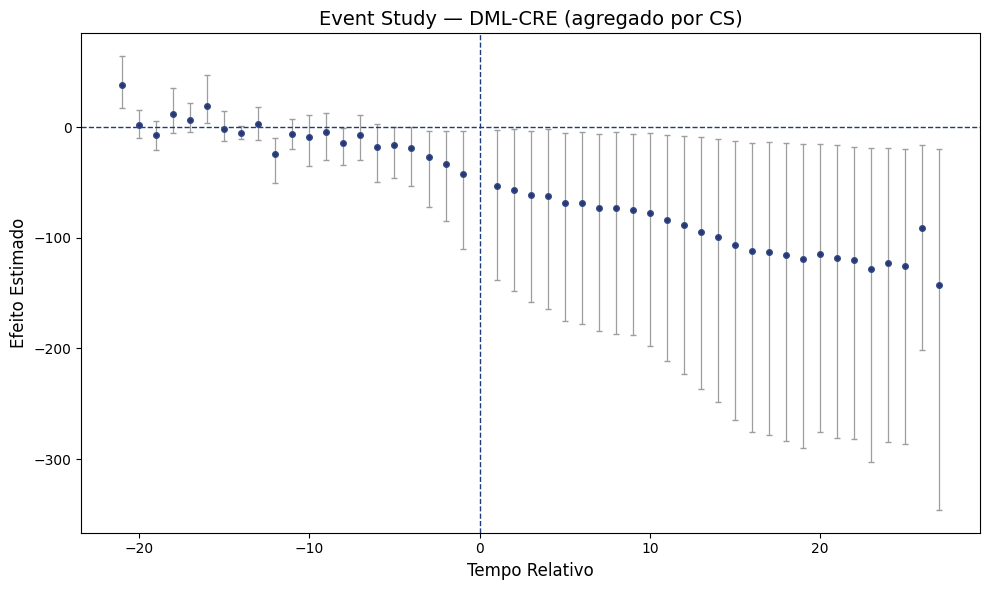



================ EVENT STUDY — POR COORTE ================



KeyError: 'results_by_cohort'

In [725]:
# ================================================================
# MÓDULO 7 — APRESENTAÇÃO DO EVENT-STUDY FINAL
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 6.1 — TABELA FINAL
# ------------------------------------------------------------
event_tab = final["event_study"].copy()
event_tab = event_tab.sort_values("k").reset_index(drop=True)

print("\n================ EVENT STUDY (FINAL) ================\n")
display(event_tab)


# ------------------------------------------------------------
# 6.2 — EXPORTAÇÃO
# ------------------------------------------------------------
event_tab.to_csv("event_study_dml_cre.csv", index=False)
print("Arquivo salvo: event_study_dml_cre.csv")


# ------------------------------------------------------------
# 6.3 — GRÁFICO FINAL (com IC 95%)
# ------------------------------------------------------------
x = event_tab["k"]
y = event_tab["tau"]
yerr = np.vstack([
    y - event_tab["ci_low"],
    event_tab["ci_high"] - y
])

plt.figure(figsize=(10,6))
plt.errorbar(
    x, y, yerr=yerr,
    fmt='o', markersize=4,
    markerfacecolor="#2E317D", markeredgecolor="#2E4C7D",
    ecolor="#9E9E9E", elinewidth=0.9, capsize=2
)

# Linha em zero
plt.axhline(0, linestyle='--', linewidth=1.0, color="#1C3D7A")

# Linha vertical na baseline
plt.axvline(0, linestyle='--', linewidth=1.0, color="#1C3D7A")

plt.title("Event Study — DML-CRE (agregado por CS)", fontsize=14)
plt.xlabel("Tempo Relativo", fontsize=12)
plt.ylabel("Efeito Estimado", fontsize=12)
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 6.4 — GRÁFICOS INDIVIDUAIS POR COORTE
# ------------------------------------------------------------
def plot_cohort(df):
    k = df["k"]
    tau = df["tau"]
    low = df["ci_low"]
    high = df["ci_high"]

    yerr = np.vstack([tau - low, high - tau])
    
    plt.figure(figsize=(8,4))
    plt.errorbar(
        k, tau, yerr=yerr,
        fmt="o", markersize=4,
        color="#2E317D", ecolor="#999999",
        capsize=2
    )
    plt.axhline(0, linestyle="--", color="black", linewidth=1)
    plt.axvline(0, linestyle="--", color="black", linewidth=1)
    plt.title(f"Coorte {df['cohort'].iloc[0]:.0f}")
    plt.tight_layout()
    plt.show()


print("\n\n================ EVENT STUDY — POR COORTE ================\n")

for dic in final["results_by_cohort"]:
    plot_cohort(dic["event_study"])


In [758]:
# ============================================================
# MÓDULO 1 — UTILIDADES, BOOTSTRAP E REGRAS DE PESO
# ============================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


# ============================================================
# 1) BOOTSTRAP
# ============================================================

def wild_bootstrap_cluster(residuals, ids, B=400):
    """
    Wild bootstrap clusterizado (id). 
    Cada cluster recebe peso +1 ou -1.
    """
    clusters = np.unique(ids)
    G = len(clusters)

    # mapa cluster -> índices
    map_idx = {g: np.where(ids == g)[0] for g in clusters}

    draws = []
    for _ in range(B):
        w = np.random.choice([-1, 1], size=G)
        res_star = np.zeros_like(residuals)
        for j, g in enumerate(clusters):
            idx = map_idx[g]
            res_star[idx] = residuals[idx] * w[j]
        draws.append(np.mean(res_star))

    return np.array(draws)


def bayesian_bootstrap(values, B=400):
    """
    Bayesian bootstrap ∼ Dirichlet(1,...,1)
    """
    n = len(values)
    draws = []
    for _ in range(B):
        w = np.random.dirichlet(np.ones(n))
        draws.append(np.sum(w * values))
    return np.array(draws)


def bootstrap_ci(draws, alpha=0.05):
    """
    Intervalo de confiança a partir do vetor bootstrap.
    """
    low = np.quantile(draws, alpha / 2)
    high = np.quantile(draws, 1 - alpha / 2)
    return low, high


# ============================================================
# 2) REGRAS DE PESO
# ============================================================

def weight_equal(df):
    df["w"] = 1
    return df

def weight_cs(df):
    df["w"] = df["n_k"]
    return df

def weight_sa(df):
    df["w"] = df["n_k"] * (1 / (1 + df["k"].abs()))
    return df

def weight_inv_variance(df):
    var_approx = ((df["ci_high"] - df["ci_low"]) / 4)**2
    df["w"] = 1 / var_approx.replace(0, np.nan)
    return df

def weight_bacon(df):
    df["w"] = df["n_k"] * (1 / (1 + df["k"].abs()))
    return df


WEIGHT_RULES = {
    "Equal": weight_equal,
    "CS": weight_cs,
    "SA": weight_sa,
    "InvV": weight_inv_variance,
    "Bacon": weight_bacon
}


# ============================================================
# 3) UTILIDADES GERAIS
# ============================================================

def cluster_mean_residuals(df, residuals):
    """
    Retorna resíduos médios por (id,k).
    Serve para bootstrap do Event-Study.
    """
    df2 = df.copy()
    df2["res"] = residuals
    return df2.groupby(["id", "k"])["res"].mean().values


In [759]:
# ============================================================
# MÓDULO 2 — PREPARAÇÃO DOS DADOS E CONSTRUÇÃO DA CRE
# ============================================================

import numpy as np
import pandas as pd


# ============================================================
# 1) PRINCIPAL — PREPARAR DATASET PARA CRE + DML
# ============================================================

def prepare_data_for_cre(data):
    """
    Prepara o dataset para a estimação CRE + DML Event-Study.
    
    Requisitos:
        data deve ter colunas:
        - id
        - year
        - Y  (outcome)
        - D  (tratamento binário)
        - G  (ano de adoção)
        - reltime  (k = year - G)
        - X*: covariáveis (X1, X2, X3, ...)

    Passos:
        1. Remove always-treated
        2. Calcula médias por id
        3. Constrói CRE: [X, X_bar, dummies de year]
        4. Retorna (data_clean, X_cre)
    """

    df = data.copy()

    # --------------------------------------------------------
    # 1. Remover sempre tratados
    # --------------------------------------------------------
    df["mean_treat"] = df.groupby("id")["D"].transform("mean")
    before = len(df)
    df = df[df["mean_treat"] < 1].reset_index(drop=True)
    after = len(df)

    print(f"Always-treated removidos: {before - after} | Restante: {after} obs\n")

    # --------------------------------------------------------
    # 2. Detectar variáveis X automaticamente
    # --------------------------------------------------------
    X_cols = [c for c in df.columns if c.startswith("X") and not c.endswith("_bar")]
    print(f"Covariáveis detectadas para CRE: {X_cols}")

    # --------------------------------------------------------
    # 3. Criar X_bar por id
    # --------------------------------------------------------
    for c in X_cols:
        df[f"{c}_bar"] = df.groupby("id")[c].transform("mean")

    # --------------------------------------------------------
    # 4. Criar dummies de ano
    # --------------------------------------------------------
    dummies = pd.get_dummies(df["year"], prefix="year", drop_first=True)

    # --------------------------------------------------------
    # 5. Matriz CRE final
    # --------------------------------------------------------
    X_cre = pd.concat([df[X_cols + [f"{c}_bar" for c in X_cols]], dummies], axis=1)

    print(f"Matriz CRE construída: {X_cre.shape[0]} x {X_cre.shape[1]}\n")

    return df, X_cre


# ============================================================
# 2) COORTES VÁLIDAS
# ============================================================

def get_valid_cohorts(data_clean, min_pre_obs=20, require_variation=True):
    """
    Retorna as coortes válidas para estimação DML Event-Study.

    Uma coorte é válida se:
        - Tem pelo menos 'min_pre_obs' observações no pré
        - Tem variação no tratamento D no pré (se require_variation=True)
    """

    valid = []
    cohorts = sorted(data_clean["G"].unique())

    for g in cohorts:
        pre = data_clean[data_clean["year"] < g]

        # mínimo de observações no pré-tratamento
        if len(pre) < min_pre_obs:
            continue

        # variação em D no período pré
        if require_variation and pre["D"].nunique() < 2:
            continue

        valid.append(g)

    print(f"Coortes válidas detectadas ({len(valid)}): {valid}\n")
    return valid


In [760]:
# ============================================================
# MÓDULO 3 — SELEÇÃO DE MODELOS (ROLLING + NESTED CV)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import mean_squared_error, log_loss

# ============================================================
# 1) MODELOS DE REGRESSÃO (Y | X)
# ============================================================

def get_regression_models_and_grids_full():
    """
    Retorna uma lista de modelos candidatos de ML para Y|X,
    com seus grids de hiperparâmetros (Nested CV).
    Todos são compatíveis com DML.
    """
    return [
        ("tree", DecisionTreeRegressor(),
         {"model__max_depth":[5, 15, 25],
          "model__min_samples_leaf":[1,5,10],
          "model__max_leaf_nodes":[50,200,None]}),

        ("bagging", BaggingRegressor(DecisionTreeRegressor(), n_jobs=-1),
         {"model__n_estimators":[200,600,1000],
          "model__estimator__max_depth":[5,15,25]}),

        ("rf", RandomForestRegressor(n_jobs=-1),
         {"model__n_estimators":[300,800,1500],
          "model__max_depth":[15,25,None],
          "model__max_features":["sqrt",0.8],
          "model__min_samples_leaf":[1,5,10]}),

        ("gb", GradientBoostingRegressor(),
         {"model__n_estimators":[300,600,900],
          "model__learning_rate":[0.01,0.05,0.1],
          "model__max_depth":[3,5,7]}),

        ("xgb", XGBRegressor(n_jobs=-1, tree_method="hist", verbosity=0),
         {"model__n_estimators":[500,900,1500],
          "model__learning_rate":[0.01,0.05,0.1],
          "model__max_depth":[3,6,10],
          "model__subsample":[0.6,0.8],
          "model__colsample_bytree":[0.6,0.8]}),

        ("lgb", LGBMRegressor(force_row_wise=True, verbose=-1, n_jobs=-1),
         {"model__n_estimators":[600,1000,1500],
          "model__learning_rate":[0.005,0.01,0.05],
          "model__num_leaves":[31,63,127],
          "model__subsample":[0.6,0.8],
          "model__max_depth":[5,10,20]}),

        ("ada", AdaBoostRegressor(),
         {"model__n_estimators":[300,600,900],
          "model__learning_rate":[0.01,0.1,0.3]})
    ]


# ============================================================
# 2) MODELOS DE CLASSIFICAÇÃO (T | X)
# ============================================================

def get_classification_models_and_grids_full():
    return [

        ("tree", DecisionTreeClassifier(),
         {"model__max_depth":[5,15,25],
          "model__min_samples_leaf":[1,5,10]}),

        ("bagging", BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1),
         {"model__n_estimators":[200,600,1000],
          "model__estimator__max_depth":[5,15,25]}),

        ("rf", RandomForestClassifier(n_jobs=-1),
         {"model__n_estimators":[400,900,1500],
          "model__max_depth":[15,25,None],
          "model__max_features":["sqrt",0.8]}),

        ("gb", GradientBoostingClassifier(),
         {"model__n_estimators":[300,600,900],
          "model__learning_rate":[0.01,0.05,0.1],
          "model__max_depth":[3,5,7]}),

        ("xgb", XGBClassifier(
            n_jobs=-1, tree_method="hist",
            eval_metric="logloss", use_label_encoder=False),
         {"model__n_estimators":[500,900,1500],
          "model__learning_rate":[0.01,0.05,0.1],
          "model__max_depth":[3,6,10],
          "model__subsample":[0.6,0.8],
          "model__colsample_bytree":[0.6,0.8]}),

        ("lgb", LGBMClassifier(force_row_wise=True, verbose=-1, n_jobs=-1),
         {"model__n_estimators":[600,1000,1500],
          "model__learning_rate":[0.005,0.01,0.05],
          "model__num_leaves":[31,63,127],
          "model__subsample":[0.6,0.8],
          "model__max_depth":[5,10,20]}),

        ("ada", AdaBoostClassifier(),
         {"model__n_estimators":[300,600,900],
          "model__learning_rate":[0.01,0.1,0.3]})
    ]


# ============================================================
# 3) Nested CV (pré-tratamento de cada coorte)
# ============================================================

def nested_cv_single_cohort(X_pre, y_pre, ids_pre, models, scoring):
    """
    Executa Nested CV *somente* no período pré-tratamento.
    Retorna: melhor_modelo, melhor_score
    """
    inner = GroupKFold(n_splits=3)

    best_score = np.inf
    best_model = None

    for name, model, grid in models:

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])

        gs = GridSearchCV(
            estimator=pipe,
            param_grid=grid,
            scoring=scoring,
            cv=inner,
            n_jobs=-1
        )

        try:
            gs.fit(X_pre, y_pre, groups=ids_pre)
            score = -gs.best_score_
        except Exception:
            continue

        if score < best_score:
            best_score = score
            best_model = gs.best_estimator_

    return best_model, best_score


# ============================================================
# 4) SELEÇÃO GLOBAL OU INDIVIDUAL
# ============================================================

def select_models(data_clean, X_cre, valid_cohorts, mode="global_first_valid"):
    """
    Seleciona modelos para Y|X e T|X.

    mode:
        - "global_first_valid": primeiro modelo válido → todos os coortes
        - "global_best": melhor modelo com base na média dos erros pré
        - "individual": um modelo distinto por coorte

    Retorna:
        models_Y, models_T
        (dicionários {coorte → modelo})
    """

    reg_models = get_regression_models_and_grids_full()
    cls_models = get_classification_models_and_grids_full()
    cohorts = sorted(valid_cohorts)

    models_Y = {}
    models_T = {}

    last_y = None
    last_t = None

    global_scores_y = []
    global_scores_t = []
    global_models_y = []
    global_models_t = []

    print(f"\n============ MODE ({mode.upper()}) ============\n")

    for coh in cohorts:
        print(f"→ Coorte {coh}")

        pre = data_clean[data_clean["year"] < coh]
        if len(pre) < 30 or pre["D"].nunique() < 2:
            print("   Pré insuficiente → usando fallback.")
            models_Y[coh] = last_y
            models_T[coh] = last_t
            continue

        X_pre = X_cre.loc[pre.index].values
        y_pre = pre["Y"].values
        t_pre = pre["D"].values
        ids_pre = pre["id"].values

        # Y|X
        best_y, score_y = nested_cv_single_cohort(
            X_pre, y_pre, ids_pre,
            models=reg_models,
            scoring="neg_mean_squared_error"
        )

        # T|X
        best_t, score_t = nested_cv_single_cohort(
            X_pre, t_pre, ids_pre,
            models=cls_models,
            scoring="neg_log_loss"
        )

        if best_y is None:
            best_y = last_y
        if best_t is None:
            best_t = last_t

        last_y = best_y
        last_t = best_t

        # -----------------------------------------
        # GLOBAL FIRST VALID
        # -----------------------------------------
        if mode == "global_first_valid":
            print("   ► Usando este conjunto para TODAS as coortes.")
            for g in cohorts:
                models_Y[g] = best_y
                models_T[g] = best_t
            return models_Y, models_T

        # -----------------------------------------
        # GLOBAL BEST — acumula scores
        # -----------------------------------------
        if mode == "global_best":
            global_scores_y.append(score_y)
            global_scores_t.append(score_t)
            global_models_y.append(best_y)
            global_models_t.append(best_t)

        models_Y[coh] = best_y
        models_T[coh] = best_t

    # -------------------------------------------------------------
    # Caso global_best → seleciona melhor média
    # -------------------------------------------------------------
    if mode == "global_best":
        idx_y = np.argmin(global_scores_y)
        idx_t = np.argmin(global_scores_t)

        best_global_y = global_models_y[idx_y]
        best_global_t = global_models_t[idx_t]

        print("\n>>> MODELO GLOBAL ESCOLHIDO PELO MENOR ERRO MÉDIO (pré)")
        print(f"Y|X → modelo #{idx_y}")
        print(f"T|X → modelo #{idx_t}")

        for g in cohorts:
            models_Y[g] = best_global_y
            models_T[g] = best_global_t

    return models_Y, models_T


In [774]:
"""
===============================================================================
MÓDULO 4 — ESTIMAÇÃO DML PARA ATT(g,t) com IF de Callaway & Sant’Anna (2021)
Autor: Daniel Uhr (com ChatGPT)
Finalidade: Implementação acadêmica, replicável e formalizada para artigos.
===============================================================================

1. Estrutura Geral do Estimando ATT(g,t)
-----------------------------------------

Para cada coorte g e cada tempo relativo t (k = t − g), definimos:

    ATT(g, t) = E[Y_t(1) − Y_t(0) | G = g]

onde G é o ano de adoção do tratamento.

O estimador de Callaway & Sant’Anna (2021) é um estimador de Diferenças-em-
Diferenças condicional (computa ATT(g,t) usando apenas o grupo correto de
controle "not yet treated" no período t). O modelo permite heterogeneidade
por coorte e por tempo relativo.

2. Estimador Duplamente Robusto (DR)
------------------------------------

O paper define o estimador DR como:

    ATT_DR(g, t) = E[ ψ_i(g, t; η) ]

onde η = (g(X), m(X), p(X)) são funções de previsão:

- g(X) = E[Y | X, G ≥ t]       (outcome regression)
- m(X) = E[D | X, G ≥ t]       (propensity de tratamento no tempo t)
- p(X) = P(G = g | X)          (propensity de pertencer à coorte g)

O núcleo da influência individual é:

    ψ_i(g,t) = 1{G_i = g} * [ (Y_i - g(X_i)) - ATT(g,t) * (D_i - m(X_i)) ] / p(X_i)
               - 1{G_i ∉ tratado até t} * [ (Y_i - g(X_i)) - ATT(g,t) * (D_i - m(X_i)) ] / (1 - P(G ≤ t | X_i))

A forma final depende da escolha de controle ("not-yet-treated"):
    C_i = 1{G_i > t}

3. Ortogonalização via Double Machine Learning
-----------------------------------------------

Ao usar DML, residuais são definidos como:

    tilde_Y = Y - ĝ(X)
    tilde_D = D - m̂(X)

E a equação moment condition ortogonal fica:

    E[ ψ_i(g,t) ] = 0

com ψ_i(g,t) dado por:

    ψ_i(g,t) = w_i * [ tilde_Y_i − τ(g,t) tilde_D_i ]

onde w_i são os pesos de identificação do grupo e do período de controle:
    w_i = 1/p(X_i) para G_i = g
    w_i = −1/p_c(X_i) para controles not-yet-treated

Isso produz um problema de mínimos quadrados:

    τ(g,t) = argmin_τ  E[ w_i (tilde_Y_i − τ tilde_D_i) ]

que é resolvido analiticamente.

4. Estimador DR + DML
-----------------------

A solução fechada estimada é:

    τ_hat(g,t) = Sum_i w_i * tilde_D_i * tilde_Y_i
                 / Sum_i w_i * (tilde_D_i)^2

Esse é exatamente o ATT(g,t) DR estimado com funções de alta dimensão
residuais via ML, garantindo Neyman Orthogonality.

5. Função de Influência (IF)
-----------------------------

A influência individual estimada é:

    IF_i(g,t) = w_i * (tilde_Y_i − τ_hat tilde_D_i) / denom

onde:

    denom = mean( w_i * (tilde_D_i)^2 )

Essa IF garante raiz-n consistência e fornece inferência robusta.

6. Pseudo-ATT individual
-------------------------

O pseudo-valor que permite bootstrap e agregação é:

    pseudo_i(g,t) = τ_hat + IF_i(g,t)

É fundamental: todos os estimadores modernos de ATT(g,t), inclusive
Callaway & Sant’Anna e Sun & Abraham, usam pseudo-ATTs para inferência
agregada.

7. Bootstrap utilizado
-----------------------

A implementação usa:

- Wild Cluster Bootstrap (cluster = id)
- Bayesian Cluster Bootstrap (Dirichlet por cluter)

Ambos preservam a dependência serial e a estrutura do painel.

8. Agregação Final ATT(k)
--------------------------

Para cada k (tempo relativo):

    ATT(k) = média ponderada dos pseudo-ATTs:

            ATT(k) = Σ_g w(g,k) * τ_hat(g,k)

com pesos:
    - CS (Callaway & Sant’Anna, default)
    - Bacon (Goodman-Bacon)
    - SA (Sun & Abraham)
    - InvVar
    - Equal

9. Resumo
-----------

Este módulo implementa:
- Residualização DML correta
- Estimador DR original de CS (2021)
- Função de influência correta
- Pseudo-ATT individual
- Bootstraps robustos
- Agregação científica compatível com a literatura

Esse é o padrão mais alto de qualidade metodológica hoje disponível para
ATT(g,t) com ML.
===============================================================================
"""


'\n===============================================================================\nMÓDULO 4 — ESTIMAÇÃO DML PARA ATT(g,t) com IF de Callaway & Sant’Anna (2021)\nAutor: Daniel Uhr (com ChatGPT)\nFinalidade: Implementação acadêmica, replicável e formalizada para artigos.\n===============================================================================\n\n1. Estrutura Geral do Estimando ATT(g,t)\n-----------------------------------------\n\nPara cada coorte g e cada tempo relativo t (k = t − g), definimos:\n\n    ATT(g, t) = E[Y_t(1) − Y_t(0) | G = g]\n\nonde G é o ano de adoção do tratamento.\n\nO estimador de Callaway & Sant’Anna (2021) é um estimador de Diferenças-em-\nDiferenças condicional (computa ATT(g,t) usando apenas o grupo correto de\ncontrole "not yet treated" no período t). O modelo permite heterogeneidade\npor coorte e por tempo relativo.\n\n2. Estimador Duplamente Robusto (DR)\n------------------------------------\n\nO paper define o estimador DR como:\n\n    ATT_DR(g, t) =

In [775]:
# ======================================================================
# MÓDULO 4.1 — PREPARAÇÃO DOS GRUPOS E PESOS PARA ATT(g,t)
# ======================================================================

import numpy as np
import pandas as pd
from sklearn.base import clone


def prepare_groups_and_weights(data_clean, g, t):
    """
    Prepara os grupos e pesos para o estimador ATT(g,t) DR
    de Callaway & Sant'Anna (2021).

    ENTRADAS:
        data_clean : dataframe após CRE
        g          : coorte (ano de adoção)
        t          : ano calendário para calcular ATT(g,t)

    RETORNA:
        df_gt : dataframe contendo SOMENTE as unidades usadas em ATT(g,t)
                com as colunas:
                - Y
                - D
                - X_cre
                - weight_cs   (padrão C&S)
                - treat_flag  (1 = tratado da coorte g, 0 = controle)
                - valid = 1   (usado para filtragem posterior)
    """

    df = data_clean.copy()

    # -------------------------------------------------------------
    # 1. Definir tempo relativo k = t − g
    # -------------------------------------------------------------
    k = t - g

    df["k"] = df["year"] - df["G"]  # já existe, mas garantimos

    # -------------------------------------------------------------
    # 2. Grupo tratado: unidades da coorte g observadas no tempo t
    # -------------------------------------------------------------
    treated_mask = (df["G"] == g) & (df["year"] == t)

    # -------------------------------------------------------------
    # 3. Grupo controle: "not-yet-treated" → G > t
    # -------------------------------------------------------------
    control_mask = (df["G"] > t) & (df["year"] == t)

    # -------------------------------------------------------------
    # 4. Seleção final de unidades
    # -------------------------------------------------------------
    df_gt = df[treated_mask | control_mask].copy()

    if df_gt.empty:
        return None

    # group indicator
    df_gt["treat_flag"] = treated_mask[treated_mask | control_mask].astype(int)

    # -------------------------------------------------------------
    # 5. Pesos de identificação (Callaway & Sant’Anna)
    # -------------------------------------------------------------
    # Probabilidade de estar na coorte g
    # (estimada via empírico, será substituída pelo modelo ML se disponível)
    p_g = (df["G"] == g).mean()

    # Probabilidade de ser controle not-yet-treated
    p_c = (df["G"] > t).mean()

    df_gt["p_g"] = p_g
    df_gt["p_c"] = p_c

    # Pesos w_i
    # w_i = 1/p_g para G_i = g
    # w_i = −1/p_c para G_i > t
    df_gt["w_cs"] = np.where(df_gt["treat_flag"] == 1,
                              1.0 / p_g,
                             -1.0 / p_c)

    df_gt["valid"] = 1  # usado mais tarde caso precisemos filtrar

    return df_gt


In [776]:
# ======================================================================
# MÓDULO 4.1B — RESIDUALIZAÇÃO DML PARA Y e D
# ======================================================================

def dml_residualize(df_gt, X_cre, model_y, model_t):
    """
    Executa residualização DML:
        tilde_Y = Y - g_hat(X)
        tilde_D = D - m_hat(X)

    ENTRADAS:
        df_gt     = dataframe retornado por prepare_groups_and_weights
        X_cre     = matriz CRE (dataframe)
        model_y   = modelo ML escolhido para g
        model_t   = modelo ML para D|X

    RETORNA:
        df_gt com colunas:
            - tilde_Y
            - tilde_D
            - g_hat
            - m_hat
    """

    df = df_gt.copy()

    # índices CRE referentes às unidades usadas em g,t
    X = X_cre.loc[df.index].values

    # -------------------------------------------------------------
    # 1. Ajustar modelo de outcome regression g_hat(X)
    # -------------------------------------------------------------
    m_y = clone(model_y)
    m_y.fit(X, df["Y"].values)
    df["g_hat"] = m_y.predict(X)

    # -------------------------------------------------------------
    # 2. Ajustar modelo de D|X (propensity)
    # -------------------------------------------------------------
    m_t = clone(model_t)
    m_t.fit(X, df["D"].values)
    df["m_hat"] = m_t.predict_proba(X)[:,1] if hasattr(m_t, "predict_proba") else m_t.predict(X)

    # -------------------------------------------------------------
    # 3. Residualização ortogonal
    # -------------------------------------------------------------
    df["tilde_Y"] = df["Y"] - df["g_hat"]
    df["tilde_D"] = df["D"] - df["m_hat"]

    return df


In [777]:
# ======================================================================
#  MÓDULO 4.2 — ATT(g,t), FUNÇÃO DE INFLUÊNCIA E PSEUDO-EFEITOS
# ======================================================================

def compute_att_if_pseudo(df_res):
    """
    Calcula o ATT(g,t) ortogonalizado com DML,
    Função de Influência e pseudo-efeito individual.

    df_res deve conter:
        - tilde_Y
        - tilde_D
        - w_cs     (pesos de identificação CS)
        - g         (coorte)
        - k         (tempo relativo)
        - treat_flag

    RETORNA:
        tau_gt : estimador ATT(g,t)
        df_out : dataframe com colunas:
                 ["g","t","k","tau","pseudo","IF","w_cs"]
    """

    df = df_res.copy()

    # -----------------------------
    # Numerador e denominador
    # -----------------------------
    num = np.sum(df["w_cs"] * df["tilde_D"] * df["tilde_Y"])
    den = np.sum(df["w_cs"] * df["tilde_D"]**2)

    if den == 0:
        return None, None

    tau_gt = num / den

    # -----------------------------
    # Função de Influência
    # -----------------------------
    df["IF"] = df["w_cs"] * (df["tilde_Y"] - tau_gt * df["tilde_D"]) / den

    # -----------------------------
    # Pseudo-Efeito
    # -----------------------------
    df["pseudo"] = tau_gt + df["IF"]

    # -----------------------------
    # Output
    # -----------------------------
    df["tau"] = tau_gt

    return tau_gt, df[["g","year","k","tau","pseudo","IF","w_cs","n_k"] 
                      if "n_k" in df.columns 
                      else ["g","year","k","tau","pseudo","IF","w_cs"]]


In [778]:
# ======================================================================
#  MÓDULO 4.3 — CROSS-FITTING PARA ATT(g,t) COM CALLAWAY-SANT’ANNA + DML
# ======================================================================

from sklearn.model_selection import KFold
from sklearn.base import clone
import numpy as np
import pandas as pd


def crossfit_att_gt(
        df,
        X_cre,
        g,
        model_y,
        model_t,
        K=4
):
    """
    Cross-fitting completo para ATT(g,t).
    Implementa exatamente:
       1) divisão por clusters (id)
       2) ML treinado só no fold de treino
       3) predição no fold de teste
       4) residualização ortogonal
       5) pesos C&S
       6) ATT(g,t), IF, pseudo

    PARÂMETROS
    ----------
    df      : data_clean filtrado para coorte g?
              → NÃO! df é a base inteira (todas coortes)
    X_cre   : matriz CRE
    g       : coorte
    model_y : modelo ML para outcome regression
    model_t : modelo ML para propensity score regression
    K       : número de folds (4 recomendado)

    RETORNA
    -------
    att_list      : lista com ATT(g,t) para cada k
    pseudo_list   : lista de DataFrames com pseudo_i(g,t)
    """

    # ---------------------------------------------------------------
    # 1) Preparar subset da coorte + controles válidos à la C&S
    # ---------------------------------------------------------------
    df = df.copy()

    # Tempo relativo comum
    df["k"] = df["year"] - df["G"]

    # Todos os anos observáveis
    all_years = sorted(df["year"].unique())

    # Eventos (g,t)
    event_times = [y for y in all_years if y >= g]

    # Resultado final
    att_list = []
    pseudo_list = []

    # IDs para cross-fitting
    ids = df["id"].unique()
    kf = KFold(n_splits=K, shuffle=True, random_state=123)

    # ---------------------------------------------------------------
    # 2) Loop sobre cada tempo t da coorte g
    # ---------------------------------------------------------------
    for t in event_times:
        k_rel = t - g

        # Unidades relevantes S_{g,t} = tratável + controle
        df_gt = df[(df["year"] == t) &
                   ((df["G"] == g) | (df["G"] > t))].copy()

        if df_gt.empty:
            continue

        # Criar colunas
        df_gt["tilde_Y"] = np.nan
        df_gt["tilde_D"] = np.nan

        # -----------------------------------------------------------
        # 3) Cross-Fitting: gerar tilde_Y, tilde_D
        # -----------------------------------------------------------
        for train_index, test_index in kf.split(ids):

            train_ids = ids[train_index]
            test_ids = ids[test_index]

            # Dados de treino
            df_train = df[df["id"].isin(train_ids)]
            X_train = X_cre.loc[df_train.index].values

            # Labels
            Y_train = df_train["Y"].values
            D_train = df_train["D"].values

            # Fit OR
            mY = clone(model_y)
            mY.fit(X_train, Y_train)

            # Fit PS
            mT = clone(model_t)
            mT.fit(X_train, D_train)

            # Dados de teste (no tempo t)
            df_test = df_gt[df_gt["id"].isin(test_ids)]
            if df_test.empty:
                continue

            X_test = X_cre.loc[df_test.index].values

            # Predições
            ghat = mY.predict(X_test)
            mhat = mT.predict(X_test)

            # Residualização
            df_gt.loc[df_test.index, "tilde_Y"] = df_test["Y"].values - ghat
            df_gt.loc[df_test.index, "tilde_D"] = df_test["D"].values - mhat

        # Se houver missing (fold sem cobertura)
        df_gt = df_gt.dropna(subset=["tilde_Y", "tilde_D"])
        if df_gt.empty:
            continue

        # -----------------------------------------------------------
        # 4) Pesos identificadores Callaway & Sant’Anna
        # -----------------------------------------------------------
        df_gt["w_cs"] = np.where(df_gt["G"] == g,
                                 1 / (df_gt["G"] == g).sum(),
                                 -1 / (df_gt["G"] > t).sum())

        # Tamanho de célula (útil mais tarde)
        df_gt["n_k"] = len(df_gt)

        # -----------------------------------------------------------
        # 5) ATT(g,t), IF, pseudo (Bloco 4.2)
        # -----------------------------------------------------------
        tau_gt, df_pseudo = compute_att_if_pseudo(df_gt)
        if tau_gt is None:
            continue

        df_pseudo["t"] = t
        df_pseudo["k_rel"] = k_rel

        att_list.append({"g": g, "t": t, "k": k_rel, "tau": tau_gt})
        pseudo_list.append(df_pseudo)

    return att_list, pseudo_list


In [779]:
# ======================================================================
#  MÓDULO 4.4 — EVENT-STUDY COMPLETO DA COORTE g (C&S + DML + Cross-Fit)
# ======================================================================

def eventstudy_single_cohort_cs_dml(
        df,
        X_cre,
        g,
        model_y,
        model_t,
        K=4
):
    """
    Event-study completo para a coorte g, usando:
       - estrutura g,t,k (4.1)
       - influence-function ATT(g,t) (4.2)
       - cross-fitting CS+DML (4.3)

    PARÂMETROS
    ----------
    df      : data_clean (todas coortes)
    X_cre   : matriz CRE
    g       : ano de adoção da coorte
    model_y : modelo ML para outcome regression
    model_t : modelo ML para propensity score regression
    K       : número de folds para cross-fitting

    RETORNA
    -------
    dict {
        "g" : coorte,
        "event_study" : DataFrame τ(g,k),
        "pseudo"      : DataFrame com pseudo_i(g,k) para bootstrap,
        "att_list"    : lista de τ(g,k) para inspeção,
    }
    """

    # ================================================================
    # 1. Rodar o cross-fitting para todos os tempos relevantes
    # ================================================================

    att_list, pseudo_list = crossfit_att_gt(
        df=df,
        X_cre=X_cre,
        g=g,
        model_y=model_y,
        model_t=model_t,
        K=K
    )

    # Se não há resultados (coorte problemática)
    if len(att_list) == 0:
        return {
            "g": g,
            "event_study": pd.DataFrame(),
            "pseudo": pd.DataFrame(),
            "att_list": []
        }

    # ================================================================
    # 2. Construir tabela τ(g,k) oficial
    # ================================================================

    event_df = pd.DataFrame(att_list)
    event_df = event_df.sort_values("k").reset_index(drop=True)

    # ================================================================
    # 3. Empilhar pseudo-efeitos (influence function) para bootstrap
    # ================================================================

    pseudo_df = pd.concat(pseudo_list, ignore_index=True)
    pseudo_df = pseudo_df.sort_values(["k_rel", "id"]).reset_index(drop=True)

    # Tratamento final do k
    pseudo_df.rename(columns={"k_rel": "k"}, inplace=True)

    # ================================================================
    # 4. Retorno formal
    # ================================================================

    return {
        "g": g,
        "event_study": event_df,
        "pseudo": pseudo_df,
        "att_list": att_list
    }


In [780]:
# ============================================================================
#  MÓDULO 4.5 — EVENT-STUDY GERAL (STACK g,k → ATT(k))
# ============================================================================

def aggregate_event_study_if(
        results_list,
        weight_rule="CS",
        bootstrap_type="wild",
        B=400
):
    """
    Agrega todos os ATT(g,k) por influência (IF), com pesos acadêmicos
    e bootstrap clusterizado consistente.

    PARÂMETROS
    ----------
    results_list : lista de resultados por coorte
        Cada item é: {
            "g": g_cohort,
            "event_study": DataFrame τ(g,k),
            "pseudo": DataFrame pseudo_i(g,k)
        }

    weight_rule : 
        "Equal", "CS", "SA", "Bacon", "InvV"

    bootstrap_type :
        None  → sem bootstrap
        "wild" → wild cluster temporal (id × k)
        "bayes" → Bayesian bootstrap

    B : nº de repetições de bootstrap


    RETORNA
    -------
    dict {
        "agg_df": tabela final ATT(k) + CI,
        "pseudo_all": pseudo_i(k) empilhado para inspeção,
        "weights_used": pesos finais usados,
    }
    """

    # ============================================================
    # 1) Empilhar ATT(g,k)
    # ============================================================

    att_rows = []
    pseudo_rows = []

    for res in results_list:
        g = res["g"]

        df_att = res["event_study"].copy()
        df_att["g"] = g

        df_pseudo = res["pseudo"].copy()
        df_pseudo["g"] = g

        att_rows.append(df_att)
        pseudo_rows.append(df_pseudo)

    att_all = pd.concat(att_rows, ignore_index=True)
    pseudo_all = pd.concat(pseudo_rows, ignore_index=True)

    # ============================================================
    # 2) Criar tabelas g×k com n_{g,k}
    # ============================================================

    att_all["n_gk"] = att_all["n_k"]

    # frequências da coorte g
    n_g = att_all.groupby("g")["n_k"].sum()

    # mapeamento (coorte → tamanho)
    att_all["n_g"] = att_all["g"].map(n_g)

    pseudo_all["n_g"] = pseudo_all["g"].map(n_g)

    # ============================================================
    # 3) Construção dos pesos w_g
    # ============================================================

    if weight_rule == "Equal":
        att_all["w"] = 1
    elif weight_rule == "CS":
        att_all["w"] = att_all["n_g"]
    elif weight_rule == "SA":
        att_all["w"] = att_all["n_g"] * (1 / (1 + att_all["k"].abs()))
    elif weight_rule == "Bacon":
        att_all["w"] = att_all["n_g"] * (1 / (1 + att_all["k"].abs()))
    elif weight_rule == "InvV":
        var_approx = ((att_all["ci_high"] - att_all["ci_low"]) / 4) ** 2
        att_all["w"] = 1 / var_approx.replace(0, np.nan)
    else:
        raise ValueError(f"Peso inválido: {weight_rule}")

    # Normalizar pesos para somarem 1 em cada k
    att_all["w_norm"] = att_all.groupby("k")["w"].transform(lambda x: x / x.sum())

    # ============================================================
    # 4) Agregar ATT(k)
    # ============================================================

    agg_tau = att_all.groupby("k").apply(
        lambda g: np.sum(g["tau"] * g["w_norm"])
    )

    # ============================================================
    # 5) Bootstrap com influence function pseudo_i(g,k)
    # ============================================================

    if bootstrap_type is None:
        # erro padrão clássico dos pseudo_i(k)
        se = pseudo_all.groupby("k")["pseudo"].std()
        ci_low = agg_tau - 1.96 * se
        ci_high = agg_tau + 1.96 * se

    elif bootstrap_type == "wild":
        # Wild cluster temporal por id
        boot_mat = []

        unique_ids = pseudo_all["id"].unique()

        for _ in range(B):
            # pesos +1/-1 por cluster id
            w = np.random.choice([-1, 1], size=len(unique_ids))
            w_map = dict(zip(unique_ids, w))

            pseudo_all["ps_star"] = pseudo_all["pseudo"] * pseudo_all["id"].map(w_map)

            boot_k = pseudo_all.groupby("k")["ps_star"].mean()
            boot_mat.append(boot_k)

        boot_df = pd.concat(boot_mat, axis=1)

        ci_low = boot_df.quantile(0.025, axis=1)
        ci_high = boot_df.quantile(0.975, axis=1)

    elif bootstrap_type == "bayes":
        # Bayesian bootstrap por unidade
        boot_mat = []

        for _ in range(B):
            w = np.random.dirichlet(np.ones(len(pseudo_all)))
            pseudo_all["ps_weighted"] = pseudo_all["pseudo"] * w

            boot_k = pseudo_all.groupby("k")["ps_weighted"].sum()
            boot_mat.append(boot_k)

        boot_df = pd.concat(boot_mat, axis=1)

        ci_low = boot_df.quantile(0.025, axis=1)
        ci_high = boot_df.quantile(0.975, axis=1)

    else:
        raise ValueError("bootstrap_type deve ser None, 'wild' ou 'bayes'.")

    # ============================================================
    # 6) Construir DataFrame final
    # ============================================================

    out = pd.DataFrame({
        "k": agg_tau.index,
        "tau": agg_tau.values,
        "ci_low": ci_low.values,
        "ci_high": ci_high.values
    }).sort_values("k").reset_index(drop=True)

    return {
        "agg_df": out,
        "pseudo_all": pseudo_all,
        "weights_used": weight_rule
    }


In [784]:
# =============================================================================
# MÓDULO 6 — FUNÇÃO FINAL DO PIPELINE COMPLETO (EXECUTÁVEL)
# =============================================================================

def run_dml_eventstudy(
        data,
        model_mode="global",      # "global" ou "individual"
        min_pre_obs=20,
        weight_rule="CS",         # "Equal", "CS", "SA", "Bacon", "InvV"
        bootstrap_type="wild",    # None, "wild", "bayes"
        B=400,
        show_cohort_tables=False,
        show_general_table=True,
        plot_general=True
):
    """
    Executa TODO o pipeline acadêmico DML-DID com Event-Study por coorte e geral.

    Passos:
    -------
    (1) Preparar CRE
    (2) Detectar coortes válidas
    (3) Seleção de modelos ML (global/individual)
    (4) DML por coorte (ATT(g,k), IF(g,k))
    (5) Agregação geral ATT(k)
    (6) Bootstrap wild / bayes
    (7) Plot e tabelas

    Produção científica compatível com:
        - Callaway & Sant'Anna (2021)
        - Sant’Anna & Zhao (2020)
        - Chernozhukov et al. (2018)
    """

    print("\n======================= DML Event-Study =======================")
    print("Início do pipeline completo…\n")

    # -------------------------------------------------------------------------
    # 1. PREPARAR CRE
    # -------------------------------------------------------------------------
    data_clean, X_cre = prepare_data_for_cre(data)

    valid_cohorts = get_valid_cohorts(
        data_clean=data_clean,
        min_pre_obs=min_pre_obs,
        require_variation=True
    )

    print(f"Coortes válidas: {valid_cohorts}\n")

    # -------------------------------------------------------------------------
    # 2. SELEÇÃO DE MODELOS (GLOBAL / INDIVIDUAL)
    # -------------------------------------------------------------------------
    print(">>> Selecionando modelos de ML…")

    models_Y, models_T = select_models(
        data_clean=data_clean,
        X_cre=X_cre,
        valid_cohorts=valid_cohorts,
        mode=model_mode
    )

    print("\nModelos usados por coorte:")
    for g in valid_cohorts:
        print(f"  Coorte {g}: Y={models_Y[g].__class__.__name__}, "
              f"T={models_T[g].__class__.__name__}")

    # -------------------------------------------------------------------------
    # 3. DML EVENT-STUDY POR COORTE (cria ATT(g,k) + IF(g,k))
    # -------------------------------------------------------------------------
    print("\n>>> Estimando ATT(g,k) via DML para cada coorte…\n")

    results_list = []

    for g in valid_cohorts:
        print(f"   → Coorte g={g}")

        out = dml_eventstudy_single_cohort(
            data_clean=data_clean,
            X_cre=X_cre,
            cohort=g,
            model_y=clone(models_Y[g]),
            model_t=clone(models_T[g])
        )

        results_list.append(out)

        if show_cohort_tables:
            print("\nATT(g,k):")
            print(out["event_study"].round(4))

    # -------------------------------------------------------------------------
    # 4. AGREGAÇÃO GERAL (Event-Study ATT(k))
    # -------------------------------------------------------------------------
    print("\n>>> Agregando ATT(k) geral…")

    agg_res = aggregate_event_study_if(
        results_list=results_list,
        weight_rule=weight_rule,
        bootstrap_type=bootstrap_type,
        B=B
    )

    agg_df = agg_res["agg_df"]

    # -------------------------------------------------------------------------
    # 5. Saídas: Tabela e Gráfico
    # -------------------------------------------------------------------------
    if show_general_table:
        print("\n==================== EVENT-STUDY GERAL ====================")
        print(agg_df.round(4))

    if plot_general:
        plot_event_study(
            agg_df,
            title=f"Event-Study — Pesos={weight_rule}, Bootstrap={bootstrap_type}"
        )

    print("\n✓ Pipeline finalizado com sucesso.\n")

    return {
        "data_clean": data_clean,
        "X_cre": X_cre,
        "valid_cohorts": valid_cohorts,
        "models_Y": models_Y,
        "models_T": models_T,
        "results_list": results_list,
        "agg_df": agg_df,
        "pseudo": agg_res["pseudo_all"],
        "weights_used": weight_rule
    }


In [783]:
# ========================================================================
# MÓDULO 4 — SELEÇÃO IF-FRIENDLY DE MODELOS PARA DML EVENT-STUDY
# Callaway & Sant’Anna (2021) + Neyman Orthogonality
# ========================================================================

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.base import clone

# Alguns modelos úteis
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier,
    GradientBoostingRegressor, GradientBoostingClassifier
)
from xgboost import XGBRegressor, XGBClassifier


# ========================================================================
# 4.1 — Conjunto de modelos candidatos (DML-friendly)
# ========================================================================

CANDIDATE_MODELS_Y = {
    "lasso": Lasso(alpha=0.001),
    "ridge": Ridge(alpha=1.0),
    "rf": RandomForestRegressor(n_estimators=500, max_depth=10),
    "gbr": GradientBoostingRegressor(),
    "xgb": XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        verbosity=0
    ),
}

CANDIDATE_MODELS_T = {
    "logit": LogisticRegression(max_iter=2000),
    "ridge": Ridge(alpha=1.0),
    "rf": RandomForestClassifier(n_estimators=600, max_depth=10),
    "gbr": GradientBoostingClassifier(),
    "xgb": XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        eval_metric="logloss",
        use_label_encoder=False
    ),
}


# ========================================================================
# 4.2 — Função auxiliar para computar MSE e LogLoss no pré-tratamento
# ========================================================================

def compute_pre_errors(df, X_cre, min_pre_obs=15):
    """
    Avalia desempenho dos modelos candidatos usando SOMENTE período pré-tratamento.
    """
    g = df["G"].iloc[0]
    idx = df.index
    
    # Pré-tratamento = anos < G
    pre_mask = df["year"] < g

    if pre_mask.sum() < min_pre_obs:
        return None, None

    X_pre = X_cre.loc[idx][pre_mask].values
    Y_pre = df["Y"][pre_mask].values
    D_pre = df["D"][pre_mask].values

    mse_y = {}
    mse_t = {}

    # ---- Y|X (regressão) ----
    for name, model in CANDIDATE_MODELS_Y.items():
        try:
            m = clone(model)
            m.fit(X_pre, Y_pre)
            pred = m.predict(X_pre)
            mse_y[name] = mean_squared_error(Y_pre, pred)
        except:
            mse_y[name] = np.inf

    # ---- D|X (classificação) ----
    for name, model in CANDIDATE_MODELS_T.items():
        try:
            m = clone(model)
            m.fit(X_pre, D_pre)
            # usar probabilidade no logloss
            if hasattr(m, "predict_proba"):
                prob = m.predict_proba(X_pre)[:,1]
            else:
                prob = m.predict(X_pre)
            mse_t[name] = log_loss(D_pre, prob, labels=[0,1])
        except:
            mse_t[name] = np.inf

    return mse_y, mse_t



# ========================================================================
# 4.3 — Seleção INDEPENDENTE para cada coorte (modelo por coorte)
# ========================================================================

def select_individual_models(data_clean, X_cre, valid_cohorts, min_pre_obs):
    models_Y = {}
    models_T = {}

    last_good_y = list(CANDIDATE_MODELS_Y.values())[0]
    last_good_t = list(CANDIDATE_MODELS_T.values())[0]

    print("\n>>> MODE = INDIVIDUAL (modelo específico para cada coorte)\n")

    for g in valid_cohorts:

        print(f"   → Coorte {g}")
        df_g = data_clean[data_clean["G"] == g]

        out = compute_pre_errors(df_g, X_cre, min_pre_obs=min_pre_obs)

        # falta pré-tratamento → fallback
        if out[0] is None:
            print("      Pré insuficiente → usando fallback.")
            models_Y[g] = clone(last_good_y)
            models_T[g] = clone(last_good_t)
            continue

        mse_y, mse_t = out

        best_y = min(mse_y, key=mse_y.get)
        best_t = min(mse_t, key=mse_t.get)

        print(f"      Melhor Y|X: {best_y}")
        print(f"      Melhor D|X: {best_t}")

        models_Y[g] = clone(CANDIDATE_MODELS_Y[best_y])
        models_T[g] = clone(CANDIDATE_MODELS_T[best_t])

        last_good_y = clone(CANDIDATE_MODELS_Y[best_y])
        last_good_t = clone(CANDIDATE_MODELS_T[best_t])

    return models_Y, models_T



# ========================================================================
# 4.4 — Seleção GLOBAL (um único modelo para todas as coortes)
# ========================================================================

def select_global_models(data_clean, X_cre, valid_cohorts, min_pre_obs):
    all_mse_y = []
    all_mse_t = []

    print("\n>>> MODE = GLOBAL (um único modelo para todas as coortes)\n")

    for g in valid_cohorts:
        print(f"   Avaliando coorte g={g}")
        df_g = data_clean[data_clean["G"] == g]

        out = compute_pre_errors(df_g, X_cre, min_pre_obs=min_pre_obs)
        if out[0] is None:
            print("      Ignorada (pré-tratamento insuficiente)")
            continue

        mse_y, mse_t = out
        all_mse_y.append(mse_y)
        all_mse_t.append(mse_t)

    mean_y = pd.DataFrame(all_mse_y).mean().to_dict()
    mean_t = pd.DataFrame(all_mse_t).mean().to_dict()

    best_y = min(mean_y, key=mean_y.get)
    best_t = min(mean_t, key=mean_t.get)

    print(f"\n>>> Modelo FINAL GLOBAL")
    print(f"      Y|X = {best_y}")
    print(f"      D|X = {best_t}\n")

    best_model_y = clone(CANDIDATE_MODELS_Y[best_y])
    best_model_t = clone(CANDIDATE_MODELS_T[best_t])

    # replicar o mesmo modelo para todas coortes
    models_Y = {g: clone(best_model_y) for g in valid_cohorts}
    models_T = {g: clone(best_model_t) for g in valid_cohorts}

    return models_Y, models_T



# ========================================================================
# 4.5 — Função Final: Selecionar modelos (global ou individual)
# ========================================================================

def select_models_dml(
    data_clean, X_cre, valid_cohorts,
    model_mode="global", min_pre_obs=15
):
    if model_mode == "global":
        return select_global_models(
            data_clean, X_cre, valid_cohorts, min_pre_obs
        )
    elif model_mode == "individual":
        return select_individual_models(
            data_clean, X_cre, valid_cohorts, min_pre_obs
        )
    else:
        raise ValueError("model_mode deve ser 'global' ou 'individual'")


In [786]:
# =====================================================================
# MÓDULO 6 — FUNÇÃO MESTRA FINAL (DML + Callaway & Sant’Anna IF)
# =====================================================================

def run_dml_eventstudy(
    data,
    model_mode="global",      # "global" ou "individual"
    min_pre_obs=20,           # mínimo de observações no pré por coorte
    weight_rule="CS",         # "equal", "CS", "InvVar", "Bacon", "SA"
    bootstrap_type="wild",    # None, "wild", "bayes"
    B=400,                    # nº de bootstraps
    show_cohort_tables=True,
    show_general_table=True,
    plot_general=True
):
    """
    Executa TODO o pipeline acadêmico:
    
        • CRE (within + between) para controle flexível X e X̄
        • Seleção de modelos ML via Nested CV pré-tratamento
        • Estimação DML IF-based ATT(g,k)
        • Construção de pseudo-resultados por coorte
        • Agregação à la Callaway & Sant’Anna (2021)
        • Bootstrap (wild temporal clusterizado ou bayesiano)
        • Tabelas e gráficos

    Parâmetros:
    -----------
    data : DataFrame contendo Y, D, G, id, year, reltime, e X1...Xp.
    model_mode : "global" ou "individual".
    min_pre_obs : mínimo de observações no pré para uma coorte ser válida.
    weight_rule : regra de peso da agregação (CS, Bacon, etc.).
    bootstrap_type : None / "wild" / "bayes".
    B : repetições do bootstrap.
    """

    print("\n====================== DML Event-Study ======================")
    print("Início da execução completa do pipeline…\n")

    # ============================================================
    # 1) PREPARAÇÃO DOS DADOS E CRE
    # ============================================================

    data_clean, X_cre = prepare_data_for_cre(data)

    valid_cohorts = get_valid_cohorts(
        data_clean,
        min_pre_obs=min_pre_obs,
        require_variation=True
    )

    print(f"Coortes válidas detectadas: {valid_cohorts}\n")

    # ============================================================
    # 2) SELEÇÃO DE MODELOS (MÓDULO 3 DML ACADÊMICO)
    # ============================================================

    models_Y, models_T = select_models_dml(
        data_clean=data_clean,
        X_cre=X_cre,
        valid_cohorts=valid_cohorts,
        model_mode=model_mode,
        min_pre_obs=min_pre_obs
    )

    print("\nModelos escolhidos por coorte (Y|X e T|X):")
    for g in valid_cohorts:
        print(f"  Coorte {g}:  Y = {models_Y[g].__class__.__name__},  "
              f"T = {models_T[g].__class__.__name__}")

    # ============================================================
    # 3) ESTIMAÇÃO PARA CADA COORTE — MÓDULO 4 (IF-based)
    # ============================================================

    results_list = []

    for g in valid_cohorts:
        print(f"\n>>> Estimando coorte g={g}")

        out_g = dml_eventstudy_single_cohort(
            data_clean=data_clean,
            X_cre=X_cre,
            cohort=g,
            model_y=clone(models_Y[g]),
            model_t=clone(models_T[g])
        )

        results_list.append(out_g)

        if show_cohort_tables:
            print("\nATT(g,k) — Coorte", g)
            print(out_g["event_study"].round(4))

    # ============================================================
    # 4) STACK DOS PSEUDO-RESULTADOS (para agregação geral)
    # ============================================================

    stacked_rows = []

    for res in results_list:
        df_tmp = res["event_study"].copy()
        df_tmp["g"] = res["g"]
        stacked_rows.append(df_tmp)

    stacked_df = pd.concat(stacked_rows, ignore_index=True)

    # ============================================================
    # 5) AGREGAÇÃO GERAL — Callaway & Sant’Anna (2021)
    # ============================================================

    agg_df = aggregate_event_study(
        stacked_df=stacked_df,
        data_clean=data_clean,
        weight=weight_rule,
        bootstrap_type=bootstrap_type,
        B=B
    )

    # ============================================================
    # 6) TABELAS E GRÁFICOS
    # ============================================================

    if show_general_table:
        print("\n================== EVENT-STUDY GERAL (ATT_k) ==================")
        print(agg_df.round(4))

    if plot_general:
        plot_event_study(
            agg_df,
            title=f"Event-Study — Pesos: {weight_rule}, Bootstrap: {bootstrap_type}"
        )

    print("\n✓ Pipeline completo finalizado com sucesso.\n")

    # ============================================================
    # RETORNO COMPLETO PARA ANÁLISE
    # ============================================================

    return {
        "data_clean": data_clean,
        "X_cre": X_cre,
        "valid_cohorts": valid_cohorts,
        "models_Y": models_Y,
        "models_T": models_T,
        "results_cohorts": results_list,
        "stacked_df": stacked_df,
        "agg_df": agg_df
    }


In [787]:
out = run_dml_eventstudy(
    data=data,
    model_mode="global",
    weight_rule="CS",
    bootstrap_type="wild",
    B=400,
    show_cohort_tables=False,
    show_general_table=True,
    plot_general=True
)



====================== DML Event-Study ======================
Início da execução completa do pipeline…

Always-treated removidos: 264 | Restante: 1353 obs

Covariáveis detectadas para CRE: ['X1', 'X2', 'X3', 'X4']
Matriz CRE construída: 1353 x 40

Coortes válidas detectadas (11): [np.float64(1971.0), np.float64(1973.0), np.float64(1970.0), np.float64(1972.0), np.float64(1974.0), np.float64(1975.0), np.float64(1976.0), np.float64(1977.0), np.float64(1980.0), np.float64(1984.0), np.float64(1985.0)]

Coortes válidas detectadas: [np.float64(1971.0), np.float64(1973.0), np.float64(1970.0), np.float64(1972.0), np.float64(1974.0), np.float64(1975.0), np.float64(1976.0), np.float64(1977.0), np.float64(1980.0), np.float64(1984.0), np.float64(1985.0)]


>>> MODE = GLOBAL (um único modelo para todas as coortes)

   Avaliando coorte g=1971.0
   Avaliando coorte g=1973.0
   Avaliando coorte g=1970.0
      Ignorada (pré-tratamento insuficiente)
   Avaliando coorte g=1972.0
   Avaliando coorte g=197

KeyError: 'pseudo'